In [1]:
import os

QUANTILES = [0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99] 

SPLIT = 0.9         # train/test %

FIGSIZE = (9, 6)



qL1, qL2 = 0.01, 0.10        # percentiles of predictions: lower bounds
qU1, qU2 = 1-qL1, 1-qL2,     # upper bounds derived from lower bounds
label_q1 = f'{int(qU1 * 100)} / {int(qL1 * 100)} percentile band'
label_q2 = f'{int(qU2 * 100)} / {int(qL2 * 100)} percentile band'

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import missingno as mno
import pywt
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)
import random
import numpy as np
import torch
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TransformerModel, NBEATSModel, NHiTSModel, XGBModel, RNNModel, BlockRNNModel
from darts.models import AutoARIMA, LinearRegressionModel, RegressionEnsembleModel
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.metrics import mape, rmse, smape
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.tuner import lr_finder
import pytorch_lightning as pl
pl.seed_everything(42)
pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
xls = pd.ExcelFile('df_radon_combined.xlsx')

df_radon = {}
for num in xls.sheet_names[2:]:
    df_radon[num] = pd.read_excel(xls, num) 

#remove these indexes
devices = ['1', '2', '5', '9', '17', '23', '27', '28', '36', '44', '48']
for key in list(df_radon):
    if key in devices:
        del df_radon[key]

for key in df_radon:
    print(key)
    df_radon[key]['SyncDate'] = pd.to_datetime(df_radon[key]['SyncDate'])
    print(f"{df_radon[key]['SyncDate'].min()} - {df_radon[key]['SyncDate'].max()}")
    df_radon[key].sort_values(by='SyncDate', ascending=True, inplace=True)
    df_radon[key]['SyncDate'] = df_radon[key]['SyncDate'].dt.floor('H')
    df_radon[key] = df_radon[key].resample('H', on = 'SyncDate').mean()
    df_radon[key] = df_radon[key].interpolate(method='linear', limit_direction='both')
    start_time = pd.to_datetime('2022-05-11T18:29:00.000000000')
    end_time = pd.to_datetime('2023-06-06T12:00:00.000000000')
    df_radon[key] = df_radon[key][(df_radon[key].index >= start_time) & (df_radon[key].index <= end_time)]
    print(f"{df_radon[key].index.min()} - {df_radon[key].index.max()}")

3
2022-05-08 00:16:30 - 2023-06-06 12:25:38
2022-05-11 19:00:00 - 2023-06-06 12:00:00
4
2022-05-08 00:17:23 - 2023-06-06 12:26:06
2022-05-11 19:00:00 - 2023-06-06 12:00:00
7
2022-04-01 10:18:57 - 2023-06-06 12:30:25
2022-05-11 19:00:00 - 2023-06-06 12:00:00
8
2022-04-04 18:52:46 - 2023-06-06 12:27:12
2022-05-11 19:00:00 - 2023-06-06 12:00:00
10
2022-05-08 00:56:00 - 2023-06-06 23:02:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
11
2022-05-08 00:50:01 - 2023-06-07 12:13:32
2022-05-11 19:00:00 - 2023-06-06 12:00:00
13
2022-05-08 00:33:33 - 2023-06-06 23:09:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
15
2022-05-08 00:39:00 - 2023-06-06 23:59:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
16
2022-05-08 00:47:00 - 2023-06-06 23:00:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
18
2022-05-08 00:49:00 - 2023-06-06 23:07:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
19
2022-05-08 00:51:00 - 2023-06-06 23:36:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
20
2022-05-08 00:54:00 - 2023-06-07 12:40:49
20

# Radon 45

In [4]:
df = df_radon['45'].copy()

In [5]:
# Denoising the Radon signal
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

In [6]:
def wavelet_denoising(x, wavelet='db4', level=5):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    n = len(x) 
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    if len(x) % 2 ==0:
        return pywt.waverec(coeff, wavelet, mode='per')
    else:
        return pywt.waverec(coeff, wavelet, mode='per')[:n]

In [7]:
signal = df['Radon'].copy()
wavelet_name='coif9'
filtered = wavelet_denoising(signal, wavelet=wavelet_name, level=4)
df['Radon'] = filtered

In [8]:
# create time series object for target variable
ts_P = TimeSeries.from_series(df["Radon"], fill_missing_dates=True, freq="H") 

# check attributes of the time series
print("components:", ts_P.components)
print("duration:",ts_P.duration)
print("frequency:",ts_P.freq)
print("frequency:",ts_P.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_P.has_datetime_index)
print("deterministic:",ts_P.is_deterministic)
print("univariate:",ts_P.is_univariate)

components: Index(['Radon'], dtype='object', name='component')
duration: 390 days 17:00:00
frequency: <Hour>
frequency: H
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: True


In [9]:
# train/test split and scaling of target variable
ts_train, ts_test = ts_P.split_after(split_point=9210)

print("training start:", ts_train.start_time())
print("training end:", ts_train.end_time())
print("training duration:",ts_train.duration)
print("test start:", ts_test.start_time())
print("test end:", ts_test.end_time())
print("test duration:", ts_test.duration)


scalerP = Scaler()
scalerP.fit_transform(ts_train)
ts_ttrain = scalerP.transform(ts_train)
ts_ttest = scalerP.transform(ts_test)    
ts_t = scalerP.transform(ts_P)

# make sure data are of type float
ts_t = ts_t.astype(np.float32)
ts_ttrain = ts_ttrain.astype(np.float32)
ts_ttest = ts_ttest.astype(np.float32)

print("first and last row of scaled Radon time series:")
pd.options.display.float_format = '{:,.2f}'.format
ts_t.pd_dataframe().iloc[[0,-1]]

training start: 2022-05-11 19:00:00
training end: 2023-05-30 13:00:00
training duration: 383 days 18:00:00
test start: 2023-05-30 14:00:00
test end: 2023-06-06 12:00:00
test duration: 6 days 22:00:00
first and last row of scaled Radon time series:


component            Radon
SyncDate                  
2022-05-11 19:00:00   0.04
2023-06-06 12:00:00   0.05

In [10]:
print("first and last row of scaled target variable in training set: price:")
ts_ttrain.pd_dataframe().iloc[[0,-1]]

first and last row of scaled target variable in training set: price:


component            Radon
SyncDate                  
2022-05-11 19:00:00   0.04
2023-05-30 13:00:00   0.07

In [11]:
import torch
from ray.air import session
from darts.utils.losses import SmapeLoss
from torchmetrics import MetricCollection, SymmetricMeanAbsolutePercentageError, MeanAbsolutePercentageError
def build_fit_rnn_model(
    model_args,
    save_checkpoints=False,
    callbacks=None,
    save_model=False
):
#     BATCH_SIZE=64
    MAX_EPOCHS=500
    NR_EPOCHS_VAL_PERIOD=1

    torch_metrics = MetricCollection([MeanAbsolutePercentageError(), SymmetricMeanAbsolutePercentageError()])

#     early_stopper = EarlyStopping(
#         monitor="val_loss",
#         patience=5,
#         min_delta=0.001,
#         mode='min',
#     )

#     if callbacks is None:
#         callbacks = [early_stopper]
#     else:
#         callbacks.append(early_stopper)
    
    #detect if GPU is available
#     if torch.cuda.is_available():
#         pl_trainer_kwargs = {
#             "accelerator": "gpu",
#             "gpus": -1,
#             "auto_select_gpus": True,
#             "callbacks": callbacks,
#             "enable_progress_bar":False,
#         }
#         num_workers=8
#     else:
#         pl_trainer_kwargs={
#             "callbacks": callbacks,
#         }
#         num_workers=0
    pl_trainer_kwargs={
            "accelerator": "gpu",
            "gpus":-1,
            "auto_select_gpus": True,
            "callbacks": callbacks,
            "enable_progress_bar": False,
        }
    encoders={"cyclic": {"future": ["hour"]},
             'transformer':Scaler()} if model_args['include_hour'] else None


    model = RNNModel(
        model=model_args['model'],
        input_chunk_length=model_args['in_len'],
        batch_size=model_args['batch_size'],
        n_epochs=MAX_EPOCHS,
        nr_epochs_val_period=NR_EPOCHS_VAL_PERIOD,
        model_name=f"{model_args['model']} RNN model",
        n_rnn_layers=model_args['n_rnn_layers'],
        training_length=model_args['in_len']+20,
        hidden_dim=model_args['hidden_dim'],
        dropout=model_args['dropout'],
        loss_fn=SmapeLoss(),
#         likelihood=QuantileRegression(quantiles=QUANTILES),
        optimizer_kwargs={'lr': model_args['lr']},
        add_encoders=encoders,
        log_tensorboard=False,
        force_reset=True,
        save_checkpoints=save_checkpoints,
        pl_trainer_kwargs=pl_trainer_kwargs,
        torch_metrics=torch_metrics,
        random_state=42,
        )
    val_len = len(ts_test)
    val_series = ts_ttrain[-((val_len) + model_args['in_len']) :]
    ts_ttrain_input = ts_ttrain[:-(val_len )]
    model.fit(  ts_ttrain_input, 
                val_series=val_series,)
#     model.load_from_checkpoint(f"{model_args['model']} RNN model", best=True)
    ts_tpred = model.predict(
                series = ts_ttrain,
                n = len(ts_ttest),
                verbose=True
    )
    ts_q = scalerP.inverse_transform(ts_tpred)
    q_smape = smape(ts_q, ts_test)
    session.report({'q_smape': q_smape})

In [12]:
def build_fit_rnn_model_return(
    model_args,
    save_checkpoints=False,
    callbacks=None,
    save_model=False
):
#     BATCH_SIZE=64
    MAX_EPOCHS=500
    NR_EPOCHS_VAL_PERIOD=1

    torch_metrics = MetricCollection([MeanAbsolutePercentageError(), SymmetricMeanAbsolutePercentageError()])

#     early_stopper = EarlyStopping(
#         monitor="val_loss",
#         patience=5,
#         min_delta=0.001,
#         mode='min',
#     )

#     if callbacks is None:
#         callbacks = [early_stopper]
#     else:
#         callbacks.append(early_stopper)
    
    #detect if GPU is available
#     if torch.cuda.is_available():
#         pl_trainer_kwargs = {
#             "accelerator": "gpu",
#             "gpus": -1,
#             "auto_select_gpus": True,
#             "callbacks": callbacks,
#             "enable_progress_bar":False,
#         }
#         num_workers=8
#     else:
#         pl_trainer_kwargs={
#             "callbacks": callbacks,
#         }
#         num_workers=0
    pl_trainer_kwargs={
            "accelerator": "gpu",
            "devices":1,
            'callbacks': callbacks,
        }
    encoders={"cyclic": {"future": ["hour"]},
             'transformer':Scaler()} if model_args['include_hour'] else None


    model = RNNModel(
        model=model_args['model'],
        input_chunk_length=model_args['in_len'],
        batch_size=model_args['batch_size'],
        n_epochs=MAX_EPOCHS,
        nr_epochs_val_period=NR_EPOCHS_VAL_PERIOD,
        model_name=f"{model_args['model']} RNN model return",
        n_rnn_layers=model_args['n_rnn_layers'],
        training_length=model_args['in_len']+20,
        hidden_dim=model_args['hidden_dim'],
        dropout=model_args['dropout'],
        loss_fn=SmapeLoss(),
#         likelihood=QuantileRegression(quantiles=QUANTILES),
        optimizer_kwargs={'lr': model_args['lr']},
        add_encoders=encoders,
        log_tensorboard=False,
        force_reset=True,
        save_checkpoints=save_checkpoints,
        pl_trainer_kwargs=pl_trainer_kwargs,
        torch_metrics=torch_metrics,
        random_state=42
        )
    val_len = len(ts_test)
    val_series = ts_ttrain[-((val_len) + model_args['in_len']) :]
    ts_ttrain_input = ts_ttrain[:-(val_len )]
    model.fit(  ts_ttrain_input, 
                val_series=val_series,
)
#     if save_model:
#         print("have saved the model after training:", mpath)
#         model.save_model(mpath)
    return model

In [13]:
from ray import tune
from ray.tune import CLIReporter
# from ray.tune.integration.pytorch_lightning import TuneReportCallback
from ray.tune.schedulers import ASHAScheduler, AsyncHyperBandScheduler
from ray.tune.search.optuna import OptunaSearch
from ray.tune.search import ConcurrencyLimiter
# tune_callback = TuneReportCallback(
#     {
#         "loss":"val_loss",
#         "sMAPE": "val_SymmetricMeanAbsolutePercentageError",
#     },
#     on="validation_end",
# )

early_stopper = EarlyStopping(
        monitor="val_SymmetricMeanAbsolutePercentageError",
        patience=3,
        mode='min',
    )

#define the hyperparameter search space
config = {
    "batch_size": tune.choice([32,64,128]),
    "in_len": tune.randint(1,40),
    "dropout":tune.uniform(0.1,0.5),
    "model":tune.choice(['RNN','LSTM','GRU']),
    "hidden_dim":tune.randint(1,32),
    "n_rnn_layers":tune.randint(1,3),
    "lr":tune.loguniform(1e-5,1e-1),
    "include_hour":tune.choice([True,False]),
}

reporter = CLIReporter(
    parameter_columns=list(config.keys()),
    metric_columns=["q_smape"])
resources_per_trial = {"cpu": 5, "gpu": 0.4}

num_samples = 100

algo = OptunaSearch()

algo = ConcurrencyLimiter(algo, max_concurrent=10)

scheduler = AsyncHyperBandScheduler(max_t=100, grace_period=10, reduction_factor=2)

train_fn_with_parameters = tune.with_parameters(build_fit_rnn_model, callbacks=[early_stopper])

analysis = tune.run(
    train_fn_with_parameters,
    resources_per_trial=resources_per_trial,
    metric="q_smape",
    mode="min",
    config=config,
    num_samples=num_samples,
    search_alg=algo,
    scheduler = scheduler,
    progress_reporter=reporter,
    name="rnn_tune_cov",

)

print("Best hyperparameters found were: ", analysis.best_config)

== Status ==
Current time: 2023-07-07 23:15:49 (running for 00:00:00.15)
Memory usage on this node: 10.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 1/100 (1 RUNNING)
+------------------------------+----------+----------------------+--------------+----------+-----------+---------+--------------+----------------+----------+----------------+
| Trial name                   | status   | loc                  |   batch_size |   in_len |   dropout | model   |   hidden_dim |   n_rnn_layers |       lr | include_hour   |
|------------------------------+----------+----------------------+--------------+----------+-----------+---------+--------------+----------------+----------+----------------|
| build_fit_rnn_model_c757c

(build_fit_rnn_model pid=1006693) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1006693)   rank_zero_deprecation(
(build_fit_rnn_model pid=1006693) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1006693)   rank_zero_deprecation(
(build_fit_rnn_model pid=1006693) Auto select gpus: [0]
(build_fit_rnn_model pid=1006693) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1006693) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:15:58 (running for 00:00:09.48)
Memory usage on this node: 16.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 9/100 (1 PENDING, 8 RUNNING)
+------------------------------+----------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+
| Trial name                   | status   | loc                  |   batch_size |   in_len |   dropout | model   |   hidden_dim |   n_rnn_layers |          lr | include_hour   |
|------------------------------+----------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+---------

(build_fit_rnn_model pid=1006948) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1006948)   rank_zero_deprecation(
(build_fit_rnn_model pid=1006948) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1006948)   rank_zero_deprecation(
(build_fit_rnn_model pid=1006946) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer,

(build_fit_rnn_model pid=1006948) Auto select gpus: [0]
(build_fit_rnn_model pid=1006948) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1006948) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1006948) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1006948) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1006948) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1006934) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=1006934) 
(build_fit_rnn_model pid=1006934)   | Name          | Type             | Params
(build_fit_rnn_model pid=1006934) ---------------------------------------------

(build_fit_rnn_model pid=1006944) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_rnn_model pid=1006944)   rank_zero_warn(
(build_fit_rnn_model pid=1006944) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_rnn_model pid=1006944)   rank_zero_warn(
(build_fit_rnn_model pid=1006941) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(lo

== Status ==
Current time: 2023-07-07 23:16:03 (running for 00:00:14.49)
Memory usage on this node: 30.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 9/100 (1 PENDING, 8 RUNNING)
+------------------------------+----------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+
| Trial name                   | status   | loc                  |   batch_size |   in_len |   dropout | model   |   hidden_dim |   n_rnn_layers |          lr | include_hour   |
|------------------------------+----------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+---------

(build_fit_rnn_model pid=1006944) Auto select gpus: [0]
(build_fit_rnn_model pid=1006944) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1006944) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1006944) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1006944) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1006944) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1006944) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 39.44it/s]


(build_fit_rnn_model pid=1006693) Auto select gpus: [0]
(build_fit_rnn_model pid=1006693) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1006693) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1006693) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1006693) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1006693) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1006693) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.84it/s]
== Status ==
Current time: 2023-07-07 23:16:10 (running for 00:00:21.13)
Memory usage on this node: 28.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c757cd00 with q_smape=169.99527728595115 and parameters={'batch_size': 128, 'in_len': 27, 'dropout': 0.3643292697539089, 'model': 'GRU', 'hidden_dim': 15, 'n_rnn_layers': 2, 'lr': 0.01775199066908461, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 10/100 (1 PENDING, 8 RUNNING, 1 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| T

(build_fit_rnn_model pid=1008557) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1008557)   rank_zero_deprecation(
(build_fit_rnn_model pid=1008557) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1008557)   rank_zero_deprecation(
(build_fit_rnn_model pid=1008557) Auto select gpus: [0]
(build_fit_rnn_model pid=1008557) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1008557) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.42it/s]


(build_fit_rnn_model pid=1006941) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1006941)   rank_zero_deprecation(
(build_fit_rnn_model pid=1006941) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1006941)   rank_zero_deprecation(
(build_fit_rnn_model pid=1006941) Auto select gpus: [0]
(build_fit_rnn_model pid=1006941) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1006941) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:16:19 (running for 00:00:30.49)
Memory usage on this node: 29.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c757cd00 with q_smape=169.99527728595115 and parameters={'batch_size': 128, 'in_len': 27, 'dropout': 0.3643292697539089, 'model': 'GRU', 'hidden_dim': 15, 'n_rnn_layers': 2, 'lr': 0.01775199066908461, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 12/100 (1 PENDING, 8 RUNNING, 3 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   bat

(build_fit_rnn_model pid=1008955) Auto select gpus: [0]
(build_fit_rnn_model pid=1008955) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1008955) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1008955) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1008955) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1008955) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1008955) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=1008955) 
(build_fit_rnn_model pid=1008955)   | Name          | Type             | Params
(build_fit_rnn_model pid=1008955) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:16:24 (running for 00:00:35.50)
Memory usage on this node: 30.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c757cd00 with q_smape=169.99527728595115 and parameters={'batch_size': 128, 'in_len': 27, 'dropout': 0.3643292697539089, 'model': 'GRU', 'hidden_dim': 15, 'n_rnn_layers': 2, 'lr': 0.01775199066908461, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 12/100 (1 PENDING, 8 RUNNING, 3 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   bat

(build_fit_rnn_model pid=1006948) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1006948)   rank_zero_deprecation(
(build_fit_rnn_model pid=1006948) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1006948)   rank_zero_deprecation(
(build_fit_rnn_model pid=1006948) Auto select gpus: [0]
(build_fit_rnn_model pid=1006948) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1006948) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.53it/s]


(build_fit_rnn_model pid=1006938) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1006938)   rank_zero_deprecation(
(build_fit_rnn_model pid=1006938) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1006938)   rank_zero_deprecation(
(build_fit_rnn_model pid=1006938) Auto select gpus: [0]
(build_fit_rnn_model pid=1006938) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1006938) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.49it/s]


(build_fit_rnn_model pid=1009270) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1009270)   rank_zero_deprecation(
(build_fit_rnn_model pid=1009270) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1009270)   rank_zero_deprecation(
(build_fit_rnn_model pid=1009270) Auto select gpus: [0]
(build_fit_rnn_model pid=1009270) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1009270) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:16:29 (running for 00:00:40.76)
Memory usage on this node: 26.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 911eb54a with q_smape=169.97203515415777 and parameters={'batch_size': 64, 'in_len': 2, 'dropout': 0.4562003200897776, 'model': 'RNN', 'hidden_dim': 22, 'n_rnn_layers': 1, 'lr': 1.4972733510053724e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 14/100 (1 PENDING, 8 RUNNING, 5 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   bat

(build_fit_rnn_model pid=1009270) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=1009270) 
(build_fit_rnn_model pid=1009270)   | Name          | Type             | Params
(build_fit_rnn_model pid=1009270) ---------------------------------------------------
(build_fit_rnn_model pid=1009270) 0 | criterion     | SmapeLoss        | 0     
(build_fit_rnn_model pid=1009270) 1 | train_metrics | MetricCollection | 0     
(build_fit_rnn_model pid=1009270) 2 | val_metrics   | MetricCollection | 0     
(build_fit_rnn_model pid=1009270) 3 | rnn           | LSTM             | 11.4 K
(build_fit_rnn_model pid=1009270) 4 | V             | Linear           | 31    
(build_fit_rnn_model pid=1009270) ---------------------------------------------------
(build_fit_rnn_model pid=1009270) 11.4 K    Trainable params
(build_fit_rnn_model pid=1009270) 0         Non-trainable params
(build_fit_rnn_model pid=1009270) 11.4 K    Total params
(build_fit_rnn_model pid=1009270) 0.046     Total esti

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.11it/s]


(build_fit_rnn_model pid=1006934) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1006934)   rank_zero_deprecation(
(build_fit_rnn_model pid=1006934) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1006934)   rank_zero_deprecation(
(build_fit_rnn_model pid=1006934) Auto select gpus: [0]
(build_fit_rnn_model pid=1006934) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1006934) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 39.64it/s]


(build_fit_rnn_model pid=1009741) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.17499714588880524 and num_layers=1
(build_fit_rnn_model pid=1009741)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=1009741) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1009741)   rank_zero_deprecation(
(build_fit_rnn_model pid=1009741) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` ha

== Status ==
Current time: 2023-07-07 23:16:37 (running for 00:00:48.26)
Memory usage on this node: 26.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 16/100 (1 PENDING, 8 RUNNING, 7 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_

(build_fit_rnn_model pid=1009741) Auto select gpus: [0]
(build_fit_rnn_model pid=1009741) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1009741) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1009741) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1009741) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1009741) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1009903) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1953577

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.27it/s]


(build_fit_rnn_model pid=1006946) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1006946)   rank_zero_deprecation(
(build_fit_rnn_model pid=1006946) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1006946)   rank_zero_deprecation(
(build_fit_rnn_model pid=1006946) Auto select gpus: [0]
(build_fit_rnn_model pid=1006946) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1006946) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.29it/s]


(build_fit_rnn_model pid=1008557) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1008557)   rank_zero_deprecation(
(build_fit_rnn_model pid=1008557) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1008557)   rank_zero_deprecation(
(build_fit_rnn_model pid=1008557) Auto select gpus: [0]
(build_fit_rnn_model pid=1008557) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1008557) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:16:43 (running for 00:00:53.99)
Memory usage on this node: 26.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 18/100 (1 PENDING, 8 RUNNING, 9 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_

(build_fit_rnn_model pid=1010211) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=1010211) 
(build_fit_rnn_model pid=1010211)   | Name          | Type             | Params
(build_fit_rnn_model pid=1010211) ---------------------------------------------------
(build_fit_rnn_model pid=1010211) 0 | criterion     | SmapeLoss        | 0     
(build_fit_rnn_model pid=1010211) 1 | train_metrics | MetricCollection | 0     
(build_fit_rnn_model pid=1010211) 2 | val_metrics   | MetricCollection | 0     
(build_fit_rnn_model pid=1010211) 3 | rnn           | RNN              | 336   
(build_fit_rnn_model pid=1010211) 4 | V             | Linear           | 17    
(build_fit_rnn_model pid=1010211) ---------------------------------------------------
(build_fit_rnn_model pid=1010211) 353       Trainable params
(build_fit_rnn_model pid=1010211) 0         Non-trainable params
(build_fit_rnn_model pid=1010211) 353       Total params
(build_fit_rnn_model pid=1010211) 0.001     Total esti

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 39.36it/s]


(build_fit_rnn_model pid=1010379) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=1010379) 
(build_fit_rnn_model pid=1010379)   | Name          | Type             | Params
(build_fit_rnn_model pid=1010379) ---------------------------------------------------
(build_fit_rnn_model pid=1010379) 0 | criterion     | SmapeLoss        | 0     
(build_fit_rnn_model pid=1010379) 1 | train_metrics | MetricCollection | 0     
(build_fit_rnn_model pid=1010379) 2 | val_metrics   | MetricCollection | 0     
(build_fit_rnn_model pid=1010379) 3 | rnn           | RNN              | 2.7 K 
(build_fit_rnn_model pid=1010379) 4 | V             | Linear           | 30    
(build_fit_rnn_model pid=1010379) ---------------------------------------------------
(build_fit_rnn_model pid=1010379) 2.8 K     Trainable params
(build_fit_rnn_model pid=1010379) 0         Non-trainable params
(build_fit_rnn_model pid=1010379) 2.8 K     Total params
(build_fit_rnn_model pid=1010379) 0.011     Total esti

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 38.66it/s]


(build_fit_rnn_model pid=1010688) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.36707452457010203 and num_layers=1
(build_fit_rnn_model pid=1010688)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=1010688) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1010688)   rank_zero_deprecation(
(build_fit_rnn_model pid=1010688) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` ha

== Status ==
Current time: 2023-07-07 23:16:48 (running for 00:00:59.49)
Memory usage on this node: 25.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 19/100 (8 RUNNING, 11 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   i

(build_fit_rnn_model pid=1010688) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=1010688) 
(build_fit_rnn_model pid=1010688)   | Name          | Type             | Params
(build_fit_rnn_model pid=1010688) ---------------------------------------------------
(build_fit_rnn_model pid=1010688) 0 | criterion     | SmapeLoss        | 0     
(build_fit_rnn_model pid=1010688) 1 | train_metrics | MetricCollection | 0     
(build_fit_rnn_model pid=1010688) 2 | val_metrics   | MetricCollection | 0     
(build_fit_rnn_model pid=1010688) 3 | rnn           | LSTM             | 16    
(build_fit_rnn_model pid=1010688) 4 | V             | Linear           | 2     
(build_fit_rnn_model pid=1010688) ---------------------------------------------------
(build_fit_rnn_model pid=1010688) 18        Trainable params
(build_fit_rnn_model pid=1010688) 0         Non-trainable params
(build_fit_rnn_model pid=1010688) 18        Total params
(build_fit_rnn_model pid=1010688) 0.000     Total esti

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1009270) Auto select gpus: [0]
(build_fit_rnn_model pid=1009270) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1009270) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1009270) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1009270) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1009270) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1009270) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


== Status ==
Current time: 2023-07-07 23:16:58 (running for 00:01:09.21)
Memory usage on this node: 28.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 21/100 (1 PENDING, 8 RUNNING, 12 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1011165) Auto select gpus: [0]
(build_fit_rnn_model pid=1011165) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1011165) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1011165) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1011165) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1011165) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1011165) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=1011165) 
(build_fit_rnn_model pid=1011165)   | Name          | Type             | Params
(build_fit_rnn_model pid=1011165) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:17:03 (running for 00:01:14.51)
Memory usage on this node: 29.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 22/100 (1 PENDING, 8 RUNNING, 13 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1011405) Auto select gpus: [0]
(build_fit_rnn_model pid=1011405) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1011405) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1011405) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1011405) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1011405) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1006936) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1006936)   rank_zero_deprecation(
(build_fit_rnn_model pid=1006936) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1006936)   rank_zero_deprecation(
(build_fit_rnn_model pid=1006936) Auto select gpus: [0]
(build_fit_rnn_model pid=1006936) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1006936) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.06it/s]


(build_fit_rnn_model pid=1011405) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=1011405) 
(build_fit_rnn_model pid=1011405)   | Name          | Type             | Params
(build_fit_rnn_model pid=1011405) ---------------------------------------------------
(build_fit_rnn_model pid=1011405) 0 | criterion     | SmapeLoss        | 0     
(build_fit_rnn_model pid=1011405) 1 | train_metrics | MetricCollection | 0     
(build_fit_rnn_model pid=1011405) 2 | val_metrics   | MetricCollection | 0     
(build_fit_rnn_model pid=1011405) 3 | rnn           | LSTM             | 304   
(build_fit_rnn_model pid=1011405) 4 | V             | Linear           | 5     
(build_fit_rnn_model pid=1011405) ---------------------------------------------------
(build_fit_rnn_model pid=1011405) 309       Trainable params
(build_fit_rnn_model pid=1011405) 0         Non-trainable params
(build_fit_rnn_model pid=1011405) 309       Total params
(build_fit_rnn_model pid=1011405) 0.001     Total esti

== Status ==
Current time: 2023-07-07 23:17:09 (running for 00:01:20.13)
Memory usage on this node: 28.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 23/100 (1 PENDING, 8 RUNNING, 14 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1010379) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1010379)   rank_zero_deprecation(
(build_fit_rnn_model pid=1010379) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1010379)   rank_zero_deprecation(
(build_fit_rnn_model pid=1010379) Auto select gpus: [0]
(build_fit_rnn_model pid=1010379) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1010379) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.96it/s]


(build_fit_rnn_model pid=1011646) Auto select gpus: [0]
(build_fit_rnn_model pid=1011646) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1011646) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1011646) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1011646) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1011646) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1011646) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=1011646) 
(build_fit_rnn_model pid=1011646)   | Name          | Type             | Params
(build_fit_rnn_model pid=1011646) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:17:14 (running for 00:01:25.52)
Memory usage on this node: 29.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 24/100 (1 PENDING, 8 RUNNING, 15 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1011884) Auto select gpus: [0]
(build_fit_rnn_model pid=1011884) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1011884) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1011884) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1011884) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1011884) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1011884) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=1011884) 
(build_fit_rnn_model pid=1011884)   | Name          | Type             | Params
(build_fit_rnn_model pid=1011884) ---------------------------------------------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.28it/s]


(build_fit_rnn_model pid=1011165) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1011165)   rank_zero_deprecation(
(build_fit_rnn_model pid=1011165) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1011165)   rank_zero_deprecation(
(build_fit_rnn_model pid=1011165) Auto select gpus: [0]
(build_fit_rnn_model pid=1011165) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1011165) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.96it/s]
== Status ==
Current time: 2023-07-07 23:17:22 (running for 00:01:32.86)
Memory usage on this node: 28.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 25/100 (1 PENDING, 8 RUNNING, 16 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Tri

(build_fit_rnn_model pid=1011405) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1011405)   rank_zero_deprecation(
(build_fit_rnn_model pid=1011405) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1011405)   rank_zero_deprecation(
(build_fit_rnn_model pid=1011405) Auto select gpus: [0]
(build_fit_rnn_model pid=1011405) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1011405) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.31it/s]
== Status ==
Current time: 2023-07-07 23:17:27 (running for 00:01:38.23)
Memory usage on this node: 29.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 26/100 (1 PENDING, 8 RUNNING, 17 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Tri

(build_fit_rnn_model pid=1010211) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1010211)   rank_zero_deprecation(
(build_fit_rnn_model pid=1010211) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1010211)   rank_zero_deprecation(
(build_fit_rnn_model pid=1010211) Auto select gpus: [0]
(build_fit_rnn_model pid=1010211) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1010211) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:17:32 (running for 00:01:43.53)
Memory usage on this node: 29.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 27/100 (1 PENDING, 8 RUNNING, 18 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1012598) Auto select gpus: [0]
(build_fit_rnn_model pid=1012598) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1012598) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1012598) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1012598) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1012598) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1012598) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=1012598) 
(build_fit_rnn_model pid=1012598)   | Name          | Type             | Params
(build_fit_rnn_model pid=1012598) ---------------------------------------------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1010688) Auto select gpus: [0]
(build_fit_rnn_model pid=1010688) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1010688) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1010688) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1010688) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1010688) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1010688) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 37.93it/s]


(build_fit_rnn_model pid=1012843) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1012843)   rank_zero_deprecation(
(build_fit_rnn_model pid=1012843) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1012843)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 23:17:42 (running for 00:01:53.52)
Memory usage on this node: 29.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 28/100 (1 PENDING, 8 RUNNING, 19 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1012843) Auto select gpus: [0]
(build_fit_rnn_model pid=1012843) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1012843) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1012843) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1012843) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1012843) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1012843) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=1012843) 
(build_fit_rnn_model pid=1012843)   | Name          | Type             | Params
(build_fit_rnn_model pid=1012843) ---------------------------------------------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1011884) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1011884)   rank_zero_deprecation(
(build_fit_rnn_model pid=1011884) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1011884)   rank_zero_deprecation(
(build_fit_rnn_model pid=1011884) Auto select gpus: [0]
(build_fit_rnn_model pid=1011884) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1011884) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.40it/s]
== Status ==
Current time: 2023-07-07 23:17:49 (running for 00:02:00.16)
Memory usage on this node: 28.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 29/100 (1 PENDING, 8 RUNNING, 20 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Tri

(build_fit_rnn_model pid=1013082) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1013082)   rank_zero_deprecation(
(build_fit_rnn_model pid=1013082) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1013082)   rank_zero_deprecation(
(build_fit_rnn_model pid=1013082) Auto select gpus: [0]
(build_fit_rnn_model pid=1013082) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1013082) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:17:55 (running for 00:02:06.53)
Memory usage on this node: 29.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 30/100 (1 PENDING, 8 RUNNING, 21 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1013316) Auto select gpus: [0]
(build_fit_rnn_model pid=1013316) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1013316) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1013316) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1013316) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1013316) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1013316) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=1013316) 
(build_fit_rnn_model pid=1013316)   | Name          | Type             | Params
(build_fit_rnn_model pid=1013316) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:18:00 (running for 00:02:11.54)
Memory usage on this node: 30.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 30/100 (1 PENDING, 8 RUNNING, 21 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

== Status ==
Current time: 2023-07-07 23:18:10 (running for 00:02:21.55)
Memory usage on this node: 30.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 30/100 (1 PENDING, 8 RUNNING, 21 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 30.88it/s]


(build_fit_rnn_model pid=1012598) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1012598)   rank_zero_deprecation(
(build_fit_rnn_model pid=1012598) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1012598)   rank_zero_deprecation(
(build_fit_rnn_model pid=1012598) Auto select gpus: [0]
(build_fit_rnn_model pid=1012598) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1012598) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:18:25 (running for 00:02:36.00)
Memory usage on this node: 28.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 31/100 (1 PENDING, 8 RUNNING, 22 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1012843) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1012843)   rank_zero_deprecation(
(build_fit_rnn_model pid=1012843) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1012843)   rank_zero_deprecation(
(build_fit_rnn_model pid=1012843) Auto select gpus: [0]
(build_fit_rnn_model pid=1012843) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1012843) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:18:30 (running for 00:02:41.53)
Memory usage on this node: 29.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 32/100 (1 PENDING, 8 RUNNING, 23 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1013805) Auto select gpus: [0]
(build_fit_rnn_model pid=1013805) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1013805) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1013805) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1013805) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1013805) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1013805) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=1013805) 
(build_fit_rnn_model pid=1013805)   | Name          | Type             | Params
(build_fit_rnn_model pid=1013805) ---------------------------------------------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1013805) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_rnn_model pid=1013805)   rank_zero_warn(
(build_fit_rnn_model pid=1013805) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_rnn_model pid=1013805)   rank_zero_warn(
(build_fit_rnn_model pid=1013805) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logg

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.05it/s]


(build_fit_rnn_model pid=1014049) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1014049)   rank_zero_deprecation(
(build_fit_rnn_model pid=1014049) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1014049)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 23:18:38 (running for 00:02:49.53)
Memory usage on this node: 29.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 33/100 (1 PENDING, 8 RUNNING, 24 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1014049) Auto select gpus: [0]
(build_fit_rnn_model pid=1014049) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1014049) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1014049) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1014049) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1014049) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1014049) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=1014049) 
(build_fit_rnn_model pid=1014049)   | Name          | Type             | Params
(build_fit_rnn_model pid=1014049) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:18:43 (running for 00:02:54.54)
Memory usage on this node: 30.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 33/100 (1 PENDING, 8 RUNNING, 24 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

== Status ==
Current time: 2023-07-07 23:18:53 (running for 00:03:04.56)
Memory usage on this node: 30.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 33/100 (1 PENDING, 8 RUNNING, 24 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1013573) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1013573)   rank_zero_deprecation(
(build_fit_rnn_model pid=1013573) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1013573)   rank_zero_deprecation(
(build_fit_rnn_model pid=1013573) Auto select gpus: [0]
(build_fit_rnn_model pid=1013573) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1013573) TPU available: False, usin

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1013082) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1013082)   rank_zero_deprecation(
(build_fit_rnn_model pid=1013082) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1013082)   rank_zero_deprecation(
(build_fit_rnn_model pid=1013082) Auto select gpus: [0]
(build_fit_rnn_model pid=1013082) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1013082) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.61it/s]


(build_fit_rnn_model pid=1013805) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1013805)   rank_zero_deprecation(
(build_fit_rnn_model pid=1013805) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1013805)   rank_zero_deprecation(
(build_fit_rnn_model pid=1013805) Auto select gpus: [0]
(build_fit_rnn_model pid=1013805) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1013805) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.99it/s]
== Status ==
Current time: 2023-07-07 23:18:59 (running for 00:03:09.94)
Memory usage on this node: 26.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 35/100 (1 PENDING, 8 RUNNING, 26 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Tri

(build_fit_rnn_model pid=1014313) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1014313)   rank_zero_deprecation(
(build_fit_rnn_model pid=1014313) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1014313)   rank_zero_deprecation(
(build_fit_rnn_model pid=1014315) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting 

(build_fit_rnn_model pid=1014773) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1014773)   rank_zero_deprecation(
(build_fit_rnn_model pid=1014773) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1014773)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 23:19:05 (running for 00:03:16.54)
Memory usage on this node: 29.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 36/100 (1 PENDING, 8 RUNNING, 27 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1014773) Auto select gpus: [0]
(build_fit_rnn_model pid=1014773) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1014773) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1014773) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1014773) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1014773) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1014773) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=1014773) 
(build_fit_rnn_model pid=1014773)   | Name          | Type             | Params
(build_fit_rnn_model pid=1014773) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:19:10 (running for 00:03:21.55)
Memory usage on this node: 30.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 36/100 (1 PENDING, 8 RUNNING, 27 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1014049) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1014049)   rank_zero_deprecation(
(build_fit_rnn_model pid=1014049) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1014049)   rank_zero_deprecation(
(build_fit_rnn_model pid=1014049) Auto select gpus: [0]
(build_fit_rnn_model pid=1014049) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1014049) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:19:19 (running for 00:03:30.54)
Memory usage on this node: 29.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 37/100 (1 PENDING, 8 RUNNING, 28 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1015023) Auto select gpus: [0]
(build_fit_rnn_model pid=1015023) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1015023) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1015023) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1015023) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1015023) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1015023) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=1015023) 
(build_fit_rnn_model pid=1015023)   | Name          | Type             | Params
(build_fit_rnn_model pid=1015023) ---------------------------------------------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1014773) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1014773)   rank_zero_deprecation(
(build_fit_rnn_model pid=1014773) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1014773)   rank_zero_deprecation(
(build_fit_rnn_model pid=1014773) Auto select gpus: [0]
(build_fit_rnn_model pid=1014773) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1014773) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.50it/s]


(build_fit_rnn_model pid=1015264) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1015264)   rank_zero_deprecation(
(build_fit_rnn_model pid=1015264) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1015264)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 23:19:29 (running for 00:03:40.54)
Memory usage on this node: 29.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 38/100 (1 PENDING, 8 RUNNING, 29 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1015264) Auto select gpus: [0]
(build_fit_rnn_model pid=1015264) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1015264) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1015264) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1015264) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1015264) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1015264) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=1015264) 
(build_fit_rnn_model pid=1015264)   | Name          | Type             | Params
(build_fit_rnn_model pid=1015264) ---------------------------------------------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.43it/s]


(build_fit_rnn_model pid=1011646) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1011646)   rank_zero_deprecation(
(build_fit_rnn_model pid=1011646) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1011646)   rank_zero_deprecation(
(build_fit_rnn_model pid=1011646) Auto select gpus: [0]
(build_fit_rnn_model pid=1011646) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1011646) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:19:38 (running for 00:03:49.55)
Memory usage on this node: 28.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 40/100 (1 PENDING, 8 RUNNING, 31 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1015503) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=1015503) 
(build_fit_rnn_model pid=1015503)   | Name          | Type             | Params
(build_fit_rnn_model pid=1015503) ---------------------------------------------------
(build_fit_rnn_model pid=1015503) 0 | criterion     | SmapeLoss        | 0     
(build_fit_rnn_model pid=1015503) 1 | train_metrics | MetricCollection | 0     
(build_fit_rnn_model pid=1015503) 2 | val_metrics   | MetricCollection | 0     
(build_fit_rnn_model pid=1015503) 3 | rnn           | GRU              | 2.3 K 
(build_fit_rnn_model pid=1015503) 4 | V             | Linear           | 16    
(build_fit_rnn_model pid=1015503) ---------------------------------------------------
(build_fit_rnn_model pid=1015503) 2.4 K     Trainable params
(build_fit_rnn_model pid=1015503) 0         Non-trainable params
(build_fit_rnn_model pid=1015503) 2.4 K     Total params
(build_fit_rnn_model pid=1015503) 0.009     Total esti

== Status ==
Current time: 2023-07-07 23:19:43 (running for 00:03:54.57)
Memory usage on this node: 30.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 40/100 (1 PENDING, 8 RUNNING, 31 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1010855) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1010855)   rank_zero_deprecation(
(build_fit_rnn_model pid=1010855) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1010855)   rank_zero_deprecation(
(build_fit_rnn_model pid=1010855) Auto select gpus: [0]
(build_fit_rnn_model pid=1010855) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1010855) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.32it/s]


(build_fit_rnn_model pid=1015023) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1015023)   rank_zero_deprecation(
(build_fit_rnn_model pid=1015023) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1015023)   rank_zero_deprecation(
(build_fit_rnn_model pid=1015023) Auto select gpus: [0]
(build_fit_rnn_model pid=1015023) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1015023) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.92it/s]


(build_fit_rnn_model pid=1015992) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3972375988256406 and num_layers=1
(build_fit_rnn_model pid=1015992)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=1015992) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1015992)   rank_zero_deprecation(
(build_fit_rnn_model pid=1015992) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has

== Status ==
Current time: 2023-07-07 23:19:51 (running for 00:04:02.55)
Memory usage on this node: 28.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 42/100 (1 PENDING, 8 RUNNING, 33 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1015992) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=1015992) 
(build_fit_rnn_model pid=1015992)   | Name          | Type             | Params
(build_fit_rnn_model pid=1015992) ---------------------------------------------------
(build_fit_rnn_model pid=1015992) 0 | criterion     | SmapeLoss        | 0     
(build_fit_rnn_model pid=1015992) 1 | train_metrics | MetricCollection | 0     
(build_fit_rnn_model pid=1015992) 2 | val_metrics   | MetricCollection | 0     
(build_fit_rnn_model pid=1015992) 3 | rnn           | GRU              | 198   
(build_fit_rnn_model pid=1015992) 4 | V             | Linear           | 7     
(build_fit_rnn_model pid=1015992) ---------------------------------------------------
(build_fit_rnn_model pid=1015992) 205       Trainable params
(build_fit_rnn_model pid=1015992) 0         Non-trainable params
(build_fit_rnn_model pid=1015992) 205       Total params
(build_fit_rnn_model pid=1015992) 0.001     Total esti

== Status ==
Current time: 2023-07-07 23:19:56 (running for 00:04:07.57)
Memory usage on this node: 30.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 42/100 (1 PENDING, 8 RUNNING, 33 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1015664) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1015664)   rank_zero_deprecation(
(build_fit_rnn_model pid=1015664) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1015664)   rank_zero_deprecation(
(build_fit_rnn_model pid=1015664) Auto select gpus: [0]
(build_fit_rnn_model pid=1015664) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1015664) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 30.92it/s]
Predicting: 0it [00:00, ?it/s]pid=1013316) 
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1013316) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1013316)   rank_zero_deprecation(
(build_fit_rnn_model pid=1013316) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1013316)   rank_zero_deprecation(
(build_fit_rnn_model pid=1013316) Auto select gpus: [0]
(build_fit_rnn_model pid=1013316) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1013316) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:20:05 (running for 00:04:16.00)
Memory usage on this node: 28.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 43/100 (1 PENDING, 8 RUNNING, 34 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1016516) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1016516)   rank_zero_deprecation(
(build_fit_rnn_model pid=1016516) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1016516)   rank_zero_deprecation(


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.55it/s]


(build_fit_rnn_model pid=1016516) Auto select gpus: [0]
(build_fit_rnn_model pid=1016516) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1016516) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1016516) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1016516) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1016516) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1014315) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.60it/s]


(build_fit_rnn_model pid=1016516) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=1016516) 
(build_fit_rnn_model pid=1016516)   | Name          | Type             | Params
(build_fit_rnn_model pid=1016516) ---------------------------------------------------
(build_fit_rnn_model pid=1016516) 0 | criterion     | SmapeLoss        | 0     
(build_fit_rnn_model pid=1016516) 1 | train_metrics | MetricCollection | 0     
(build_fit_rnn_model pid=1016516) 2 | val_metrics   | MetricCollection | 0     
(build_fit_rnn_model pid=1016516) 3 | rnn           | GRU              | 2.1 K 
(build_fit_rnn_model pid=1016516) 4 | V             | Linear           | 15    
(build_fit_rnn_model pid=1016516) ---------------------------------------------------
(build_fit_rnn_model pid=1016516) 2.1 K     Trainable params
(build_fit_rnn_model pid=1016516) 0         Non-trainable params
(build_fit_rnn_model pid=1016516) 2.1 K     Total params
(build_fit_rnn_model pid=1016516) 0.008     Total esti

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.87it/s]


(build_fit_rnn_model pid=1015264) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1015264)   rank_zero_deprecation(
(build_fit_rnn_model pid=1015264) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1015264)   rank_zero_deprecation(
(build_fit_rnn_model pid=1015264) Auto select gpus: [0]
(build_fit_rnn_model pid=1015264) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1015264) TPU available: False, usin

(build_fit_rnn_model pid=1016915) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=1016915) 
(build_fit_rnn_model pid=1016915)   | Name          | Type             | Params
(build_fit_rnn_model pid=1016915) ---------------------------------------------------
(build_fit_rnn_model pid=1016915) 0 | criterion     | SmapeLoss        | 0     
(build_fit_rnn_model pid=1016915) 1 | train_metrics | MetricCollection | 0     
(build_fit_rnn_model pid=1016915) 2 | val_metrics   | MetricCollection | 0     
(build_fit_rnn_model pid=1016915) 3 | rnn           | GRU              | 4.0 K 
(build_fit_rnn_model pid=1016915) 4 | V             | Linear           | 21    
(build_fit_rnn_model pid=1016915) ---------------------------------------------------
(build_fit_rnn_model pid=1016915) 4.0 K     Trainable params
(build_fit_rnn_model pid=1016915) 0         Non-trainable params
(build_fit_rnn_model pid=1016915) 4.0 K     Total params
(build_fit_rnn_model pid=1016915) 0.016     Total esti

== Status ==
Current time: 2023-07-07 23:20:14 (running for 00:04:25.57)
Memory usage on this node: 27.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 47/100 (1 PENDING, 8 RUNNING, 38 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1017087) Auto select gpus: [0]
(build_fit_rnn_model pid=1017087) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1017087) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1017087) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1017087) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1017087) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1017085) Auto select gpus: [0]
(build_fit_rnn_model pid=1017085) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1017085) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1017085) IPU available: False, using: 0 I

== Status ==
Current time: 2023-07-07 23:20:19 (running for 00:04:30.59)
Memory usage on this node: 30.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 47/100 (1 PENDING, 8 RUNNING, 38 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1016154) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1016154)   rank_zero_deprecation(
(build_fit_rnn_model pid=1016154) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1016154)   rank_zero_deprecation(
(build_fit_rnn_model pid=1016154) Auto select gpus: [0]
(build_fit_rnn_model pid=1016154) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1016154) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.40it/s]


(build_fit_rnn_model pid=1017706) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1017706)   rank_zero_deprecation(
(build_fit_rnn_model pid=1017706) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1017706)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 23:20:26 (running for 00:04:37.55)
Memory usage on this node: 29.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 48/100 (1 PENDING, 8 RUNNING, 39 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1017706) Auto select gpus: [0]
(build_fit_rnn_model pid=1017706) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1017706) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1017706) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1017706) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1017706) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1017706) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=1017706) 
(build_fit_rnn_model pid=1017706)   | Name          | Type             | Params
(build_fit_rnn_model pid=1017706) ---------------------------------------------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.24it/s]


(build_fit_rnn_model pid=1016754) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1016754)   rank_zero_deprecation(
(build_fit_rnn_model pid=1016754) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1016754)   rank_zero_deprecation(
(build_fit_rnn_model pid=1016754) Auto select gpus: [0]
(build_fit_rnn_model pid=1016754) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1016754) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:20:34 (running for 00:04:45.56)
Memory usage on this node: 29.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 49/100 (1 PENDING, 8 RUNNING, 40 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1017947) Auto select gpus: [0]
(build_fit_rnn_model pid=1017947) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1017947) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1017947) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1017947) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1017947) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1017947) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=1017947) 
(build_fit_rnn_model pid=1017947)   | Name          | Type             | Params
(build_fit_rnn_model pid=1017947) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:20:39 (running for 00:04:50.56)
Memory usage on this node: 30.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 49/100 (1 PENDING, 8 RUNNING, 40 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1016915) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1016915)   rank_zero_deprecation(
(build_fit_rnn_model pid=1016915) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1016915)   rank_zero_deprecation(
(build_fit_rnn_model pid=1016915) Auto select gpus: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.14it/s]


(build_fit_rnn_model pid=1016915) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1016915) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1016915) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1016915) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1016915) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1016915) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.49it/s]


(build_fit_rnn_model pid=1009903) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1009903)   rank_zero_deprecation(
(build_fit_rnn_model pid=1009903) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1009903)   rank_zero_deprecation(
(build_fit_rnn_model pid=1009903) Auto select gpus: [0]
(build_fit_rnn_model pid=1009903) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1009903) TPU available: False, usin

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1017087) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1017087)   rank_zero_deprecation(
(build_fit_rnn_model pid=1017087) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1017087)   rank_zero_deprecation(
(build_fit_rnn_model pid=1017087) Auto select gpus: [0]
(build_fit_rnn_model pid=1017087) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1017087) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.10it/s]


(build_fit_rnn_model pid=1016516) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1016516)   rank_zero_deprecation(
(build_fit_rnn_model pid=1016516) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1016516)   rank_zero_deprecation(
(build_fit_rnn_model pid=1016516) Auto select gpus: [0]
(build_fit_rnn_model pid=1016516) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1016516) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.43it/s]


(build_fit_rnn_model pid=1018193) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1018193)   rank_zero_deprecation(
(build_fit_rnn_model pid=1018193) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1018193)   rank_zero_deprecation(
(build_fit_rnn_model pid=1018195) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer,

(build_fit_rnn_model pid=1018195) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_rnn_model pid=1018195)   rank_zero_warn(
(build_fit_rnn_model pid=1018195) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_rnn_model pid=1018195)   rank_zero_warn(


== Status ==
Current time: 2023-07-07 23:20:44 (running for 00:04:55.80)
Memory usage on this node: 23.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 52/100 (1 PENDING, 8 RUNNING, 43 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1018510) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.18967133448114046 and num_layers=1
(build_fit_rnn_model pid=1018510)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=1018510) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1018510)   rank_zero_deprecation(
(build_fit_rnn_model pid=1018510) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` ha

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.50it/s]


(build_fit_rnn_model pid=1017085) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1017085)   rank_zero_deprecation(
(build_fit_rnn_model pid=1017085) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1017085)   rank_zero_deprecation(
(build_fit_rnn_model pid=1017085) Auto select gpus: [0]
(build_fit_rnn_model pid=1017085) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1017085) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.66it/s]


(build_fit_rnn_model pid=1017706) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1017706)   rank_zero_deprecation(
(build_fit_rnn_model pid=1017706) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1017706)   rank_zero_deprecation(
(build_fit_rnn_model pid=1017706) Auto select gpus: [0]
(build_fit_rnn_model pid=1017706) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1017706) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:20:50 (running for 00:05:00.94)
Memory usage on this node: 27.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 53/100 (1 PENDING, 8 RUNNING, 44 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1018895) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.14669698332815526 and num_layers=1
(build_fit_rnn_model pid=1018895)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=1018895) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1018895)   rank_zero_deprecation(
(build_fit_rnn_model pid=1018895) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` ha

== Status ==
Current time: 2023-07-07 23:20:59 (running for 00:05:10.59)
Memory usage on this node: 27.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 55/100 (1 PENDING, 8 RUNNING, 46 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1019140) Auto select gpus: [0]
(build_fit_rnn_model pid=1019140) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1019140) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1019140) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1019140) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1019140) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1019142) Auto select gpus: [0]
(build_fit_rnn_model pid=1019142) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1019142) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1019142) IPU available: False, using: 0 I

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.03it/s]


(build_fit_rnn_model pid=1017947) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1017947)   rank_zero_deprecation(
(build_fit_rnn_model pid=1017947) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1017947)   rank_zero_deprecation(
(build_fit_rnn_model pid=1017947) Auto select gpus: [0]
(build_fit_rnn_model pid=1017947) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1017947) TPU available: False, usin

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1015992) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1015992)   rank_zero_deprecation(
(build_fit_rnn_model pid=1015992) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1015992)   rank_zero_deprecation(
(build_fit_rnn_model pid=1015992) Auto select gpus: [0]
(build_fit_rnn_model pid=1015992) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1015992) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.59it/s]


(build_fit_rnn_model pid=1019612) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1309608900980262 and num_layers=1
(build_fit_rnn_model pid=1019612)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=1019612) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1019612)   rank_zero_deprecation(
(build_fit_rnn_model pid=1019612) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 38.77it/s]
== Status ==
Current time: 2023-07-07 23:21:08 (running for 00:05:19.07)
Memory usage on this node: 27.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 57/100 (1 PENDING, 8 RUNNING, 48 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Tri

(build_fit_rnn_model pid=1019612) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=1019612) 
(build_fit_rnn_model pid=1019612)   | Name          | Type             | Params
(build_fit_rnn_model pid=1019612) ---------------------------------------------------
(build_fit_rnn_model pid=1019612) 0 | criterion     | SmapeLoss        | 0     
(build_fit_rnn_model pid=1019612) 1 | train_metrics | MetricCollection | 0     
(build_fit_rnn_model pid=1019612) 2 | val_metrics   | MetricCollection | 0     
(build_fit_rnn_model pid=1019612) 3 | rnn           | LSTM             | 2.6 K 
(build_fit_rnn_model pid=1019612) 4 | V             | Linear           | 25    
(build_fit_rnn_model pid=1019612) ---------------------------------------------------
(build_fit_rnn_model pid=1019612) 2.6 K     Trainable params
(build_fit_rnn_model pid=1019612) 0         Non-trainable params
(build_fit_rnn_model pid=1019612) 2.6 K     Total params
(build_fit_rnn_model pid=1019612) 0.010     Total esti

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 38.43it/s]


(build_fit_rnn_model pid=1019142) Auto select gpus: [0]
(build_fit_rnn_model pid=1019142) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1019142) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1019142) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1019142) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1019142) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1019142) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1018195) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1018195)   rank_zero_deprecation(
(build_fit_rnn_model pid=1018195) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1018195)   rank_zero_deprecation(
(build_fit_rnn_model pid=1018195) Auto select gpus: [0]
(build_fit_rnn_model pid=1018195) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1018195) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.46it/s]


(build_fit_rnn_model pid=1020084) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3554360902923755 and num_layers=1
(build_fit_rnn_model pid=1020084)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=1020084) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1020084)   rank_zero_deprecation(
(build_fit_rnn_model pid=1020084) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has

Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.58it/s]


(build_fit_rnn_model pid=1020084) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=1020084) 
(build_fit_rnn_model pid=1020084)   | Name          | Type             | Params
(build_fit_rnn_model pid=1020084) ---------------------------------------------------
(build_fit_rnn_model pid=1020084) 0 | criterion     | SmapeLoss        | 0     
(build_fit_rnn_model pid=1020084) 1 | train_metrics | MetricCollection | 0     
(build_fit_rnn_model pid=1020084) 2 | val_metrics   | MetricCollection | 0     
(build_fit_rnn_model pid=1020084) 3 | rnn           | LSTM             | 2.8 K 
(build_fit_rnn_model pid=1020084) 4 | V             | Linear           | 26    
(build_fit_rnn_model pid=1020084) ---------------------------------------------------
(build_fit_rnn_model pid=1020084) 2.8 K     Trainable params
(build_fit_rnn_model pid=1020084) 0         Non-trainable params
(build_fit_rnn_model pid=1020084) 2.8 K     Total params
(build_fit_rnn_model pid=1020084) 0.011     Total esti

== Status ==
Current time: 2023-07-07 23:21:13 (running for 00:05:24.54)
Memory usage on this node: 23.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 59/100 (8 RUNNING, 51 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   i

(build_fit_rnn_model pid=1020249) Auto select gpus: [0]
(build_fit_rnn_model pid=1020249) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1020249) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1020249) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1020249) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1020249) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1020410) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3464002

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.48it/s]


(build_fit_rnn_model pid=1018193) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1018193)   rank_zero_deprecation(
(build_fit_rnn_model pid=1018193) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1018193)   rank_zero_deprecation(
(build_fit_rnn_model pid=1018193) Auto select gpus: [0]
(build_fit_rnn_model pid=1018193) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1018193) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:21:20 (running for 00:05:31.47)
Memory usage on this node: 28.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 61/100 (1 PENDING, 8 RUNNING, 52 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1020793) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4644390251317586 and num_layers=1
(build_fit_rnn_model pid=1020793)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=1020793) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1020793)   rank_zero_deprecation(
(build_fit_rnn_model pid=1020793) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has

== Status ==
Current time: 2023-07-07 23:21:28 (running for 00:05:39.56)
Memory usage on this node: 29.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 62/100 (1 PENDING, 8 RUNNING, 53 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1021035) Auto select gpus: [0]
(build_fit_rnn_model pid=1021035) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1021035) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1021035) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1021035) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1021035) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1021035) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=1021035) 
(build_fit_rnn_model pid=1021035)   | Name          | Type             | Params
(build_fit_rnn_model pid=1021035) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:21:33 (running for 00:05:44.57)
Memory usage on this node: 30.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 62/100 (1 PENDING, 8 RUNNING, 53 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1021035) Auto select gpus: [0]
(build_fit_rnn_model pid=1021035) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1021035) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1021035) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1021035) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1021035) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1021035) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 39.40it/s]
== Status ==
Current time: 2023-07-07 23:21:39 (running for 00:05:50.54)
Memory usage on this node: 28.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 62/100 (8 RUNNING, 54 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name    

(build_fit_rnn_model pid=1021282) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.364753116392919 and num_layers=1
(build_fit_rnn_model pid=1021282)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=1021282) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1021282)   rank_zero_deprecation(
(build_fit_rnn_model pid=1021282) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has 

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1020249) Auto select gpus: [0]
(build_fit_rnn_model pid=1020249) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1020249) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1020249) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1020249) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1020249) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1020249) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


== Status ==
Current time: 2023-07-07 23:21:44 (running for 00:05:55.68)
Memory usage on this node: 29.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 63/100 (1 PENDING, 8 RUNNING, 54 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1021282) Auto select gpus: [0]
(build_fit_rnn_model pid=1021282) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1021282) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1021282) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1021282) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1021282) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1021282) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=1021282) 
(build_fit_rnn_model pid=1021282)   | Name          | Type             | Params
(build_fit_rnn_model pid=1021282) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:21:50 (running for 00:06:01.56)
Memory usage on this node: 29.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 64/100 (1 PENDING, 8 RUNNING, 55 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1021517) Auto select gpus: [0]
(build_fit_rnn_model pid=1021517) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1021517) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1021517) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1021517) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1021517) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1021517) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=1021517) 
(build_fit_rnn_model pid=1021517)   | Name          | Type             | Params
(build_fit_rnn_model pid=1021517) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:21:55 (running for 00:06:06.58)
Memory usage on this node: 30.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 64/100 (1 PENDING, 8 RUNNING, 55 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1021282) Auto select gpus: [0]
(build_fit_rnn_model pid=1021282) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1021282) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1021282) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1021282) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1021282) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1021282) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 37.66it/s]


(build_fit_rnn_model pid=1019775) Auto select gpus: [0]
(build_fit_rnn_model pid=1019775) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1019775) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1019775) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1019775) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1019775) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1019775) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 38.68it/s]
== Status ==
Current time: 2023-07-07 23:22:02 (running for 00:06:13.02)
Memory usage on this node: 28.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 65/100 (1 PENDING, 8 RUNNING, 56 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Tri

(build_fit_rnn_model pid=1021760) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.46186717228868185 and num_layers=1
(build_fit_rnn_model pid=1021760)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=1021760) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1021760)   rank_zero_deprecation(
(build_fit_rnn_model pid=1021760) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` ha

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.68it/s]


(build_fit_rnn_model pid=1021760) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=1021760) 
(build_fit_rnn_model pid=1021760)   | Name          | Type             | Params
(build_fit_rnn_model pid=1021760) ---------------------------------------------------
(build_fit_rnn_model pid=1021760) 0 | criterion     | SmapeLoss        | 0     
(build_fit_rnn_model pid=1021760) 1 | train_metrics | MetricCollection | 0     
(build_fit_rnn_model pid=1021760) 2 | val_metrics   | MetricCollection | 0     
(build_fit_rnn_model pid=1021760) 3 | rnn           | RNN              | 924   
(build_fit_rnn_model pid=1021760) 4 | V             | Linear           | 29    
(build_fit_rnn_model pid=1021760) ---------------------------------------------------
(build_fit_rnn_model pid=1021760) 953       Trainable params
(build_fit_rnn_model pid=1021760) 0         Non-trainable params
(build_fit_rnn_model pid=1021760) 953       Total params
(build_fit_rnn_model pid=1021760) 0.004     Total esti

== Status ==
Current time: 2023-07-07 23:22:08 (running for 00:06:19.58)
Memory usage on this node: 28.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 67/100 (1 PENDING, 8 RUNNING, 58 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1021993) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=1021993) 
(build_fit_rnn_model pid=1021993)   | Name          | Type             | Params
(build_fit_rnn_model pid=1021993) ---------------------------------------------------
(build_fit_rnn_model pid=1021993) 0 | criterion     | SmapeLoss        | 0     
(build_fit_rnn_model pid=1021993) 1 | train_metrics | MetricCollection | 0     
(build_fit_rnn_model pid=1021993) 2 | val_metrics   | MetricCollection | 0     
(build_fit_rnn_model pid=1021993) 3 | rnn           | RNN              | 24    
(build_fit_rnn_model pid=1021993) 4 | V             | Linear           | 4     
(build_fit_rnn_model pid=1021993) ---------------------------------------------------
(build_fit_rnn_model pid=1021993) 28        Trainable params
(build_fit_rnn_model pid=1021993) 0         Non-trainable params
(build_fit_rnn_model pid=1021993) 28        Total params
(build_fit_rnn_model pid=1021993) 0.000     Total esti

== Status ==
Current time: 2023-07-07 23:22:13 (running for 00:06:24.58)
Memory usage on this node: 30.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 67/100 (1 PENDING, 8 RUNNING, 58 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

== Status ==
Current time: 2023-07-07 23:22:23 (running for 00:06:34.60)
Memory usage on this node: 30.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 67/100 (1 PENDING, 8 RUNNING, 58 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1021760) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1021760)   rank_zero_deprecation(
(build_fit_rnn_model pid=1021760) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1021760)   rank_zero_deprecation(
(build_fit_rnn_model pid=1021760) Auto select gpus: [0]
(build_fit_rnn_model pid=1021760) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1021760) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.49it/s]


(build_fit_rnn_model pid=1022479) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4765925391669441 and num_layers=1
(build_fit_rnn_model pid=1022479)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=1022479) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1022479)   rank_zero_deprecation(
(build_fit_rnn_model pid=1022479) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has

== Status ==
Current time: 2023-07-07 23:22:30 (running for 00:06:41.57)
Memory usage on this node: 29.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 68/100 (1 PENDING, 8 RUNNING, 59 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1022479) Auto select gpus: [0]
(build_fit_rnn_model pid=1022479) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1022479) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1022479) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1022479) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1022479) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1022479) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=1022479) 
(build_fit_rnn_model pid=1022479)   | Name          | Type             | Params
(build_fit_rnn_model pid=1022479) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:22:35 (running for 00:06:46.58)
Memory usage on this node: 30.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 68/100 (1 PENDING, 8 RUNNING, 59 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1020793) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1020793)   rank_zero_deprecation(
(build_fit_rnn_model pid=1020793) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1020793)   rank_zero_deprecation(
(build_fit_rnn_model pid=1020793) Auto select gpus: [0]
(build_fit_rnn_model pid=1020793) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1020793) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.07it/s]
== Status ==
Current time: 2023-07-07 23:22:41 (running for 00:06:52.55)
Memory usage on this node: 28.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 68/100 (8 RUNNING, 60 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name    

(build_fit_rnn_model pid=1022721) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.23595234995345585 and num_layers=1
(build_fit_rnn_model pid=1022721)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=1022721) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1022721)   rank_zero_deprecation(
(build_fit_rnn_model pid=1022721) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` ha

== Status ==
Current time: 2023-07-07 23:22:51 (running for 00:07:02.05)
Memory usage on this node: 30.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 69/100 (1 PENDING, 8 RUNNING, 60 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1021517) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1021517)   rank_zero_deprecation(
(build_fit_rnn_model pid=1021517) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1021517)   rank_zero_deprecation(
(build_fit_rnn_model pid=1021517) Auto select gpus: [0]
(build_fit_rnn_model pid=1021517) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1021517) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:22:56 (running for 00:07:07.58)
Memory usage on this node: 29.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 70/100 (1 PENDING, 8 RUNNING, 61 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1022961) Auto select gpus: [0]
(build_fit_rnn_model pid=1022961) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1022961) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1022961) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1022961) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1022961) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1022961) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=1022961) 
(build_fit_rnn_model pid=1022961)   | Name          | Type             | Params
(build_fit_rnn_model pid=1022961) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:23:01 (running for 00:07:12.59)
Memory usage on this node: 30.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 70/100 (1 PENDING, 8 RUNNING, 61 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

== Status ==
Current time: 2023-07-07 23:23:11 (running for 00:07:22.60)
Memory usage on this node: 30.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 70/100 (1 PENDING, 8 RUNNING, 61 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1022479) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1022479)   rank_zero_deprecation(
(build_fit_rnn_model pid=1022479) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1022479)   rank_zero_deprecation(
(build_fit_rnn_model pid=1022479) Auto select gpus: [0]
(build_fit_rnn_model pid=1022479) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1022479) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:23:18 (running for 00:07:29.58)
Memory usage on this node: 29.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 71/100 (1 PENDING, 8 RUNNING, 62 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1023206) Auto select gpus: [0]
(build_fit_rnn_model pid=1023206) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1023206) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1023206) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1023206) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1023206) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1023206) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=1023206) 
(build_fit_rnn_model pid=1023206)   | Name          | Type             | Params
(build_fit_rnn_model pid=1023206) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:23:23 (running for 00:07:34.59)
Memory usage on this node: 30.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 71/100 (1 PENDING, 8 RUNNING, 62 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1021993) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1021993)   rank_zero_deprecation(
(build_fit_rnn_model pid=1021993) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1021993)   rank_zero_deprecation(
(build_fit_rnn_model pid=1021993) Auto select gpus: [0]
(build_fit_rnn_model pid=1021993) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1021993) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.97it/s]


(build_fit_rnn_model pid=1022721) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1022721)   rank_zero_deprecation(
(build_fit_rnn_model pid=1022721) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1022721)   rank_zero_deprecation(
(build_fit_rnn_model pid=1022721) Auto select gpus: [0]
(build_fit_rnn_model pid=1022721) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1022721) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:23:33 (running for 00:07:44.59)
Memory usage on this node: 29.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 73/100 (1 PENDING, 8 RUNNING, 64 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1023610) Auto select gpus: [0]
(build_fit_rnn_model pid=1023610) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1023610) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1023610) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1023610) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1023610) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1023610) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=1023610) 
(build_fit_rnn_model pid=1023610)   | Name          | Type             | Params
(build_fit_rnn_model pid=1023610) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:23:38 (running for 00:07:49.59)
Memory usage on this node: 30.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 73/100 (1 PENDING, 8 RUNNING, 64 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1023206) Auto select gpus: [0]
(build_fit_rnn_model pid=1023206) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1023206) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1023206) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1023206) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1023206) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1023206) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1023610) Auto select gpus: [0]
(build_fit_rnn_model pid=1023610) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1023610) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1023610) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1023610) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1023610) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1023610) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=1023928) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so n

== Status ==
Current time: 2023-07-07 23:23:45 (running for 00:07:56.18)
Memory usage on this node: 28.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 74/100 (1 PENDING, 8 RUNNING, 65 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1023449) Auto select gpus: [0]
(build_fit_rnn_model pid=1023449) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1023449) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1023449) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1023449) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1023449) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1023449) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 39.02it/s]


(build_fit_rnn_model pid=1023928) Auto select gpus: [0]
(build_fit_rnn_model pid=1023928) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1023928) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1023928) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1023928) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1023928) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1023928) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=1023928) 
(build_fit_rnn_model pid=1023928)   | Name          | Type             | Params
(build_fit_rnn_model pid=1023928) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:23:51 (running for 00:08:02.58)
Memory usage on this node: 28.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 76/100 (1 PENDING, 8 RUNNING, 67 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1024326) Auto select gpus: [0]
(build_fit_rnn_model pid=1024326) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1024326) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1024326) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1024326) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1024326) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1024161) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=1024161) 
(build_fit_rnn_model pid=1024161)   | Name          | Type             | Params
(build_fit_rnn_model pid=1024161) ---------------------------------------------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1022155) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1022155)   rank_zero_deprecation(
(build_fit_rnn_model pid=1022155) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1022155)   rank_zero_deprecation(
(build_fit_rnn_model pid=1022155) Auto select gpus: [0]
(build_fit_rnn_model pid=1022155) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1022155) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.78it/s]


(build_fit_rnn_model pid=1024326) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=1024326) 
(build_fit_rnn_model pid=1024326)   | Name          | Type             | Params
(build_fit_rnn_model pid=1024326) ---------------------------------------------------
(build_fit_rnn_model pid=1024326) 0 | criterion     | SmapeLoss        | 0     
(build_fit_rnn_model pid=1024326) 1 | train_metrics | MetricCollection | 0     
(build_fit_rnn_model pid=1024326) 2 | val_metrics   | MetricCollection | 0     
(build_fit_rnn_model pid=1024326) 3 | rnn           | GRU              | 324   
(build_fit_rnn_model pid=1024326) 4 | V             | Linear           | 10    
(build_fit_rnn_model pid=1024326) ---------------------------------------------------
(build_fit_rnn_model pid=1024326) 334       Trainable params
(build_fit_rnn_model pid=1024326) 0         Non-trainable params
(build_fit_rnn_model pid=1024326) 334       Total params
(build_fit_rnn_model pid=1024326) 0.001     Total esti

== Status ==
Current time: 2023-07-07 23:23:59 (running for 00:08:10.59)
Memory usage on this node: 29.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: dbe32052 with q_smape=18.868642131023545 and parameters={'batch_size': 64, 'in_len': 8, 'dropout': 0.3159396671324246, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.06853514191084395, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 77/100 (1 PENDING, 8 RUNNING, 68 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1024646) Auto select gpus: [0]
(build_fit_rnn_model pid=1024646) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1024646) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1024646) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1024646) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1024646) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1024646) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=1024646) 
(build_fit_rnn_model pid=1024646)   | Name          | Type             | Params
(build_fit_rnn_model pid=1024646) ---------------------------------------------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.16it/s]


(build_fit_rnn_model pid=1023928) Auto select gpus: [0]
(build_fit_rnn_model pid=1023928) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1023928) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1023928) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1023928) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1023928) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1023928) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 38.89it/s]
== Status ==
Current time: 2023-07-07 23:24:07 (running for 00:08:18.59)
Memory usage on this node: 28.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ee89d979 with q_smape=13.837873573660747 and parameters={'batch_size': 64, 'in_len': 6, 'dropout': 0.43386504436931095, 'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'lr': 0.005169042427782193, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 78/100 (1 PENDING, 8 RUNNING, 69 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| 

(build_fit_rnn_model pid=1024987) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2967513374516524 and num_layers=1
(build_fit_rnn_model pid=1024987)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=1024987) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1024987)   rank_zero_deprecation(
(build_fit_rnn_model pid=1024987) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has

== Status ==
Current time: 2023-07-07 23:24:14 (running for 00:08:25.60)
Memory usage on this node: 29.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ee89d979 with q_smape=13.837873573660747 and parameters={'batch_size': 64, 'in_len': 6, 'dropout': 0.43386504436931095, 'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'lr': 0.005169042427782193, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 79/100 (1 PENDING, 8 RUNNING, 70 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   ba

(build_fit_rnn_model pid=1025221) Auto select gpus: [0]
(build_fit_rnn_model pid=1025221) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1025221) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1025221) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1025221) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1025221) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 38.87it/s]


(build_fit_rnn_model pid=1024326) Auto select gpus: [0]
(build_fit_rnn_model pid=1024326) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1024326) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1024326) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1024326) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1024326) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1024326) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=1025221) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=1025221) 
(build_fit_rnn_model pid=1025221)   | Name          | Type             | Params
(bu

== Status ==
Current time: 2023-07-07 23:24:20 (running for 00:08:31.59)
Memory usage on this node: 29.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ee89d979 with q_smape=13.837873573660747 and parameters={'batch_size': 64, 'in_len': 6, 'dropout': 0.43386504436931095, 'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'lr': 0.005169042427782193, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 80/100 (1 PENDING, 8 RUNNING, 71 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   ba

(build_fit_rnn_model pid=1025463) Auto select gpus: [0]
(build_fit_rnn_model pid=1025463) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1025463) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1025463) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1025463) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1025463) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1025463) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=1025463) 
(build_fit_rnn_model pid=1025463)   | Name          | Type             | Params
(build_fit_rnn_model pid=1025463) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:24:25 (running for 00:08:36.60)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ee89d979 with q_smape=13.837873573660747 and parameters={'batch_size': 64, 'in_len': 6, 'dropout': 0.43386504436931095, 'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'lr': 0.005169042427782193, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 80/100 (1 PENDING, 8 RUNNING, 71 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   ba

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1025221) Auto select gpus: [0]
(build_fit_rnn_model pid=1025221) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1025221) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1025221) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1025221) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1025221) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1025221) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.83it/s]


(build_fit_rnn_model pid=1025709) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.43130484400392005 and num_layers=1
(build_fit_rnn_model pid=1025709)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=1025709) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1025709)   rank_zero_deprecation(
(build_fit_rnn_model pid=1025709) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` ha

== Status ==
Current time: 2023-07-07 23:24:36 (running for 00:08:47.60)
Memory usage on this node: 29.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ee89d979 with q_smape=13.837873573660747 and parameters={'batch_size': 64, 'in_len': 6, 'dropout': 0.43386504436931095, 'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'lr': 0.005169042427782193, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 81/100 (1 PENDING, 8 RUNNING, 72 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   ba

(build_fit_rnn_model pid=1025709) Auto select gpus: [0]
(build_fit_rnn_model pid=1025709) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1025709) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1025709) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1025709) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1025709) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1025709) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=1025709) 
(build_fit_rnn_model pid=1025709)   | Name          | Type             | Params
(build_fit_rnn_model pid=1025709) ---------------------------------------------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1024646) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1024646)   rank_zero_deprecation(
(build_fit_rnn_model pid=1024646) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1024646)   rank_zero_deprecation(
(build_fit_rnn_model pid=1024646) Auto select gpus: [0]
(build_fit_rnn_model pid=1024646) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1024646) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.59it/s]
== Status ==
Current time: 2023-07-07 23:24:42 (running for 00:08:53.36)
Memory usage on this node: 28.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ee89d979 with q_smape=13.837873573660747 and parameters={'batch_size': 64, 'in_len': 6, 'dropout': 0.43386504436931095, 'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'lr': 0.005169042427782193, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 82/100 (1 PENDING, 8 RUNNING, 73 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| 

(build_fit_rnn_model pid=1025948) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4264406387951074 and num_layers=1
(build_fit_rnn_model pid=1025948)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=1025948) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1025948)   rank_zero_deprecation(
(build_fit_rnn_model pid=1025948) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.22it/s]


(build_fit_rnn_model pid=1025463) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1025463)   rank_zero_deprecation(
(build_fit_rnn_model pid=1025463) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1025463)   rank_zero_deprecation(
(build_fit_rnn_model pid=1025463) Auto select gpus: [0]
(build_fit_rnn_model pid=1025463) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1025463) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 38.10it/s]


(build_fit_rnn_model pid=1026182) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.43006496709405706 and num_layers=1
(build_fit_rnn_model pid=1026182)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=1026182) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1026182)   rank_zero_deprecation(
(build_fit_rnn_model pid=1026182) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` ha

== Status ==
Current time: 2023-07-07 23:24:49 (running for 00:08:59.92)
Memory usage on this node: 26.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ee89d979 with q_smape=13.837873573660747 and parameters={'batch_size': 64, 'in_len': 6, 'dropout': 0.43386504436931095, 'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'lr': 0.005169042427782193, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 84/100 (1 PENDING, 8 RUNNING, 75 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   ba

(build_fit_rnn_model pid=1026182) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=1026182) 
(build_fit_rnn_model pid=1026182)   | Name          | Type             | Params
(build_fit_rnn_model pid=1026182) ---------------------------------------------------
(build_fit_rnn_model pid=1026182) 0 | criterion     | SmapeLoss        | 0     
(build_fit_rnn_model pid=1026182) 1 | train_metrics | MetricCollection | 0     
(build_fit_rnn_model pid=1026182) 2 | val_metrics   | MetricCollection | 0     
(build_fit_rnn_model pid=1026182) 3 | rnn           | GRU              | 2.8 K 
(build_fit_rnn_model pid=1026182) 4 | V             | Linear           | 30    
(build_fit_rnn_model pid=1026182) ---------------------------------------------------
(build_fit_rnn_model pid=1026182) 2.8 K     Trainable params
(build_fit_rnn_model pid=1026182) 0         Non-trainable params
(build_fit_rnn_model pid=1026182) 2.8 K     Total params
(build_fit_rnn_model pid=1026182) 0.011     Total esti

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 37.84it/s]


(build_fit_rnn_model pid=1026346) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=1026346) 
(build_fit_rnn_model pid=1026346)   | Name          | Type             | Params
(build_fit_rnn_model pid=1026346) ---------------------------------------------------
(build_fit_rnn_model pid=1026346) 0 | criterion     | SmapeLoss        | 0     
(build_fit_rnn_model pid=1026346) 1 | train_metrics | MetricCollection | 0     
(build_fit_rnn_model pid=1026346) 2 | val_metrics   | MetricCollection | 0     
(build_fit_rnn_model pid=1026346) 3 | rnn           | GRU              | 2.4 K 
(build_fit_rnn_model pid=1026346) 4 | V             | Linear           | 28    
(build_fit_rnn_model pid=1026346) ---------------------------------------------------
(build_fit_rnn_model pid=1026346) 2.5 K     Trainable params
(build_fit_rnn_model pid=1026346) 0         Non-trainable params
(build_fit_rnn_model pid=1026346) 2.5 K     Total params
(build_fit_rnn_model pid=1026346) 0.010     Total esti

== Status ==
Current time: 2023-07-07 23:24:57 (running for 00:09:08.59)
Memory usage on this node: 29.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ee89d979 with q_smape=13.837873573660747 and parameters={'batch_size': 64, 'in_len': 6, 'dropout': 0.43386504436931095, 'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'lr': 0.005169042427782193, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 86/100 (1 PENDING, 8 RUNNING, 77 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   ba

(build_fit_rnn_model pid=1026697) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=1026697) 
(build_fit_rnn_model pid=1026697)   | Name          | Type             | Params
(build_fit_rnn_model pid=1026697) ---------------------------------------------------
(build_fit_rnn_model pid=1026697) 0 | criterion     | SmapeLoss        | 0     
(build_fit_rnn_model pid=1026697) 1 | train_metrics | MetricCollection | 0     
(build_fit_rnn_model pid=1026697) 2 | val_metrics   | MetricCollection | 0     
(build_fit_rnn_model pid=1026697) 3 | rnn           | GRU              | 2.8 K 
(build_fit_rnn_model pid=1026697) 4 | V             | Linear           | 30    
(build_fit_rnn_model pid=1026697) ---------------------------------------------------
(build_fit_rnn_model pid=1026697) 2.8 K     Trainable params
(build_fit_rnn_model pid=1026697) 0         Non-trainable params
(build_fit_rnn_model pid=1026697) 2.8 K     Total params
(build_fit_rnn_model pid=1026697) 0.011     Total esti

== Status ==
Current time: 2023-07-07 23:25:02 (running for 00:09:13.61)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ee89d979 with q_smape=13.837873573660747 and parameters={'batch_size': 64, 'in_len': 6, 'dropout': 0.43386504436931095, 'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'lr': 0.005169042427782193, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 86/100 (1 PENDING, 8 RUNNING, 77 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   ba

(build_fit_rnn_model pid=1026346) Auto select gpus: [0]
(build_fit_rnn_model pid=1026346) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1026346) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1026346) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1026346) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1026346) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1026346) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=1027178) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trai

== Status ==
Current time: 2023-07-07 23:25:09 (running for 00:09:20.61)
Memory usage on this node: 29.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ee89d979 with q_smape=13.837873573660747 and parameters={'batch_size': 64, 'in_len': 6, 'dropout': 0.43386504436931095, 'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'lr': 0.005169042427782193, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 87/100 (1 PENDING, 8 RUNNING, 78 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   ba

(build_fit_rnn_model pid=1027178) Auto select gpus: [0]
(build_fit_rnn_model pid=1027178) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1027178) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1027178) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1027178) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1027178) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1027178) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=1027178) 
(build_fit_rnn_model pid=1027178)   | Name          | Type             | Params
(build_fit_rnn_model pid=1027178) ---------------------------------------------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1025948) Auto select gpus: [0]
(build_fit_rnn_model pid=1025948) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1025948) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1025948) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1025948) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1025948) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1025948) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1026858) Auto select gpus: [0]
(build_fit_rnn_model pid=1026858) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1026858) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1026858) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1026858) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1026858) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1026858) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 38.19it/s]
== Status ==
Current time: 2023-07-07 23:25:15 (running for 00:09:26.12)
Memory usage on this node: 28.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ee89d979 with q_smape=13.837873573660747 and parameters={'batch_size': 64, 'in_len': 6, 'dropout': 0.43386504436931095, 'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'lr': 0.005169042427782193, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 88/100 (1 PENDING, 8 RUNNING, 79 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| 

(build_fit_rnn_model pid=1027417) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1027417)   rank_zero_deprecation(
(build_fit_rnn_model pid=1027417) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1027417)   rank_zero_deprecation(
(build_fit_rnn_model pid=1027417) Auto select gpus: [0]
(build_fit_rnn_model pid=1027417) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1027417) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:25:22 (running for 00:09:33.60)
Memory usage on this node: 29.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ee89d979 with q_smape=13.837873573660747 and parameters={'batch_size': 64, 'in_len': 6, 'dropout': 0.43386504436931095, 'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'lr': 0.005169042427782193, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 89/100 (1 PENDING, 8 RUNNING, 80 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   ba

(build_fit_rnn_model pid=1027665) Auto select gpus: [0]
(build_fit_rnn_model pid=1027665) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1027665) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1027665) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1027665) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1027665) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1027665) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=1027665) 
(build_fit_rnn_model pid=1027665)   | Name          | Type             | Params
(build_fit_rnn_model pid=1027665) ---------------------------------------------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 39.11it/s]


(build_fit_rnn_model pid=1026697) Auto select gpus: [0]
(build_fit_rnn_model pid=1026697) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1026697) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1026697) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1026697) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1026697) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1026697) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 38.60it/s]
== Status ==
Current time: 2023-07-07 23:25:28 (running for 00:09:39.45)
Memory usage on this node: 28.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ee89d979 with q_smape=13.837873573660747 and parameters={'batch_size': 64, 'in_len': 6, 'dropout': 0.43386504436931095, 'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'lr': 0.005169042427782193, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 90/100 (1 PENDING, 8 RUNNING, 81 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| 

(build_fit_rnn_model pid=1028011) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1028011)   rank_zero_deprecation(
(build_fit_rnn_model pid=1028011) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1028011)   rank_zero_deprecation(
(build_fit_rnn_model pid=1028011) Auto select gpus: [0]
(build_fit_rnn_model pid=1028011) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1028011) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:25:37 (running for 00:09:48.61)
Memory usage on this node: 29.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ee89d979 with q_smape=13.837873573660747 and parameters={'batch_size': 64, 'in_len': 6, 'dropout': 0.43386504436931095, 'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'lr': 0.005169042427782193, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 91/100 (1 PENDING, 8 RUNNING, 82 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   ba

(build_fit_rnn_model pid=1028244) Auto select gpus: [0]
(build_fit_rnn_model pid=1028244) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1028244) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1028244) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1028244) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1028244) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1028244) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=1028244) 
(build_fit_rnn_model pid=1028244)   | Name          | Type             | Params
(build_fit_rnn_model pid=1028244) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:25:42 (running for 00:09:53.62)
Memory usage on this node: 31.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ee89d979 with q_smape=13.837873573660747 and parameters={'batch_size': 64, 'in_len': 6, 'dropout': 0.43386504436931095, 'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'lr': 0.005169042427782193, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 91/100 (1 PENDING, 8 RUNNING, 82 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   ba

(build_fit_rnn_model pid=1027665) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1027665)   rank_zero_deprecation(
(build_fit_rnn_model pid=1027665) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1027665)   rank_zero_deprecation(
(build_fit_rnn_model pid=1027665) Auto select gpus: [0]
(build_fit_rnn_model pid=1027665) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1027665) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.72it/s]


(build_fit_rnn_model pid=1027178) Auto select gpus: [0]
(build_fit_rnn_model pid=1027178) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1027178) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1027178) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1027178) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1027178) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1027178) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 38.51it/s]


(build_fit_rnn_model pid=1028244) Auto select gpus: [0]
(build_fit_rnn_model pid=1028244) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1028244) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1028244) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1028244) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1028244) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1028244) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=1028538) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trai

== Status ==
Current time: 2023-07-07 23:25:54 (running for 00:10:04.87)
Memory usage on this node: 26.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ee89d979 with q_smape=13.837873573660747 and parameters={'batch_size': 64, 'in_len': 6, 'dropout': 0.43386504436931095, 'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'lr': 0.005169042427782193, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 93/100 (1 PENDING, 8 RUNNING, 84 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   ba

(build_fit_rnn_model pid=1028538) Auto select gpus: [0]
(build_fit_rnn_model pid=1028538) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1028538) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1028538) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1028538) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1028538) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1028698) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2170549

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.94it/s]


(build_fit_rnn_model pid=1028538) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=1028538) 
(build_fit_rnn_model pid=1028538)   | Name          | Type             | Params
(build_fit_rnn_model pid=1028538) ---------------------------------------------------
(build_fit_rnn_model pid=1028538) 0 | criterion     | SmapeLoss        | 0     
(build_fit_rnn_model pid=1028538) 1 | train_metrics | MetricCollection | 0     
(build_fit_rnn_model pid=1028538) 2 | val_metrics   | MetricCollection | 0     
(build_fit_rnn_model pid=1028538) 3 | rnn           | GRU              | 9.1 K 
(build_fit_rnn_model pid=1028538) 4 | V             | Linear           | 32    
(build_fit_rnn_model pid=1028538) ---------------------------------------------------
(build_fit_rnn_model pid=1028538) 9.1 K     Trainable params
(build_fit_rnn_model pid=1028538) 0         Non-trainable params
(build_fit_rnn_model pid=1028538) 9.1 K     Total params
(build_fit_rnn_model pid=1028538) 0.037     Total esti

== Status ==
Current time: 2023-07-07 23:26:02 (running for 00:10:13.62)
Memory usage on this node: 29.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ee89d979 with q_smape=13.837873573660747 and parameters={'batch_size': 64, 'in_len': 6, 'dropout': 0.43386504436931095, 'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'lr': 0.005169042427782193, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 95/100 (1 PENDING, 8 RUNNING, 86 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   ba

(build_fit_rnn_model pid=1029167) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3726861659724928 and num_layers=1
(build_fit_rnn_model pid=1029167)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=1029167) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1029167)   rank_zero_deprecation(
(build_fit_rnn_model pid=1029167) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has

== Status ==
Current time: 2023-07-07 23:26:08 (running for 00:10:19.32)
Memory usage on this node: 35.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ee89d979 with q_smape=13.837873573660747 and parameters={'batch_size': 64, 'in_len': 6, 'dropout': 0.43386504436931095, 'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'lr': 0.005169042427782193, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 95/100 (1 PENDING, 8 RUNNING, 86 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   ba

(build_fit_rnn_model pid=1028011) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1028011)   rank_zero_deprecation(
(build_fit_rnn_model pid=1028011) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1028011)   rank_zero_deprecation(
(build_fit_rnn_model pid=1028011) Auto select gpus: [0]
(build_fit_rnn_model pid=1028011) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1028011) TPU available: False, usin

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1028538) Auto select gpus: [0]
(build_fit_rnn_model pid=1028538) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1028538) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1028538) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1028538) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1028538) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1028538) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.39it/s]


(build_fit_rnn_model pid=1037438) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25565916534094174 and num_layers=1
(build_fit_rnn_model pid=1037438)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=1037438) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1037438)   rank_zero_deprecation(
(build_fit_rnn_model pid=1037438) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` ha

== Status ==
Current time: 2023-07-07 23:26:13 (running for 00:10:24.58)
Memory usage on this node: 29.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ee89d979 with q_smape=13.837873573660747 and parameters={'batch_size': 64, 'in_len': 6, 'dropout': 0.43386504436931095, 'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'lr': 0.005169042427782193, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 96/100 (8 RUNNING, 88 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size | 

(build_fit_rnn_model pid=1037438) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=1037438) 
(build_fit_rnn_model pid=1037438)   | Name          | Type             | Params
(build_fit_rnn_model pid=1037438) ---------------------------------------------------
(build_fit_rnn_model pid=1037438) 0 | criterion     | SmapeLoss        | 0     
(build_fit_rnn_model pid=1037438) 1 | train_metrics | MetricCollection | 0     
(build_fit_rnn_model pid=1037438) 2 | val_metrics   | MetricCollection | 0     
(build_fit_rnn_model pid=1037438) 3 | rnn           | GRU              | 2.4 K 
(build_fit_rnn_model pid=1037438) 4 | V             | Linear           | 27    
(build_fit_rnn_model pid=1037438) ---------------------------------------------------
(build_fit_rnn_model pid=1037438) 2.4 K     Trainable params
(build_fit_rnn_model pid=1037438) 0         Non-trainable params
(build_fit_rnn_model pid=1037438) 2.4 K     Total params
(build_fit_rnn_model pid=1037438) 0.010     Total esti

== Status ==
Current time: 2023-07-07 23:26:20 (running for 00:10:31.71)
Memory usage on this node: 33.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ee89d979 with q_smape=13.837873573660747 and parameters={'batch_size': 64, 'in_len': 6, 'dropout': 0.43386504436931095, 'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'lr': 0.005169042427782193, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 97/100 (1 PENDING, 8 RUNNING, 88 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   ba

(build_fit_rnn_model pid=1029167) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1029167)   rank_zero_deprecation(
(build_fit_rnn_model pid=1029167) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1029167)   rank_zero_deprecation(
(build_fit_rnn_model pid=1029167) Auto select gpus: [0]
(build_fit_rnn_model pid=1029167) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1029167) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.61it/s]


(build_fit_rnn_model pid=1029003) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1029003)   rank_zero_deprecation(
(build_fit_rnn_model pid=1029003) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1029003)   rank_zero_deprecation(
(build_fit_rnn_model pid=1029003) Auto select gpus: [0]
(build_fit_rnn_model pid=1029003) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1029003) TPU available: False, usin

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1028698) Auto select gpus: [0]
(build_fit_rnn_model pid=1028698) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1028698) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1028698) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1028698) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1028698) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1028698) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 39.06it/s]


(build_fit_rnn_model pid=1038370) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.22169211141562364 and num_layers=1
(build_fit_rnn_model pid=1038370)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=1038370) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1038370)   rank_zero_deprecation(
(build_fit_rnn_model pid=1038370) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` ha

(build_fit_rnn_model pid=1038532) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_rnn_model pid=1038532)   rank_zero_warn(
(build_fit_rnn_model pid=1038532) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_rnn_model pid=1038532)   rank_zero_warn(
(build_fit_rnn_model pid=1038532) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logg

== Status ==
Current time: 2023-07-07 23:26:30 (running for 00:10:41.61)
Memory usage on this node: 32.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ee89d979 with q_smape=13.837873573660747 and parameters={'batch_size': 64, 'in_len': 6, 'dropout': 0.43386504436931095, 'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'lr': 0.005169042427782193, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 PENDING, 8 RUNNING, 91 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   b

(build_fit_rnn_model pid=1038696) Auto select gpus: [0]
(build_fit_rnn_model pid=1038696) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1038696) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1038696) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1038696) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1038696) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1038696) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=1038696) 
(build_fit_rnn_model pid=1038696)   | Name          | Type             | Params
(build_fit_rnn_model pid=1038696) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:26:35 (running for 00:10:46.63)
Memory usage on this node: 33.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ee89d979 with q_smape=13.837873573660747 and parameters={'batch_size': 64, 'in_len': 6, 'dropout': 0.43386504436931095, 'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'lr': 0.005169042427782193, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 PENDING, 8 RUNNING, 91 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   b

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1019612) Auto select gpus: [0]
(build_fit_rnn_model pid=1019612) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1019612) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1019612) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1019612) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1019612) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1020084) Auto select gpus: [0]
(build_fit_rnn_model pid=1020084) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1020084) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1020084) IPU available: False, using: 0 I

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1037912) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1037912)   rank_zero_deprecation(
(build_fit_rnn_model pid=1037912) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1037912)   rank_zero_deprecation(
(build_fit_rnn_model pid=1037912) Auto select gpus: [0]
(build_fit_rnn_model pid=1037912) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1037912) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.88it/s]


(build_fit_rnn_model pid=1039099) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2814604617034126 and num_layers=1
(build_fit_rnn_model pid=1039099)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=1039099) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1039099)   rank_zero_deprecation(
(build_fit_rnn_model pid=1039099) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has

== Status ==
Current time: 2023-07-07 23:26:49 (running for 00:11:00.27)
Memory usage on this node: 28.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 30.0/48 CPUs, 2.4/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ee89d979 with q_smape=13.837873573660747 and parameters={'batch_size': 64, 'in_len': 6, 'dropout': 0.43386504436931095, 'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'lr': 0.005169042427782193, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (6 RUNNING, 94 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len |   d

(build_fit_rnn_model pid=1037438) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1037438) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1037438) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1037438) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1037438) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1037438) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.03it/s]


(build_fit_rnn_model pid=1038532) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1038532)   rank_zero_deprecation(
(build_fit_rnn_model pid=1038532) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1038532)   rank_zero_deprecation(
(build_fit_rnn_model pid=1038532) Auto select gpus: [0]
(build_fit_rnn_model pid=1038532) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1038532) TPU available: False, usin

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1038370) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1038370)   rank_zero_deprecation(
(build_fit_rnn_model pid=1038370) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1038370)   rank_zero_deprecation(
(build_fit_rnn_model pid=1038370) Auto select gpus: [0]
(build_fit_rnn_model pid=1038370) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1038370) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 30.84it/s]


(build_fit_rnn_model pid=1038696) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1038696)   rank_zero_deprecation(
(build_fit_rnn_model pid=1038696) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1038696)   rank_zero_deprecation(
(build_fit_rnn_model pid=1038696) Auto select gpus: [0]
(build_fit_rnn_model pid=1038696) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1038696) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:26:57 (running for 00:11:08.08)
Memory usage on this node: 18.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e1a65dd8 with q_smape=10.601035080612792 and parameters={'batch_size': 64, 'in_len': 26, 'dropout': 0.2575185429297145, 'model': 'LSTM', 'hidden_dim': 10, 'n_rnn_layers': 1, 'lr': 0.01579515634034704, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len |   dr

== Status ==
Current time: 2023-07-07 23:27:07 (running for 00:11:18.10)
Memory usage on this node: 18.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e1a65dd8 with q_smape=10.601035080612792 and parameters={'batch_size': 64, 'in_len': 26, 'dropout': 0.2575185429297145, 'model': 'LSTM', 'hidden_dim': 10, 'n_rnn_layers': 1, 'lr': 0.01579515634034704, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len |   dr

(build_fit_rnn_model pid=1039099) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1039099)   rank_zero_deprecation(
(build_fit_rnn_model pid=1039099) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1039099)   rank_zero_deprecation(
(build_fit_rnn_model pid=1039099) Auto select gpus: [0]
(build_fit_rnn_model pid=1039099) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1039099) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:27:16 (running for 00:11:27.80)
Memory usage on this node: 16.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e1a65dd8 with q_smape=10.601035080612792 and parameters={'batch_size': 64, 'in_len': 26, 'dropout': 0.2575185429297145, 'model': 'LSTM', 'hidden_dim': 10, 'n_rnn_layers': 1, 'lr': 0.01579515634034704, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len |   dro

== Status ==
Current time: 2023-07-07 23:27:26 (running for 00:11:37.83)
Memory usage on this node: 16.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e1a65dd8 with q_smape=10.601035080612792 and parameters={'batch_size': 64, 'in_len': 26, 'dropout': 0.2575185429297145, 'model': 'LSTM', 'hidden_dim': 10, 'n_rnn_layers': 1, 'lr': 0.01579515634034704, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len |   dro

== Status ==
Current time: 2023-07-07 23:27:37 (running for 00:11:47.85)
Memory usage on this node: 16.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e1a65dd8 with q_smape=10.601035080612792 and parameters={'batch_size': 64, 'in_len': 26, 'dropout': 0.2575185429297145, 'model': 'LSTM', 'hidden_dim': 10, 'n_rnn_layers': 1, 'lr': 0.01579515634034704, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len |   dro

== Status ==
Current time: 2023-07-07 23:27:47 (running for 00:11:57.87)
Memory usage on this node: 16.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e1a65dd8 with q_smape=10.601035080612792 and parameters={'batch_size': 64, 'in_len': 26, 'dropout': 0.2575185429297145, 'model': 'LSTM', 'hidden_dim': 10, 'n_rnn_layers': 1, 'lr': 0.01579515634034704, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len |   dro

== Status ==
Current time: 2023-07-07 23:27:57 (running for 00:12:07.89)
Memory usage on this node: 16.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e1a65dd8 with q_smape=10.601035080612792 and parameters={'batch_size': 64, 'in_len': 26, 'dropout': 0.2575185429297145, 'model': 'LSTM', 'hidden_dim': 10, 'n_rnn_layers': 1, 'lr': 0.01579515634034704, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len |   dro

== Status ==
Current time: 2023-07-07 23:28:07 (running for 00:12:17.91)
Memory usage on this node: 16.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e1a65dd8 with q_smape=10.601035080612792 and parameters={'batch_size': 64, 'in_len': 26, 'dropout': 0.2575185429297145, 'model': 'LSTM', 'hidden_dim': 10, 'n_rnn_layers': 1, 'lr': 0.01579515634034704, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len |   dro

== Status ==
Current time: 2023-07-07 23:28:17 (running for 00:12:27.93)
Memory usage on this node: 16.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e1a65dd8 with q_smape=10.601035080612792 and parameters={'batch_size': 64, 'in_len': 26, 'dropout': 0.2575185429297145, 'model': 'LSTM', 'hidden_dim': 10, 'n_rnn_layers': 1, 'lr': 0.01579515634034704, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len |   dro

== Status ==
Current time: 2023-07-07 23:28:27 (running for 00:12:37.96)
Memory usage on this node: 16.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e1a65dd8 with q_smape=10.601035080612792 and parameters={'batch_size': 64, 'in_len': 26, 'dropout': 0.2575185429297145, 'model': 'LSTM', 'hidden_dim': 10, 'n_rnn_layers': 1, 'lr': 0.01579515634034704, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len |   dro

== Status ==
Current time: 2023-07-07 23:28:37 (running for 00:12:47.98)
Memory usage on this node: 16.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e1a65dd8 with q_smape=10.601035080612792 and parameters={'batch_size': 64, 'in_len': 26, 'dropout': 0.2575185429297145, 'model': 'LSTM', 'hidden_dim': 10, 'n_rnn_layers': 1, 'lr': 0.01579515634034704, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len |   dro

== Status ==
Current time: 2023-07-07 23:28:47 (running for 00:12:58.00)
Memory usage on this node: 16.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e1a65dd8 with q_smape=10.601035080612792 and parameters={'batch_size': 64, 'in_len': 26, 'dropout': 0.2575185429297145, 'model': 'LSTM', 'hidden_dim': 10, 'n_rnn_layers': 1, 'lr': 0.01579515634034704, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len |   dro

== Status ==
Current time: 2023-07-07 23:28:57 (running for 00:13:08.02)
Memory usage on this node: 16.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e1a65dd8 with q_smape=10.601035080612792 and parameters={'batch_size': 64, 'in_len': 26, 'dropout': 0.2575185429297145, 'model': 'LSTM', 'hidden_dim': 10, 'n_rnn_layers': 1, 'lr': 0.01579515634034704, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len |   dro

== Status ==
Current time: 2023-07-07 23:29:07 (running for 00:13:18.04)
Memory usage on this node: 16.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e1a65dd8 with q_smape=10.601035080612792 and parameters={'batch_size': 64, 'in_len': 26, 'dropout': 0.2575185429297145, 'model': 'LSTM', 'hidden_dim': 10, 'n_rnn_layers': 1, 'lr': 0.01579515634034704, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len |   dro

Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1020410) Auto select gpus: [0]
(build_fit_rnn_model pid=1020410) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1020410) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1020410) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1020410) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1020410) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1020410) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


== Status ==
Current time: 2023-07-07 23:29:15 (running for 00:13:26.79)
Memory usage on this node: 15.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 0/48 CPUs, 0/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e1a65dd8 with q_smape=10.601035080612792 and parameters={'batch_size': 64, 'in_len': 26, 'dropout': 0.2575185429297145, 'model': 'LSTM', 'hidden_dim': 10, 'n_rnn_layers': 1, 'lr': 0.01579515634034704, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (100 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len |   dropout | model  

Best hyperparameters found were:  {'batch_size': 64, 'in_len': 26, 'dropout': 0.2575185429297145, 'model': 'LSTM', 'hidden_dim': 10, 'n_rnn_layers': 1, 'lr': 0.01579515634034704, 'include_hour': True}


In [14]:
analysis.best_config

{'batch_size': 64,
 'in_len': 26,
 'dropout': 0.2575185429297145,
 'model': 'LSTM',
 'hidden_dim': 10,
 'n_rnn_layers': 1,
 'lr': 0.01579515634034704,
 'include_hour': True}

In [15]:
early_stopper = EarlyStopping(
        monitor="val_SymmetricMeanAbsolutePercentageError",
        patience=3,
        mode='min',
    )
best_model = build_fit_rnn_model_return(analysis.best_config, callbacks=[early_stopper])

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [16]:
ts_tpred = best_model.predict(
                series = ts_ttrain,
                n = len(ts_ttest),
                verbose=True
    )

Predicting: 0it [00:00, ?it/s]

In [17]:
dfY = pd.DataFrame()
dfY['Actual'] = TimeSeries.pd_series(ts_test)
def pred(ts_tpred, ts_test):
    ts_tpred = scalerP.inverse_transform(ts_tpred)
    s = TimeSeries.pd_series(ts_tpred)
    header = "Predicted"
    dfY[header] = s
    q_smape = smape(ts_tpred, ts_test)
    print('SMAPE:',q_smape)
pred(ts_tpred, ts_test)

SMAPE: 10.601035080612792


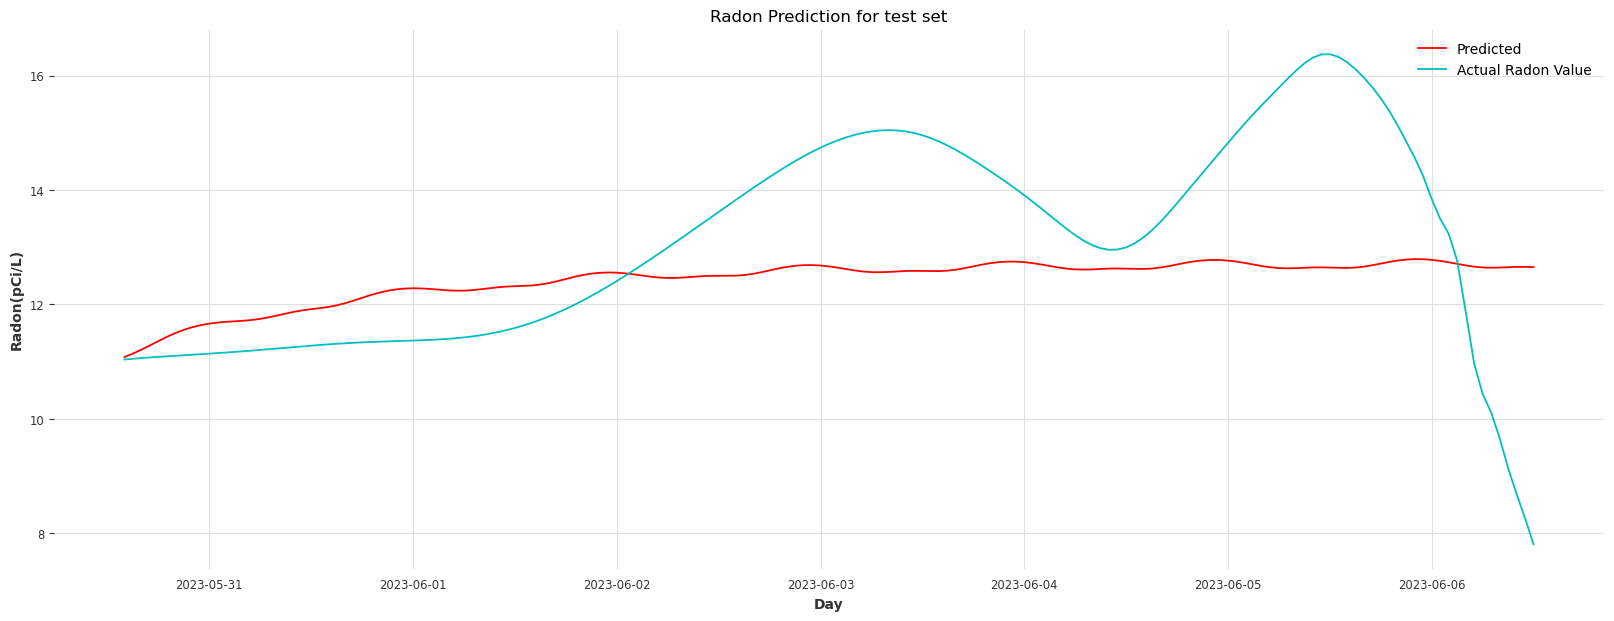

In [18]:
# plot the forecast
plt.figure(100, figsize=(20, 7))
plt.plot(dfY.index, dfY['Predicted'], color='r', label='Predicted')
plt.plot(dfY.index, dfY['Actual'], color='c', label='Actual Radon Value')
plt.legend()
plt.title('Radon Prediction for test set')
plt.xlabel('Day')
plt.ylabel('Radon(pCi/L)')
plt.show()

# Radon 13

In [19]:
df = df_radon['13'].copy()

In [20]:
# Denoising the Radon signal
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

In [21]:
def wavelet_denoising(x, wavelet='db4', level=5):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    n = len(x) 
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    if len(x) % 2 ==0:
        return pywt.waverec(coeff, wavelet, mode='per')
    else:
        return pywt.waverec(coeff, wavelet, mode='per')[:n]

In [22]:
signal = df['Radon'].copy()
wavelet_name='coif17'
filtered = wavelet_denoising(signal, wavelet=wavelet_name, level=4)
df['Radon'] = filtered

In [23]:
# create time series object for target variable
ts_P = TimeSeries.from_series(df["Radon"], fill_missing_dates=True, freq="H") 

# check attributes of the time series
print("components:", ts_P.components)
print("duration:",ts_P.duration)
print("frequency:",ts_P.freq)
print("frequency:",ts_P.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_P.has_datetime_index)
print("deterministic:",ts_P.is_deterministic)
print("univariate:",ts_P.is_univariate)

components: Index(['Radon'], dtype='object', name='component')
duration: 390 days 17:00:00
frequency: <Hour>
frequency: H
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: True


In [24]:
# train/test split and scaling of target variable
ts_train, ts_test = ts_P.split_after(split_point=9210)

print("training start:", ts_train.start_time())
print("training end:", ts_train.end_time())
print("training duration:",ts_train.duration)
print("test start:", ts_test.start_time())
print("test end:", ts_test.end_time())
print("test duration:", ts_test.duration)


scalerP = Scaler()
scalerP.fit_transform(ts_train)
ts_ttrain = scalerP.transform(ts_train)
ts_ttest = scalerP.transform(ts_test)    
ts_t = scalerP.transform(ts_P)

# make sure data are of type float
ts_t = ts_t.astype(np.float32)
ts_ttrain = ts_ttrain.astype(np.float32)
ts_ttest = ts_ttest.astype(np.float32)

print("first and last row of scaled Radon time series:")
pd.options.display.float_format = '{:,.2f}'.format
ts_t.pd_dataframe().iloc[[0,-1]]

training start: 2022-05-11 19:00:00
training end: 2023-05-30 13:00:00
training duration: 383 days 18:00:00
test start: 2023-05-30 14:00:00
test end: 2023-06-06 12:00:00
test duration: 6 days 22:00:00
first and last row of scaled Radon time series:


component            Radon
SyncDate                  
2022-05-11 19:00:00   0.05
2023-06-06 12:00:00   0.05

In [25]:
print("first and last row of scaled target variable in training set: price:")
ts_ttrain.pd_dataframe().iloc[[0,-1]]

first and last row of scaled target variable in training set: price:


component            Radon
SyncDate                  
2022-05-11 19:00:00   0.05
2023-05-30 13:00:00   0.03

In [26]:
import torch
from ray.air import session
from darts.utils.losses import SmapeLoss
from torchmetrics import MetricCollection, SymmetricMeanAbsolutePercentageError, MeanAbsolutePercentageError
def build_fit_rnn_model(
    model_args,
    save_checkpoints=False,
    callbacks=None,
    save_model=False
):
#     BATCH_SIZE=64
    MAX_EPOCHS=500
    NR_EPOCHS_VAL_PERIOD=1

    torch_metrics = MetricCollection([MeanAbsolutePercentageError(), SymmetricMeanAbsolutePercentageError()])

#     early_stopper = EarlyStopping(
#         monitor="val_loss",
#         patience=5,
#         min_delta=0.001,
#         mode='min',
#     )

#     if callbacks is None:
#         callbacks = [early_stopper]
#     else:
#         callbacks.append(early_stopper)
    
    #detect if GPU is available
#     if torch.cuda.is_available():
#         pl_trainer_kwargs = {
#             "accelerator": "gpu",
#             "gpus": -1,
#             "auto_select_gpus": True,
#             "callbacks": callbacks,
#             "enable_progress_bar":False,
#         }
#         num_workers=8
#     else:
#         pl_trainer_kwargs={
#             "callbacks": callbacks,
#         }
#         num_workers=0
    pl_trainer_kwargs={
            "accelerator": "gpu",
            "gpus":-1,
            "auto_select_gpus": True,
            "callbacks": callbacks,
            "enable_progress_bar": False,
        }
    encoders={"cyclic": {"future": ["hour"]},
             'transformer':Scaler()} if model_args['include_hour'] else None


    model = RNNModel(
        model=model_args['model'],
        input_chunk_length=model_args['in_len'],
        batch_size=model_args['batch_size'],
        n_epochs=MAX_EPOCHS,
        nr_epochs_val_period=NR_EPOCHS_VAL_PERIOD,
        model_name=f"{model_args['model']} RNN model",
        n_rnn_layers=model_args['n_rnn_layers'],
        training_length=model_args['in_len']+20,
        hidden_dim=model_args['hidden_dim'],
        dropout=model_args['dropout'],
        loss_fn=SmapeLoss(),
#         likelihood=QuantileRegression(quantiles=QUANTILES),
        optimizer_kwargs={'lr': model_args['lr']},
        add_encoders=encoders,
        log_tensorboard=False,
        force_reset=True,
        save_checkpoints=save_checkpoints,
        pl_trainer_kwargs=pl_trainer_kwargs,
        torch_metrics=torch_metrics,
        random_state=42,
        )
    val_len = len(ts_test)
    val_series = ts_ttrain[-((val_len) + model_args['in_len']) :]
    ts_ttrain_input = ts_ttrain[:-(val_len )]
    model.fit(  ts_ttrain_input, 
                val_series=val_series,
)
#     model.load_from_checkpoint(f"{model_args['model']} RNN model", best=True)
    ts_tpred = model.predict(
                series = ts_ttrain,
                n = len(ts_ttest),
                verbose=True
    )
    ts_q = scalerP.inverse_transform(ts_tpred)
    q_smape = smape(ts_q, ts_test)
    session.report({'q_smape': q_smape})

In [27]:
def build_fit_rnn_model_return(
    model_args,
    save_checkpoints=False,
    callbacks=None,
    save_model=False
):
#     BATCH_SIZE=64
    MAX_EPOCHS=500
    NR_EPOCHS_VAL_PERIOD=1

    torch_metrics = MetricCollection([MeanAbsolutePercentageError(), SymmetricMeanAbsolutePercentageError()])

#     early_stopper = EarlyStopping(
#         monitor="val_loss",
#         patience=5,
#         min_delta=0.001,
#         mode='min',
#     )

#     if callbacks is None:
#         callbacks = [early_stopper]
#     else:
#         callbacks.append(early_stopper)
    
    #detect if GPU is available
#     if torch.cuda.is_available():
#         pl_trainer_kwargs = {
#             "accelerator": "gpu",
#             "gpus": -1,
#             "auto_select_gpus": True,
#             "callbacks": callbacks,
#             "enable_progress_bar":False,
#         }
#         num_workers=8
#     else:
#         pl_trainer_kwargs={
#             "callbacks": callbacks,
#         }
#         num_workers=0
    pl_trainer_kwargs={
            "accelerator": "gpu",
            "devices":1,
            'callbacks': callbacks,
        }
    encoders={"cyclic": {"future": ["hour"]},
             'transformer':Scaler()} if model_args['include_hour'] else None


    model = RNNModel(
        model=model_args['model'],
        input_chunk_length=model_args['in_len'],
        batch_size=model_args['batch_size'],
        n_epochs=MAX_EPOCHS,
        nr_epochs_val_period=NR_EPOCHS_VAL_PERIOD,
        model_name=f"{model_args['model']} RNN model return",
        n_rnn_layers=model_args['n_rnn_layers'],
        training_length=model_args['in_len']+20,
        hidden_dim=model_args['hidden_dim'],
        dropout=model_args['dropout'],
        loss_fn=SmapeLoss(),
#         likelihood=QuantileRegression(quantiles=QUANTILES),
        optimizer_kwargs={'lr': model_args['lr']},
        add_encoders=encoders,
        log_tensorboard=False,
        force_reset=True,
        save_checkpoints=save_checkpoints,
        pl_trainer_kwargs=pl_trainer_kwargs,
        torch_metrics=torch_metrics,
        random_state=42
        )
    val_len = len(ts_test)
    val_series = ts_ttrain[-((val_len) + model_args['in_len']) :]
    ts_ttrain_input = ts_ttrain[:-(val_len )]
    model.fit(  ts_ttrain_input, 
                val_series=val_series,
)
#     if save_model:
#         print("have saved the model after training:", mpath)
#         model.save_model(mpath)
    return model

In [28]:
from ray import tune
from ray.tune import CLIReporter
# from ray.tune.integration.pytorch_lightning import TuneReportCallback
from ray.tune.schedulers import ASHAScheduler, AsyncHyperBandScheduler
from ray.tune.search.optuna import OptunaSearch
from ray.tune.search import ConcurrencyLimiter
# tune_callback = TuneReportCallback(
#     {
#         "loss":"val_loss",
#         "sMAPE": "val_SymmetricMeanAbsolutePercentageError",
#     },
#     on="validation_end",
# )

early_stopper = EarlyStopping(
        monitor="val_SymmetricMeanAbsolutePercentageError",
        patience=3,
        mode='min',
    )

#define the hyperparameter search space
config = {
    "batch_size": tune.choice([32,64,128]),
    "in_len": tune.randint(1,40),
    "dropout":tune.uniform(0.1,0.5),
    "model":tune.choice(['RNN','LSTM','GRU']),
    "hidden_dim":tune.randint(1,32),
    "n_rnn_layers":tune.randint(1,3),
    "lr":tune.loguniform(1e-5,1e-1),
    "include_hour":tune.choice([True,False]),
}

reporter = CLIReporter(
    parameter_columns=list(config.keys()),
    metric_columns=["q_smape"])
resources_per_trial = {"cpu": 5, "gpu": 0.4}

num_samples = 100

algo = OptunaSearch()

algo = ConcurrencyLimiter(algo, max_concurrent=10)

scheduler = AsyncHyperBandScheduler(max_t=100, grace_period=10, reduction_factor=2)

train_fn_with_parameters = tune.with_parameters(build_fit_rnn_model, callbacks=[early_stopper])

analysis = tune.run(
    train_fn_with_parameters,
    resources_per_trial=resources_per_trial,
    metric="q_smape",
    mode="min",
    config=config,
    num_samples=num_samples,
    search_alg=algo,
    scheduler = scheduler,
    progress_reporter=reporter,
    name="rnn_tune_cov",

)

print("Best hyperparameters found were: ", analysis.best_config)

== Status ==
Current time: 2023-07-07 23:29:41 (running for 00:00:00.14)
Memory usage on this node: 14.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 1/100 (1 RUNNING)
+------------------------------+----------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-----------+----------------+
| Trial name                   | status   | loc                  |   batch_size |   in_len |   dropout | model   |   hidden_dim |   n_rnn_layers |        lr | include_hour   |
|------------------------------+----------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-----------+----------------|
| build_fit_rnn_model_7f

(build_fit_rnn_model pid=1040695) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1040695)   rank_zero_deprecation(
(build_fit_rnn_model pid=1040695) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1040695)   rank_zero_deprecation(
(build_fit_rnn_model pid=1040695) Auto select gpus: [0]
(build_fit_rnn_model pid=1040695) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1040695) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:29:50 (running for 00:00:09.61)
Memory usage on this node: 18.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 9/100 (1 PENDING, 8 RUNNING)
+------------------------------+----------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+
| Trial name                   | status   | loc                  |   batch_size |   in_len |   dropout | model   |   hidden_dim |   n_rnn_layers |          lr | include_hour   |
|------------------------------+----------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+---------

(build_fit_rnn_model pid=1046875) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.19066393724446673 and num_layers=1
(build_fit_rnn_model pid=1046875)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=1046875) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1046875)   rank_zero_deprecation(
(build_fit_rnn_model pid=1046875) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` ha

(build_fit_rnn_model pid=1046877) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_rnn_model pid=1046877)   rank_zero_warn(
(build_fit_rnn_model pid=1046877) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_rnn_model pid=1046877)   rank_zero_warn(
(build_fit_rnn_model pid=1046877) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logg

(build_fit_rnn_model pid=1046866) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_rnn_model pid=1046866)   rank_zero_warn(
(build_fit_rnn_model pid=1046866) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_rnn_model pid=1046866)   rank_zero_warn(
(build_fit_rnn_model pid=1046872) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(lo

== Status ==
Current time: 2023-07-07 23:29:55 (running for 00:00:14.63)
Memory usage on this node: 33.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 9/100 (1 PENDING, 8 RUNNING)
+------------------------------+----------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+
| Trial name                   | status   | loc                  |   batch_size |   in_len |   dropout | model   |   hidden_dim |   n_rnn_layers |          lr | include_hour   |
|------------------------------+----------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+---------

(build_fit_rnn_model pid=1046868) Auto select gpus: [0]
(build_fit_rnn_model pid=1046868) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1046868) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1046868) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1046868) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1046868) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1046868) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 38.22it/s]


(build_fit_rnn_model pid=1046877) Auto select gpus: [0]
(build_fit_rnn_model pid=1046877) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1046877) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1046877) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1046877) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1046877) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1046877) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


== Status ==
Current time: 2023-07-07 23:30:01 (running for 00:00:20.71)
Memory usage on this node: 30.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 44b63830 with q_smape=198.8101388868548 and parameters={'batch_size': 128, 'in_len': 20, 'dropout': 0.20773155933563917, 'model': 'RNN', 'hidden_dim': 23, 'n_rnn_layers': 2, 'lr': 0.07201804174846034, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 9/100 (8 RUNNING, 1 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   

(build_fit_rnn_model pid=1048644) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3972848701807561 and num_layers=1
(build_fit_rnn_model pid=1048644)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=1048644) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1048644)   rank_zero_deprecation(
(build_fit_rnn_model pid=1048644) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.46it/s]


(build_fit_rnn_model pid=1040695) Auto select gpus: [0]
(build_fit_rnn_model pid=1040695) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1040695) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1040695) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1040695) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1040695) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1040695) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


== Status ==
Current time: 2023-07-07 23:30:06 (running for 00:00:25.71)
Memory usage on this node: 29.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cb946009 with q_smape=183.77042131532846 and parameters={'batch_size': 32, 'in_len': 7, 'dropout': 0.2197478729601227, 'model': 'GRU', 'hidden_dim': 2, 'n_rnn_layers': 1, 'lr': 0.0582676240405541, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 10/100 (8 RUNNING, 2 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_

(build_fit_rnn_model pid=1048877) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1048877)   rank_zero_deprecation(
(build_fit_rnn_model pid=1048877) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1048877)   rank_zero_deprecation(
(build_fit_rnn_model pid=1048877) Auto select gpus: [0]
(build_fit_rnn_model pid=1048877) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1048877) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:30:16 (running for 00:00:35.72)
Memory usage on this node: 32.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7fa98ea6 with q_smape=43.0468298636609 and parameters={'batch_size': 32, 'in_len': 30, 'dropout': 0.37891004530113426, 'model': 'GRU', 'hidden_dim': 21, 'n_rnn_layers': 2, 'lr': 0.02386488863666252, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 12/100 (1 PENDING, 8 RUNNING, 3 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1049114) Auto select gpus: [0]
(build_fit_rnn_model pid=1049114) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1049114) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1049114) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1049114) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1049114) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1049114) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=1049114) 
(build_fit_rnn_model pid=1049114)   | Name          | Type             | Params
(build_fit_rnn_model pid=1049114) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:30:21 (running for 00:00:40.73)
Memory usage on this node: 33.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7fa98ea6 with q_smape=43.0468298636609 and parameters={'batch_size': 32, 'in_len': 30, 'dropout': 0.37891004530113426, 'model': 'GRU', 'hidden_dim': 21, 'n_rnn_layers': 2, 'lr': 0.02386488863666252, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 12/100 (1 PENDING, 8 RUNNING, 3 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

== Status ==
Current time: 2023-07-07 23:30:36 (running for 00:00:55.74)
Memory usage on this node: 33.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7fa98ea6 with q_smape=43.0468298636609 and parameters={'batch_size': 32, 'in_len': 30, 'dropout': 0.37891004530113426, 'model': 'GRU', 'hidden_dim': 21, 'n_rnn_layers': 2, 'lr': 0.02386488863666252, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 12/100 (1 PENDING, 8 RUNNING, 3 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch

(build_fit_rnn_model pid=1046864) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1046864)   rank_zero_deprecation(
(build_fit_rnn_model pid=1046864) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1046864)   rank_zero_deprecation(
(build_fit_rnn_model pid=1046864) Auto select gpus: [0]
(build_fit_rnn_model pid=1046864) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1046864) TPU available: False, usin

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1046879) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1046879)   rank_zero_deprecation(
(build_fit_rnn_model pid=1046879) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1046879)   rank_zero_deprecation(
(build_fit_rnn_model pid=1046879) Auto select gpus: [0]
(build_fit_rnn_model pid=1046879) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1046879) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.02it/s]


(build_fit_rnn_model pid=1049435) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1049435)   rank_zero_deprecation(
(build_fit_rnn_model pid=1049435) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1049435)   rank_zero_deprecation(
(build_fit_rnn_model pid=1049437) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer,

== Status ==
Current time: 2023-07-07 23:30:44 (running for 00:01:03.73)
Memory usage on this node: 29.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 67c3d591 with q_smape=25.22268907848728 and parameters={'batch_size': 128, 'in_len': 11, 'dropout': 0.44602734218376894, 'model': 'LSTM', 'hidden_dim': 1, 'n_rnn_layers': 2, 'lr': 0.021269384492034537, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 14/100 (1 PENDING, 8 RUNNING, 5 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   bat

(build_fit_rnn_model pid=1049435) Auto select gpus: [0]
(build_fit_rnn_model pid=1049435) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1049435) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1049435) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1049435) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1049435) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1049437) Auto select gpus: [0]
(build_fit_rnn_model pid=1049437) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1049437) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1049437) IPU available: False, using: 0 I

== Status ==
Current time: 2023-07-07 23:30:49 (running for 00:01:08.75)
Memory usage on this node: 33.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 67c3d591 with q_smape=25.22268907848728 and parameters={'batch_size': 128, 'in_len': 11, 'dropout': 0.44602734218376894, 'model': 'LSTM', 'hidden_dim': 1, 'n_rnn_layers': 2, 'lr': 0.021269384492034537, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 14/100 (1 PENDING, 8 RUNNING, 5 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   bat

(build_fit_rnn_model pid=1048644) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1048644)   rank_zero_deprecation(
(build_fit_rnn_model pid=1048644) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1048644)   rank_zero_deprecation(
(build_fit_rnn_model pid=1048644) Auto select gpus: [0]
(build_fit_rnn_model pid=1048644) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1048644) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.44it/s]



(build_fit_rnn_model pid=1049114)   rank_zero_deprecation(
(build_fit_rnn_model pid=1049114) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1049114)   rank_zero_deprecation(
(build_fit_rnn_model pid=1049114) Auto select gpus: [0]
(build_fit_rnn_model pid=1049114) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1049114) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1049114) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1049114) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1049114) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_mat

== Status ==
Current time: 2023-07-07 23:30:58 (running for 00:01:17.73)
Memory usage on this node: 30.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 67c3d591 with q_smape=25.22268907848728 and parameters={'batch_size': 128, 'in_len': 11, 'dropout': 0.44602734218376894, 'model': 'LSTM', 'hidden_dim': 1, 'n_rnn_layers': 2, 'lr': 0.021269384492034537, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 16/100 (1 PENDING, 8 RUNNING, 7 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   bat

(build_fit_rnn_model pid=1049986) Auto select gpus: [0]
(build_fit_rnn_model pid=1049986) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1049986) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1049986) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1049986) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1049986) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1049984) Auto select gpus: [0]
(build_fit_rnn_model pid=1049984) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1049984) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1049984) IPU available: False, using: 0 I

== Status ==
Current time: 2023-07-07 23:31:03 (running for 00:01:22.74)
Memory usage on this node: 33.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 67c3d591 with q_smape=25.22268907848728 and parameters={'batch_size': 128, 'in_len': 11, 'dropout': 0.44602734218376894, 'model': 'LSTM', 'hidden_dim': 1, 'n_rnn_layers': 2, 'lr': 0.021269384492034537, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 16/100 (1 PENDING, 8 RUNNING, 7 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   bat

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.01it/s]


(build_fit_rnn_model pid=1049437) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1049437)   rank_zero_deprecation(
(build_fit_rnn_model pid=1049437) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1049437)   rank_zero_deprecation(
(build_fit_rnn_model pid=1049437) Auto select gpus: [0]
(build_fit_rnn_model pid=1049437) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1049437) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 37.27it/s]


(build_fit_rnn_model pid=1049986) Auto select gpus: [0]
(build_fit_rnn_model pid=1049986) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1049986) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1049986) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1049986) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1049986) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1049986) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=1050458) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so n

== Status ==
Current time: 2023-07-07 23:31:18 (running for 00:01:37.73)
Memory usage on this node: 31.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 67c3d591 with q_smape=25.22268907848728 and parameters={'batch_size': 128, 'in_len': 11, 'dropout': 0.44602734218376894, 'model': 'LSTM', 'hidden_dim': 1, 'n_rnn_layers': 2, 'lr': 0.021269384492034537, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 18/100 (1 PENDING, 8 RUNNING, 9 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   bat

(build_fit_rnn_model pid=1050619) Auto select gpus: [0]
(build_fit_rnn_model pid=1050619) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1050619) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1050619) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1050619) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1050619) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1050619) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=1050619) 
(build_fit_rnn_model pid=1050619)   | Name          | Type             | Params
(build_fit_rnn_model pid=1050619) ---------------------------------------------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.37it/s]


(build_fit_rnn_model pid=1049984) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1049984)   rank_zero_deprecation(
(build_fit_rnn_model pid=1049984) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1049984)   rank_zero_deprecation(
(build_fit_rnn_model pid=1049984) Auto select gpus: [0]
(build_fit_rnn_model pid=1049984) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1049984) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:31:28 (running for 00:01:47.75)
Memory usage on this node: 36.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 67c3d591 with q_smape=25.22268907848728 and parameters={'batch_size': 128, 'in_len': 11, 'dropout': 0.44602734218376894, 'model': 'LSTM', 'hidden_dim': 1, 'n_rnn_layers': 2, 'lr': 0.021269384492034537, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 19/100 (1 PENDING, 8 RUNNING, 10 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   ba

(build_fit_rnn_model pid=1056990) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.33697333551344666 and num_layers=1
(build_fit_rnn_model pid=1056990)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=1056990) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1056990)   rank_zero_deprecation(
(build_fit_rnn_model pid=1056990) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` ha

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 37.27it/s]


(build_fit_rnn_model pid=1050458) Auto select gpus: [0]
(build_fit_rnn_model pid=1050458) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1050458) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1050458) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1050458) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1050458) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1050458) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=1058908) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so n

== Status ==
Current time: 2023-07-07 23:31:38 (running for 00:01:57.74)
Memory usage on this node: 51.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 67c3d591 with q_smape=25.22268907848728 and parameters={'batch_size': 128, 'in_len': 11, 'dropout': 0.44602734218376894, 'model': 'LSTM', 'hidden_dim': 1, 'n_rnn_layers': 2, 'lr': 0.021269384492034537, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 20/100 (1 PENDING, 8 RUNNING, 11 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   ba

(build_fit_rnn_model pid=1058908) Auto select gpus: [0]
(build_fit_rnn_model pid=1058908) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1058908) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1058908) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1058908) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1058908) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1058908) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=1058908) 
(build_fit_rnn_model pid=1058908)   | Name          | Type             | Params
(build_fit_rnn_model pid=1058908) ---------------------------------------------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 36.60it/s]


(build_fit_rnn_model pid=1059165) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.31593422168727053 and num_layers=1
(build_fit_rnn_model pid=1059165)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=1059165) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1059165)   rank_zero_deprecation(
(build_fit_rnn_model pid=1059165) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` ha

== Status ==
Current time: 2023-07-07 23:31:46 (running for 00:02:05.74)
Memory usage on this node: 51.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 67c3d591 with q_smape=25.22268907848728 and parameters={'batch_size': 128, 'in_len': 11, 'dropout': 0.44602734218376894, 'model': 'LSTM', 'hidden_dim': 1, 'n_rnn_layers': 2, 'lr': 0.021269384492034537, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 21/100 (1 PENDING, 8 RUNNING, 12 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   ba

(build_fit_rnn_model pid=1059165) Auto select gpus: [0]
(build_fit_rnn_model pid=1059165) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1059165) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1059165) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1059165) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1059165) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1059165) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=1059165) 
(build_fit_rnn_model pid=1059165)   | Name          | Type             | Params
(build_fit_rnn_model pid=1059165) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:31:51 (running for 00:02:10.76)
Memory usage on this node: 53.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 67c3d591 with q_smape=25.22268907848728 and parameters={'batch_size': 128, 'in_len': 11, 'dropout': 0.44602734218376894, 'model': 'LSTM', 'hidden_dim': 1, 'n_rnn_layers': 2, 'lr': 0.021269384492034537, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 21/100 (1 PENDING, 8 RUNNING, 12 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   ba

(build_fit_rnn_model pid=1058908) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1058908)   rank_zero_deprecation(
(build_fit_rnn_model pid=1058908) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1058908)   rank_zero_deprecation(
(build_fit_rnn_model pid=1058908) Auto select gpus: [0]
(build_fit_rnn_model pid=1058908) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1058908) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.67it/s]
== Status ==
Current time: 2023-07-07 23:31:57 (running for 00:02:16.73)
Memory usage on this node: 50.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 67c3d591 with q_smape=25.22268907848728 and parameters={'batch_size': 128, 'in_len': 11, 'dropout': 0.44602734218376894, 'model': 'LSTM', 'hidden_dim': 1, 'n_rnn_layers': 2, 'lr': 0.021269384492034537, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 21/100 (8 RUNNING, 13 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name 

(build_fit_rnn_model pid=1059409) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3081847517624785 and num_layers=1
(build_fit_rnn_model pid=1059409)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=1059409) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1059409)   rank_zero_deprecation(
(build_fit_rnn_model pid=1059409) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has

== Status ==
Current time: 2023-07-07 23:32:07 (running for 00:02:26.49)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 67c3d591 with q_smape=25.22268907848728 and parameters={'batch_size': 128, 'in_len': 11, 'dropout': 0.44602734218376894, 'model': 'LSTM', 'hidden_dim': 1, 'n_rnn_layers': 2, 'lr': 0.021269384492034537, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 22/100 (1 PENDING, 8 RUNNING, 13 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   ba

== Status ==
Current time: 2023-07-07 23:32:17 (running for 00:02:36.51)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 67c3d591 with q_smape=25.22268907848728 and parameters={'batch_size': 128, 'in_len': 11, 'dropout': 0.44602734218376894, 'model': 'LSTM', 'hidden_dim': 1, 'n_rnn_layers': 2, 'lr': 0.021269384492034537, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 22/100 (1 PENDING, 8 RUNNING, 13 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   ba

(build_fit_rnn_model pid=1059165) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1059165)   rank_zero_deprecation(
(build_fit_rnn_model pid=1059165) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1059165)   rank_zero_deprecation(
(build_fit_rnn_model pid=1059165) Auto select gpus: [0]
(build_fit_rnn_model pid=1059165) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1059165) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.93it/s]


(build_fit_rnn_model pid=1056990) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1056990)   rank_zero_deprecation(
(build_fit_rnn_model pid=1056990) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1056990)   rank_zero_deprecation(
(build_fit_rnn_model pid=1056990) Auto select gpus: [0]
(build_fit_rnn_model pid=1056990) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1056990) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.23it/s]


(build_fit_rnn_model pid=1060061) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4072936742488011 and num_layers=1
(build_fit_rnn_model pid=1060061)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=1060061) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1060061)   rank_zero_deprecation(
(build_fit_rnn_model pid=1060061) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has

== Status ==
Current time: 2023-07-07 23:32:27 (running for 00:02:46.74)
Memory usage on this node: 46.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 67c3d591 with q_smape=25.22268907848728 and parameters={'batch_size': 128, 'in_len': 11, 'dropout': 0.44602734218376894, 'model': 'LSTM', 'hidden_dim': 1, 'n_rnn_layers': 2, 'lr': 0.021269384492034537, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 23/100 (8 RUNNING, 15 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size | 

(build_fit_rnn_model pid=1060292) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.42654837609592977 and num_layers=1
(build_fit_rnn_model pid=1060292)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=1060292) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1060292)   rank_zero_deprecation(
(build_fit_rnn_model pid=1060292) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` ha

== Status ==
Current time: 2023-07-07 23:32:37 (running for 00:02:56.37)
Memory usage on this node: 51.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 67c3d591 with q_smape=25.22268907848728 and parameters={'batch_size': 128, 'in_len': 11, 'dropout': 0.44602734218376894, 'model': 'LSTM', 'hidden_dim': 1, 'n_rnn_layers': 2, 'lr': 0.021269384492034537, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 24/100 (1 PENDING, 8 RUNNING, 15 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   ba

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 30.20it/s]


(build_fit_rnn_model pid=1049435) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1049435)   rank_zero_deprecation(
(build_fit_rnn_model pid=1049435) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1049435)   rank_zero_deprecation(
(build_fit_rnn_model pid=1049435) Auto select gpus: [0]
(build_fit_rnn_model pid=1049435) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1049435) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:32:50 (running for 00:03:09.76)
Memory usage on this node: 49.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 67c3d591 with q_smape=25.22268907848728 and parameters={'batch_size': 128, 'in_len': 11, 'dropout': 0.44602734218376894, 'model': 'LSTM', 'hidden_dim': 1, 'n_rnn_layers': 2, 'lr': 0.021269384492034537, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 25/100 (1 PENDING, 8 RUNNING, 16 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   ba

(build_fit_rnn_model pid=1061096) Auto select gpus: [0]
(build_fit_rnn_model pid=1061096) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1061096) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1061096) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1061096) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1061096) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1061096) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=1061096) 
(build_fit_rnn_model pid=1061096)   | Name          | Type             | Params
(build_fit_rnn_model pid=1061096) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:32:55 (running for 00:03:14.78)
Memory usage on this node: 51.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 67c3d591 with q_smape=25.22268907848728 and parameters={'batch_size': 128, 'in_len': 11, 'dropout': 0.44602734218376894, 'model': 'LSTM', 'hidden_dim': 1, 'n_rnn_layers': 2, 'lr': 0.021269384492034537, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 25/100 (1 PENDING, 8 RUNNING, 16 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   ba

== Status ==
Current time: 2023-07-07 23:33:05 (running for 00:03:24.79)
Memory usage on this node: 53.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 67c3d591 with q_smape=25.22268907848728 and parameters={'batch_size': 128, 'in_len': 11, 'dropout': 0.44602734218376894, 'model': 'LSTM', 'hidden_dim': 1, 'n_rnn_layers': 2, 'lr': 0.021269384492034537, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 25/100 (1 PENDING, 8 RUNNING, 16 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   ba

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.19it/s]


(build_fit_rnn_model pid=1046872) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1046872)   rank_zero_deprecation(
(build_fit_rnn_model pid=1046872) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1046872)   rank_zero_deprecation(
(build_fit_rnn_model pid=1046872) Auto select gpus: [0]
(build_fit_rnn_model pid=1046872) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1046872) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:33:16 (running for 00:03:35.78)
Memory usage on this node: 51.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 26/100 (1 PENDING, 8 RUNNING, 17 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1061818) Auto select gpus: [0]
(build_fit_rnn_model pid=1061818) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1061818) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1061818) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1061818) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1061818) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1061818) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=1061818) 
(build_fit_rnn_model pid=1061818)   | Name          | Type             | Params
(build_fit_rnn_model pid=1061818) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:33:21 (running for 00:03:40.78)
Memory usage on this node: 51.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 26/100 (1 PENDING, 8 RUNNING, 17 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:33:31 (running for 00:03:50.80)
Memory usage on this node: 48.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 26/100 (1 PENDING, 8 RUNNING, 17 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:33:41 (running for 00:04:00.81)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 26/100 (1 PENDING, 8 RUNNING, 17 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:33:51 (running for 00:04:10.83)
Memory usage on this node: 51.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 26/100 (1 PENDING, 8 RUNNING, 17 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1061096) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1061096)   rank_zero_deprecation(
(build_fit_rnn_model pid=1061096) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1061096)   rank_zero_deprecation(
(build_fit_rnn_model pid=1061096) Auto select gpus: [0]
(build_fit_rnn_model pid=1061096) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1061096) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.28it/s]


(build_fit_rnn_model pid=1060292) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1060292)   rank_zero_deprecation(
(build_fit_rnn_model pid=1060292) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1060292)   rank_zero_deprecation(
(build_fit_rnn_model pid=1060292) Auto select gpus: [0]
(build_fit_rnn_model pid=1060292) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1060292) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:34:01 (running for 00:04:20.77)
Memory usage on this node: 51.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 28/100 (1 PENDING, 8 RUNNING, 19 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1063418) Auto select gpus: [0]
(build_fit_rnn_model pid=1063418) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1063418) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1063418) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1063418) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1063418) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1063418) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=1063418) 
(build_fit_rnn_model pid=1063418)   | Name          | Type             | Params
(build_fit_rnn_model pid=1063418) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:34:06 (running for 00:04:25.78)
Memory usage on this node: 51.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 28/100 (1 PENDING, 8 RUNNING, 19 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1063255) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1063255)   rank_zero_deprecation(
(build_fit_rnn_model pid=1063255) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1063255)   rank_zero_deprecation(
(build_fit_rnn_model pid=1063255) Auto select gpus: [0]
(build_fit_rnn_model pid=1063255) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1063255) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 30.98it/s]


(build_fit_rnn_model pid=1059409) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1059409)   rank_zero_deprecation(
(build_fit_rnn_model pid=1059409) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1059409)   rank_zero_deprecation(
(build_fit_rnn_model pid=1059409) Auto select gpus: [0]
(build_fit_rnn_model pid=1059409) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1059409) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.16it/s]


(build_fit_rnn_model pid=1064377) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1064377)   rank_zero_deprecation(
(build_fit_rnn_model pid=1064377) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1064377)   rank_zero_deprecation(
(build_fit_rnn_model pid=1064379) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting 

== Status ==
Current time: 2023-07-07 23:34:21 (running for 00:04:40.81)
Memory usage on this node: 49.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 30/100 (1 PENDING, 8 RUNNING, 21 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1064377) Auto select gpus: [0]
(build_fit_rnn_model pid=1064379) Auto select gpus: [0]
(build_fit_rnn_model pid=1064379) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1064379) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1064379) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1064379) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1064379) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1064377) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1064377) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1064377) IPU available: False, using: 0 I

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1060061) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1060061)   rank_zero_deprecation(
(build_fit_rnn_model pid=1060061) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1060061)   rank_zero_deprecation(
(build_fit_rnn_model pid=1060061) Auto select gpus: [0]
(build_fit_rnn_model pid=1060061) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1060061) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.83it/s]


(build_fit_rnn_model pid=1064939) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1064939)   rank_zero_deprecation(
(build_fit_rnn_model pid=1064939) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1064939)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 23:34:31 (running for 00:04:50.77)
Memory usage on this node: 49.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 31/100 (1 PENDING, 8 RUNNING, 22 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1064939) Auto select gpus: [0]
(build_fit_rnn_model pid=1064939) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1064939) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1064939) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1064939) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1064939) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1064939) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=1064939) 
(build_fit_rnn_model pid=1064939)   | Name          | Type             | Params
(build_fit_rnn_model pid=1064939) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:34:36 (running for 00:04:55.78)
Memory usage on this node: 51.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 31/100 (1 PENDING, 8 RUNNING, 22 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:34:46 (running for 00:05:05.80)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 31/100 (1 PENDING, 8 RUNNING, 22 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:34:56 (running for 00:05:15.82)
Memory usage on this node: 53.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 31/100 (1 PENDING, 8 RUNNING, 22 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:35:06 (running for 00:05:25.84)
Memory usage on this node: 53.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 31/100 (1 PENDING, 8 RUNNING, 22 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1046875) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1046875)   rank_zero_deprecation(
(build_fit_rnn_model pid=1046875) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1046875)   rank_zero_deprecation(
(build_fit_rnn_model pid=1046875) Auto select gpus: [0]
(build_fit_rnn_model pid=1046875) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1046875) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.18it/s]


(build_fit_rnn_model pid=1065710) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1065710)   rank_zero_deprecation(
(build_fit_rnn_model pid=1065710) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1065710)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 23:35:21 (running for 00:05:40.80)
Memory usage on this node: 51.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 32/100 (1 PENDING, 8 RUNNING, 23 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1065710) Auto select gpus: [0]
(build_fit_rnn_model pid=1065710) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1065710) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1065710) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1065710) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1065710) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1065710) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=1065710) 
(build_fit_rnn_model pid=1065710)   | Name          | Type             | Params
(build_fit_rnn_model pid=1065710) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:35:26 (running for 00:05:45.81)
Memory usage on this node: 51.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 32/100 (1 PENDING, 8 RUNNING, 23 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:35:36 (running for 00:05:55.82)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 32/100 (1 PENDING, 8 RUNNING, 23 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:35:46 (running for 00:06:05.84)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 32/100 (1 PENDING, 8 RUNNING, 23 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:35:56 (running for 00:06:15.86)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 32/100 (1 PENDING, 8 RUNNING, 23 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:36:06 (running for 00:06:25.88)
Memory usage on this node: 53.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 32/100 (1 PENDING, 8 RUNNING, 23 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:36:16 (running for 00:06:35.90)
Memory usage on this node: 51.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 32/100 (1 PENDING, 8 RUNNING, 23 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:36:26 (running for 00:06:45.92)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 32/100 (1 PENDING, 8 RUNNING, 23 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:36:36 (running for 00:06:55.94)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 32/100 (1 PENDING, 8 RUNNING, 23 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:36:46 (running for 00:07:05.96)
Memory usage on this node: 49.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 32/100 (1 PENDING, 8 RUNNING, 23 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1046866) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1046866)   rank_zero_deprecation(
(build_fit_rnn_model pid=1046866) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1046866)   rank_zero_deprecation(
(build_fit_rnn_model pid=1046866) Auto select gpus: [0]
(build_fit_rnn_model pid=1046866) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1046866) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.93it/s]


(build_fit_rnn_model pid=1067227) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1067227)   rank_zero_deprecation(
(build_fit_rnn_model pid=1067227) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1067227)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 23:36:57 (running for 00:07:16.80)
Memory usage on this node: 51.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 33/100 (1 PENDING, 8 RUNNING, 24 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1067227) Auto select gpus: [0]
(build_fit_rnn_model pid=1067227) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1067227) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1067227) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1067227) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1067227) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1067227) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=1067227) 
(build_fit_rnn_model pid=1067227)   | Name          | Type             | Params
(build_fit_rnn_model pid=1067227) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:37:02 (running for 00:07:21.81)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 33/100 (1 PENDING, 8 RUNNING, 24 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:37:12 (running for 00:07:31.83)
Memory usage on this node: 51.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 33/100 (1 PENDING, 8 RUNNING, 24 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:37:22 (running for 00:07:41.85)
Memory usage on this node: 53.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 33/100 (1 PENDING, 8 RUNNING, 24 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:37:32 (running for 00:07:51.87)
Memory usage on this node: 53.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 33/100 (1 PENDING, 8 RUNNING, 24 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:37:42 (running for 00:08:01.88)
Memory usage on this node: 53.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 33/100 (1 PENDING, 8 RUNNING, 24 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 30.68it/s]


(build_fit_rnn_model pid=1064939) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1064939)   rank_zero_deprecation(
(build_fit_rnn_model pid=1064939) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1064939)   rank_zero_deprecation(
(build_fit_rnn_model pid=1064939) Auto select gpus: [0]
(build_fit_rnn_model pid=1064939) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1064939) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:37:52 (running for 00:08:11.91)
Memory usage on this node: 51.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 33/100 (1 PENDING, 8 RUNNING, 24 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1064379) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1064379)   rank_zero_deprecation(
(build_fit_rnn_model pid=1064379) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1064379)   rank_zero_deprecation(
(build_fit_rnn_model pid=1064379) Auto select gpus: [0]
(build_fit_rnn_model pid=1064379) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1064379) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 27.94it/s]


(build_fit_rnn_model pid=1068386) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1068386)   rank_zero_deprecation(
(build_fit_rnn_model pid=1068386) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1068386)   rank_zero_deprecation(
(build_fit_rnn_model pid=1068388) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting 

== Status ==
Current time: 2023-07-07 23:37:59 (running for 00:08:18.83)
Memory usage on this node: 49.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 35/100 (1 PENDING, 8 RUNNING, 26 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1068386) Auto select gpus: [0]
(build_fit_rnn_model pid=1068386) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1068386) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1068386) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1068386) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1068386) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1068388) Auto select gpus: [0]
(build_fit_rnn_model pid=1068388) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1068388) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1068388) IPU available: False, using: 0 I

== Status ==
Current time: 2023-07-07 23:38:04 (running for 00:08:23.84)
Memory usage on this node: 51.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 35/100 (1 PENDING, 8 RUNNING, 26 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:38:14 (running for 00:08:33.86)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 35/100 (1 PENDING, 8 RUNNING, 26 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:38:24 (running for 00:08:43.88)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 35/100 (1 PENDING, 8 RUNNING, 26 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:38:34 (running for 00:08:53.90)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 35/100 (1 PENDING, 8 RUNNING, 26 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:38:44 (running for 00:09:03.92)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 35/100 (1 PENDING, 8 RUNNING, 26 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:38:54 (running for 00:09:13.93)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 35/100 (1 PENDING, 8 RUNNING, 26 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1065710) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1065710)   rank_zero_deprecation(
(build_fit_rnn_model pid=1065710) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1065710)   rank_zero_deprecation(
(build_fit_rnn_model pid=1065710) Auto select gpus: [0]
(build_fit_rnn_model pid=1065710) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1065710) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.19it/s]


(build_fit_rnn_model pid=1069202) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1069202)   rank_zero_deprecation(
(build_fit_rnn_model pid=1069202) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1069202)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 23:39:03 (running for 00:09:22.82)
Memory usage on this node: 49.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 36/100 (1 PENDING, 8 RUNNING, 27 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1069202) Auto select gpus: [0]
(build_fit_rnn_model pid=1069202) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1069202) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1069202) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1069202) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1069202) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1069202) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=1069202) 
(build_fit_rnn_model pid=1069202)   | Name          | Type             | Params
(build_fit_rnn_model pid=1069202) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:39:08 (running for 00:09:27.83)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 36/100 (1 PENDING, 8 RUNNING, 27 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1067227) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1067227)   rank_zero_deprecation(
(build_fit_rnn_model pid=1067227) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1067227)   rank_zero_deprecation(
(build_fit_rnn_model pid=1067227) Auto select gpus: [0]
(build_fit_rnn_model pid=1067227) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1067227) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:39:17 (running for 00:09:36.82)
Memory usage on this node: 51.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 37/100 (1 PENDING, 8 RUNNING, 28 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1069681) Auto select gpus: [0]
(build_fit_rnn_model pid=1069681) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1069681) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1069681) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1069681) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1069681) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1069681) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=1069681) 
(build_fit_rnn_model pid=1069681)   | Name          | Type             | Params
(build_fit_rnn_model pid=1069681) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:39:22 (running for 00:09:41.84)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 37/100 (1 PENDING, 8 RUNNING, 28 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1061818) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1061818)   rank_zero_deprecation(
(build_fit_rnn_model pid=1061818) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1061818)   rank_zero_deprecation(
(build_fit_rnn_model pid=1061818) Auto select gpus: [0]
(build_fit_rnn_model pid=1061818) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1061818) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.94it/s]
== Status ==
Current time: 2023-07-07 23:39:29 (running for 00:09:48.83)
Memory usage on this node: 49.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 38/100 (1 PENDING, 8 RUNNING, 29 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+

(build_fit_rnn_model pid=1069932) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1069932)   rank_zero_deprecation(
(build_fit_rnn_model pid=1069932) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1069932)   rank_zero_deprecation(
(build_fit_rnn_model pid=1069932) Auto select gpus: [0]
(build_fit_rnn_model pid=1069932) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1069932) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:39:34 (running for 00:09:53.84)
Memory usage on this node: 51.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 38/100 (1 PENDING, 8 RUNNING, 29 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:39:44 (running for 00:10:03.86)
Memory usage on this node: 51.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 38/100 (1 PENDING, 8 RUNNING, 29 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:39:54 (running for 00:10:13.88)
Memory usage on this node: 53.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 38/100 (1 PENDING, 8 RUNNING, 29 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1069932) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1069932)   rank_zero_deprecation(
(build_fit_rnn_model pid=1069932) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1069932)   rank_zero_deprecation(
(build_fit_rnn_model pid=1069932) Auto select gpus: [0]
(build_fit_rnn_model pid=1069932) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1069932) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.54it/s]


(build_fit_rnn_model pid=1069681) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1069681)   rank_zero_deprecation(
(build_fit_rnn_model pid=1069681) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1069681)   rank_zero_deprecation(
(build_fit_rnn_model pid=1069681) Auto select gpus: [0]
(build_fit_rnn_model pid=1069681) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1069681) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:40:05 (running for 00:10:24.66)
Memory usage on this node: 50.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 39/100 (1 PENDING, 8 RUNNING, 30 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1070938) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1070938)   rank_zero_deprecation(
(build_fit_rnn_model pid=1070938) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1070938)   rank_zero_deprecation(
(build_fit_rnn_model pid=1070938) Auto select gpus: [0]
(build_fit_rnn_model pid=1070938) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1070938) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:40:12 (running for 00:10:31.83)
Memory usage on this node: 49.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 40/100 (1 PENDING, 8 RUNNING, 31 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1071179) Auto select gpus: [0]
(build_fit_rnn_model pid=1071179) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1071179) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1071179) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1071179) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1071179) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1071179) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=1071179) 
(build_fit_rnn_model pid=1071179)   | Name          | Type             | Params
(build_fit_rnn_model pid=1071179) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:40:17 (running for 00:10:36.84)
Memory usage on this node: 53.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 40/100 (1 PENDING, 8 RUNNING, 31 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1070938) Auto select gpus: [0]
(build_fit_rnn_model pid=1070938) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1070938) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1070938) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1070938) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1070938) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1070938) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.20it/s]


(build_fit_rnn_model pid=1071665) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1071665)   rank_zero_deprecation(
(build_fit_rnn_model pid=1071665) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1071665)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 23:40:32 (running for 00:10:51.85)
Memory usage on this node: 51.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 41/100 (1 PENDING, 8 RUNNING, 32 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1071665) Auto select gpus: [0]
(build_fit_rnn_model pid=1071665) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1071665) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1071665) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1071665) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1071665) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1071665) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=1071665) 
(build_fit_rnn_model pid=1071665)   | Name          | Type             | Params
(build_fit_rnn_model pid=1071665) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:40:37 (running for 00:10:56.86)
Memory usage on this node: 53.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 41/100 (1 PENDING, 8 RUNNING, 32 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:40:47 (running for 00:11:06.88)
Memory usage on this node: 51.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 41/100 (1 PENDING, 8 RUNNING, 32 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:40:57 (running for 00:11:16.90)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 41/100 (1 PENDING, 8 RUNNING, 32 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1048877) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1048877)   rank_zero_deprecation(
(build_fit_rnn_model pid=1048877) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1048877)   rank_zero_deprecation(
(build_fit_rnn_model pid=1048877) Auto select gpus: [0]
(build_fit_rnn_model pid=1048877) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1048877) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 30.50it/s]


(build_fit_rnn_model pid=1072832) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1072832)   rank_zero_deprecation(
(build_fit_rnn_model pid=1072832) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1072832)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 23:41:12 (running for 00:11:31.85)
Memory usage on this node: 51.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 42/100 (1 PENDING, 8 RUNNING, 33 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1072832) Auto select gpus: [0]
(build_fit_rnn_model pid=1072832) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1072832) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1072832) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1072832) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1072832) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1068386) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 28.55it/s]


(build_fit_rnn_model pid=1072832) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=1072832) 
(build_fit_rnn_model pid=1072832)   | Name          | Type             | Params
(build_fit_rnn_model pid=1072832) ---------------------------------------------------
(build_fit_rnn_model pid=1072832) 0 | criterion     | SmapeLoss        | 0     
(build_fit_rnn_model pid=1072832) 1 | train_metrics | MetricCollection | 0     
(build_fit_rnn_model pid=1072832) 2 | val_metrics   | MetricCollection | 0     
(build_fit_rnn_model pid=1072832) 3 | rnn           | LSTM             | 304   
(build_fit_rnn_model pid=1072832) 4 | V             | Linear           | 5     
(build_fit_rnn_model pid=1072832) ---------------------------------------------------
(build_fit_rnn_model pid=1072832) 309       Trainable params
(build_fit_rnn_model pid=1072832) 0         Non-trainable params
(build_fit_rnn_model pid=1072832) 309       Total params
(build_fit_rnn_model pid=1072832) 0.001     Total esti

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.77it/s]
== Status ==
Current time: 2023-07-07 23:41:19 (running for 00:11:38.23)
Memory usage on this node: 51.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 43/100 (1 PENDING, 8 RUNNING, 34 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+

(build_fit_rnn_model pid=1073153) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1073153)   rank_zero_deprecation(
(build_fit_rnn_model pid=1073153) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1073153)   rank_zero_deprecation(
(build_fit_rnn_model pid=1073153) Auto select gpus: [0]
(build_fit_rnn_model pid=1073153) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1073153) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:41:25 (running for 00:11:44.85)
Memory usage on this node: 49.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 44/100 (1 PENDING, 8 RUNNING, 35 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1073433) Auto select gpus: [0]
(build_fit_rnn_model pid=1073433) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1073433) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1073433) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1073433) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1073433) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1073433) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=1073433) 
(build_fit_rnn_model pid=1073433)   | Name          | Type             | Params
(build_fit_rnn_model pid=1073433) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:41:30 (running for 00:11:49.86)
Memory usage on this node: 52.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 44/100 (1 PENDING, 8 RUNNING, 35 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:41:40 (running for 00:11:59.87)
Memory usage on this node: 53.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 44/100 (1 PENDING, 8 RUNNING, 35 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:41:50 (running for 00:12:09.89)
Memory usage on this node: 51.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 44/100 (1 PENDING, 8 RUNNING, 35 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:42:00 (running for 00:12:19.91)
Memory usage on this node: 51.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 44/100 (1 PENDING, 8 RUNNING, 35 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1064377) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1064377)   rank_zero_deprecation(
(build_fit_rnn_model pid=1064377) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1064377)   rank_zero_deprecation(
(build_fit_rnn_model pid=1064377) Auto select gpus: [0]
(build_fit_rnn_model pid=1064377) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1064377) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 26.97it/s]


(build_fit_rnn_model pid=1074412) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1074412)   rank_zero_deprecation(
(build_fit_rnn_model pid=1074412) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1074412)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 23:42:15 (running for 00:12:34.85)
Memory usage on this node: 47.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 45/100 (1 PENDING, 8 RUNNING, 36 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1074412) Auto select gpus: [0]
(build_fit_rnn_model pid=1074412) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1074412) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1074412) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1074412) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1074412) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1074412) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=1074412) 
(build_fit_rnn_model pid=1074412)   | Name          | Type             | Params
(build_fit_rnn_model pid=1074412) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:42:20 (running for 00:12:39.87)
Memory usage on this node: 48.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 45/100 (1 PENDING, 8 RUNNING, 36 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1068388) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1068388)   rank_zero_deprecation(
(build_fit_rnn_model pid=1068388) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1068388)   rank_zero_deprecation(
(build_fit_rnn_model pid=1068388) Auto select gpus: [0]
(build_fit_rnn_model pid=1068388) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1068388) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:42:27 (running for 00:12:46.85)
Memory usage on this node: 51.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 46/100 (1 PENDING, 8 RUNNING, 37 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1075290) Auto select gpus: [0]
(build_fit_rnn_model pid=1075290) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1075290) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1075290) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1075290) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1075290) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1075290) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=1075290) 
(build_fit_rnn_model pid=1075290)   | Name          | Type             | Params
(build_fit_rnn_model pid=1075290) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:42:32 (running for 00:12:51.86)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 46/100 (1 PENDING, 8 RUNNING, 37 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1071665) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1071665)   rank_zero_deprecation(
(build_fit_rnn_model pid=1071665) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1071665)   rank_zero_deprecation(
(build_fit_rnn_model pid=1071665) Auto select gpus: [0]
(build_fit_rnn_model pid=1071665) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1071665) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.38it/s]


(build_fit_rnn_model pid=1075845) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1075845)   rank_zero_deprecation(
(build_fit_rnn_model pid=1075845) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1075845)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 23:42:45 (running for 00:13:04.87)
Memory usage on this node: 49.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 47/100 (1 PENDING, 8 RUNNING, 38 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1075845) Auto select gpus: [0]
(build_fit_rnn_model pid=1075845) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1075845) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1075845) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1075845) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1075845) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1075845) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=1075845) 
(build_fit_rnn_model pid=1075845)   | Name          | Type             | Params
(build_fit_rnn_model pid=1075845) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:42:50 (running for 00:13:09.88)
Memory usage on this node: 53.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 47/100 (1 PENDING, 8 RUNNING, 38 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:43:00 (running for 00:13:19.89)
Memory usage on this node: 51.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 47/100 (1 PENDING, 8 RUNNING, 38 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1069202) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1069202)   rank_zero_deprecation(
(build_fit_rnn_model pid=1069202) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1069202)   rank_zero_deprecation(
(build_fit_rnn_model pid=1069202) Auto select gpus: [0]
(build_fit_rnn_model pid=1069202) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1069202) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.17it/s]


(build_fit_rnn_model pid=1076499) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1076499)   rank_zero_deprecation(
(build_fit_rnn_model pid=1076499) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1076499)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 23:43:07 (running for 00:13:26.88)
Memory usage on this node: 51.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 48/100 (1 PENDING, 8 RUNNING, 39 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1074412) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1074412)   rank_zero_deprecation(
(build_fit_rnn_model pid=1074412) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1074412)   rank_zero_deprecation(
(build_fit_rnn_model pid=1074412) Auto select gpus: [0]
(build_fit_rnn_model pid=1074412) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1074412) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 28.33it/s]


(build_fit_rnn_model pid=1076499) Auto select gpus: [0]
(build_fit_rnn_model pid=1076499) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1076499) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1076499) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1076499) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1076499) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1076499) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=1076499) 
(build_fit_rnn_model pid=1076499)   | Name          | Type             | Params
(build_fit_rnn_model pid=1076499) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:43:13 (running for 00:13:32.87)
Memory usage on this node: 51.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 49/100 (1 PENDING, 8 RUNNING, 40 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1076808) Auto select gpus: [0]
(build_fit_rnn_model pid=1076808) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1076808) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1076808) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1076808) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1076808) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1076808) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=1076808) 
(build_fit_rnn_model pid=1076808)   | Name          | Type             | Params
(build_fit_rnn_model pid=1076808) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:43:18 (running for 00:13:37.88)
Memory usage on this node: 51.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 49/100 (1 PENDING, 8 RUNNING, 40 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1076499) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1076499)   rank_zero_deprecation(
(build_fit_rnn_model pid=1076499) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1076499)   rank_zero_deprecation(
(build_fit_rnn_model pid=1076499) Auto select gpus: [0]
(build_fit_rnn_model pid=1076499) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1076499) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 30.98it/s]


(build_fit_rnn_model pid=1072832) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1072832)   rank_zero_deprecation(
(build_fit_rnn_model pid=1072832) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1072832)   rank_zero_deprecation(
(build_fit_rnn_model pid=1072832) Auto select gpus: [0]
(build_fit_rnn_model pid=1072832) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1072832) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 27.64it/s]


(build_fit_rnn_model pid=1077292) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1077292)   rank_zero_deprecation(
(build_fit_rnn_model pid=1077292) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1077292)   rank_zero_deprecation(
(build_fit_rnn_model pid=1077456) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting 

== Status ==
Current time: 2023-07-07 23:43:30 (running for 00:13:49.89)
Memory usage on this node: 47.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 51/100 (1 PENDING, 8 RUNNING, 42 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1077292) Auto select gpus: [0]
(build_fit_rnn_model pid=1077292) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1077292) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1077292) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1077292) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1077292) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1077456) Auto select gpus: [0]
(build_fit_rnn_model pid=1077456) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1077456) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1077456) IPU available: False, using: 0 I

== Status ==
Current time: 2023-07-07 23:43:35 (running for 00:13:54.90)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 51/100 (1 PENDING, 8 RUNNING, 42 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:43:45 (running for 00:14:04.92)
Memory usage on this node: 49.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 51/100 (1 PENDING, 8 RUNNING, 42 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1077292) Auto select gpus: [0]
(build_fit_rnn_model pid=1077292) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1077292) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1077292) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1077292) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1077292) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1077292) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.26it/s]


(build_fit_rnn_model pid=1078494) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1078494)   rank_zero_deprecation(
(build_fit_rnn_model pid=1078494) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1078494)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 23:43:58 (running for 00:14:17.88)
Memory usage on this node: 49.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 52/100 (1 PENDING, 8 RUNNING, 43 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1078494) Auto select gpus: [0]
(build_fit_rnn_model pid=1078494) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1078494) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1078494) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1078494) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1078494) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1078494) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=1078494) 
(build_fit_rnn_model pid=1078494)   | Name          | Type             | Params
(build_fit_rnn_model pid=1078494) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:44:03 (running for 00:14:22.89)
Memory usage on this node: 51.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 52/100 (1 PENDING, 8 RUNNING, 43 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:44:13 (running for 00:14:32.92)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 52/100 (1 PENDING, 8 RUNNING, 43 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:44:23 (running for 00:14:42.94)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 52/100 (1 PENDING, 8 RUNNING, 43 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:44:33 (running for 00:14:52.96)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 52/100 (1 PENDING, 8 RUNNING, 43 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:44:44 (running for 00:15:02.98)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 52/100 (1 PENDING, 8 RUNNING, 43 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.17it/s]


(build_fit_rnn_model pid=1075845) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1075845)   rank_zero_deprecation(
(build_fit_rnn_model pid=1075845) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1075845)   rank_zero_deprecation(
(build_fit_rnn_model pid=1075845) Auto select gpus: [0]
(build_fit_rnn_model pid=1075845) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1075845) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:44:58 (running for 00:15:17.91)
Memory usage on this node: 51.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 53/100 (1 PENDING, 8 RUNNING, 44 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1079279) Auto select gpus: [0]
(build_fit_rnn_model pid=1079279) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1079279) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1079279) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1079279) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1079279) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1079279) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=1079279) 
(build_fit_rnn_model pid=1079279)   | Name          | Type             | Params
(build_fit_rnn_model pid=1079279) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:45:03 (running for 00:15:22.91)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 53/100 (1 PENDING, 8 RUNNING, 44 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:45:13 (running for 00:15:32.94)
Memory usage on this node: 51.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 53/100 (1 PENDING, 8 RUNNING, 44 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1076808) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1076808)   rank_zero_deprecation(
(build_fit_rnn_model pid=1076808) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1076808)   rank_zero_deprecation(
(build_fit_rnn_model pid=1076808) Auto select gpus: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.89it/s]


(build_fit_rnn_model pid=1073153) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1073153)   rank_zero_deprecation(
(build_fit_rnn_model pid=1073153) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1073153)   rank_zero_deprecation(
(build_fit_rnn_model pid=1073153) Auto select gpus: [0]
(build_fit_rnn_model pid=1073153) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1073153) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 29.86it/s]


(build_fit_rnn_model pid=1079767) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1079767)   rank_zero_deprecation(
(build_fit_rnn_model pid=1079767) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1079767)   rank_zero_deprecation(
(build_fit_rnn_model pid=1079769) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting 

== Status ==
Current time: 2023-07-07 23:45:20 (running for 00:15:39.94)
Memory usage on this node: 49.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 55/100 (1 PENDING, 8 RUNNING, 46 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1079767) Auto select gpus: [0]
(build_fit_rnn_model pid=1079767) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1079767) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1079767) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1079767) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1079767) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1079769) Auto select gpus: [0]
(build_fit_rnn_model pid=1079769) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1079769) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1079769) IPU available: False, using: 0 I

== Status ==
Current time: 2023-07-07 23:45:25 (running for 00:15:44.94)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 55/100 (1 PENDING, 8 RUNNING, 46 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1079279) Auto select gpus: [0]
(build_fit_rnn_model pid=1079279) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1079279) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1079279) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1079279) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1079279) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1079279) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.00it/s]


(build_fit_rnn_model pid=1080244) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1080244)   rank_zero_deprecation(
(build_fit_rnn_model pid=1080244) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1080244)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 23:45:34 (running for 00:15:53.89)
Memory usage on this node: 51.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 56/100 (1 PENDING, 8 RUNNING, 47 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1080244) Auto select gpus: [0]
(build_fit_rnn_model pid=1080244) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1080244) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1080244) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1080244) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1080244) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1080244) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=1080244) 
(build_fit_rnn_model pid=1080244)   | Name          | Type             | Params
(build_fit_rnn_model pid=1080244) ---------------------------------------------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1079767) Auto select gpus: [0]
(build_fit_rnn_model pid=1079767) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1079767) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1079767) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1079767) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1079767) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1079767) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.34it/s]


(build_fit_rnn_model pid=1075290) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1075290)   rank_zero_deprecation(
(build_fit_rnn_model pid=1075290) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1075290)   rank_zero_deprecation(
(build_fit_rnn_model pid=1075290) Auto select gpus: [0]
(build_fit_rnn_model pid=1075290) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1075290) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 30.77it/s]
== Status ==
Current time: 2023-07-07 23:45:44 (running for 00:16:03.19)
Memory usage on this node: 51.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 57/100 (1 PENDING, 8 RUNNING, 48 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+

(build_fit_rnn_model pid=1080486) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1080486)   rank_zero_deprecation(
(build_fit_rnn_model pid=1080486) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1080486)   rank_zero_deprecation(
(build_fit_rnn_model pid=1080486) Auto select gpus: [0]
(build_fit_rnn_model pid=1080486) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1080486) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:45:49 (running for 00:16:08.90)
Memory usage on this node: 51.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 58/100 (1 PENDING, 8 RUNNING, 49 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1080721) Auto select gpus: [0]
(build_fit_rnn_model pid=1080721) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1080721) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1080721) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1080721) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1080721) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1080721) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=1080721) 
(build_fit_rnn_model pid=1080721)   | Name          | Type             | Params
(build_fit_rnn_model pid=1080721) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:45:54 (running for 00:16:13.91)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 58/100 (1 PENDING, 8 RUNNING, 49 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1063418) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1063418)   rank_zero_deprecation(
(build_fit_rnn_model pid=1063418) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1063418)   rank_zero_deprecation(
(build_fit_rnn_model pid=1063418) Auto select gpus: [0]
(build_fit_rnn_model pid=1063418) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1063418) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.53it/s]


(build_fit_rnn_model pid=1079769) Auto select gpus: [0]
(build_fit_rnn_model pid=1079769) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1079769) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1079769) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1079769) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1079769) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1079769) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=1081015) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trai

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.34it/s]
== Status ==
Current time: 2023-07-07 23:46:03 (running for 00:16:22.46)
Memory usage on this node: 48.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 60/100 (1 PENDING, 8 RUNNING, 51 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+

(build_fit_rnn_model pid=1081176) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1081176)   rank_zero_deprecation(
(build_fit_rnn_model pid=1081176) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1081176)   rank_zero_deprecation(
(build_fit_rnn_model pid=1081015) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=1081015) 
(build_fit_rnn_model pid=1081015)   | Name          | Type             | Param

== Status ==
Current time: 2023-07-07 23:46:08 (running for 00:16:27.89)
Memory usage on this node: 51.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 61/100 (1 PENDING, 8 RUNNING, 52 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1081650) Auto select gpus: [0]
(build_fit_rnn_model pid=1081650) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1081650) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1081650) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1081650) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1081650) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1081650) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=1081650) 
(build_fit_rnn_model pid=1081650)   | Name          | Type             | Params
(build_fit_rnn_model pid=1081650) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:46:13 (running for 00:16:32.90)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 61/100 (1 PENDING, 8 RUNNING, 52 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1080721) Auto select gpus: [0]
(build_fit_rnn_model pid=1080721) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1080721) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1080721) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1080721) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1080721) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1080721) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.48it/s]


(build_fit_rnn_model pid=1081982) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1081982)   rank_zero_deprecation(
(build_fit_rnn_model pid=1081982) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1081982)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 23:46:22 (running for 00:16:41.90)
Memory usage on this node: 51.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 62/100 (1 PENDING, 8 RUNNING, 53 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1081982) Auto select gpus: [0]
(build_fit_rnn_model pid=1081982) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1081982) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1081982) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1081982) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1081982) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1081982) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=1081982) 
(build_fit_rnn_model pid=1081982)   | Name          | Type             | Params
(build_fit_rnn_model pid=1081982) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:46:27 (running for 00:16:46.92)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 62/100 (1 PENDING, 8 RUNNING, 53 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:46:37 (running for 00:16:56.94)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 62/100 (1 PENDING, 8 RUNNING, 53 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1081176) Auto select gpus: [0]
(build_fit_rnn_model pid=1081176) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1081176) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1081176) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1081176) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1081176) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1081176) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.73it/s]


(build_fit_rnn_model pid=1082509) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1082509)   rank_zero_deprecation(
(build_fit_rnn_model pid=1082509) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1082509)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 23:46:52 (running for 00:17:11.91)
Memory usage on this node: 49.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 63/100 (1 PENDING, 8 RUNNING, 54 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1082509) Auto select gpus: [0]
(build_fit_rnn_model pid=1082509) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1082509) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1082509) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1082509) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1082509) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1082509) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=1082509) 
(build_fit_rnn_model pid=1082509)   | Name          | Type             | Params
(build_fit_rnn_model pid=1082509) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:46:57 (running for 00:17:16.92)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 63/100 (1 PENDING, 8 RUNNING, 54 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:47:07 (running for 00:17:26.94)
Memory usage on this node: 51.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 63/100 (1 PENDING, 8 RUNNING, 54 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1080486) Auto select gpus: [0]
(build_fit_rnn_model pid=1080486) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1080486) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1080486) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1080486) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1080486) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1080486) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.48it/s]
== Status ==
Current time: 2023-07-07 23:47:13 (running for 00:17:32.88)
Memory usage on this node: 49.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 63/100 (8 RUNNING, 55 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial na

(build_fit_rnn_model pid=1083237) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1083237)   rank_zero_deprecation(
(build_fit_rnn_model pid=1083237) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1083237)   rank_zero_deprecation(
(build_fit_rnn_model pid=1083237) Auto select gpus: [0]
(build_fit_rnn_model pid=1083237) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1083237) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:47:23 (running for 00:17:42.62)
Memory usage on this node: 51.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 64/100 (1 PENDING, 8 RUNNING, 55 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:47:33 (running for 00:17:52.64)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 64/100 (1 PENDING, 8 RUNNING, 55 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1081015) Auto select gpus: [0]
(build_fit_rnn_model pid=1081015) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1081015) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1081015) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1081015) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1081015) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1081015) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=1083727) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trai

== Status ==
Current time: 2023-07-07 23:47:40 (running for 00:17:59.92)
Memory usage on this node: 51.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 65/100 (1 PENDING, 8 RUNNING, 56 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1083727) Auto select gpus: [0]
(build_fit_rnn_model pid=1083727) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1083727) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1083727) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1083727) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1083727) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1083727) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=1083727) 
(build_fit_rnn_model pid=1083727)   | Name          | Type             | Params
(build_fit_rnn_model pid=1083727) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:47:45 (running for 00:18:04.93)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 65/100 (1 PENDING, 8 RUNNING, 56 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:47:55 (running for 00:18:14.95)
Memory usage on this node: 51.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 65/100 (1 PENDING, 8 RUNNING, 56 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1081982) Auto select gpus: [0]
(build_fit_rnn_model pid=1081982) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1081982) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1081982) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1081982) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1081982) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1081982) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.14it/s]


(build_fit_rnn_model pid=1081650) Auto select gpus: [0]
(build_fit_rnn_model pid=1081650) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1081650) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1081650) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1081650) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1081650) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1081650) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=1084214) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trai

== Status ==
Current time: 2023-07-07 23:48:05 (running for 00:18:24.94)
Memory usage on this node: 51.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 67/100 (1 PENDING, 8 RUNNING, 58 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1084376) Auto select gpus: [0]
(build_fit_rnn_model pid=1084376) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1084376) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1084376) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1084376) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1084376) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1084376) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=1084376) 
(build_fit_rnn_model pid=1084376)   | Name          | Type             | Params
(build_fit_rnn_model pid=1084376) ---------------------------------------------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.56it/s]


(build_fit_rnn_model pid=1084696) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3616912252153519 and num_layers=1
(build_fit_rnn_model pid=1084696)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=1084696) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1084696)   rank_zero_deprecation(
(build_fit_rnn_model pid=1084696) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has

== Status ==
Current time: 2023-07-07 23:48:15 (running for 00:18:34.92)
Memory usage on this node: 51.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 68/100 (1 PENDING, 8 RUNNING, 59 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1084696) Auto select gpus: [0]
(build_fit_rnn_model pid=1084696) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1084696) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1084696) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1084696) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1084696) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1084696) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=1084696) 
(build_fit_rnn_model pid=1084696)   | Name          | Type             | Params
(build_fit_rnn_model pid=1084696) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:48:20 (running for 00:18:39.93)
Memory usage on this node: 51.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 68/100 (1 PENDING, 8 RUNNING, 59 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:48:30 (running for 00:18:49.96)
Memory usage on this node: 51.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 68/100 (1 PENDING, 8 RUNNING, 59 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1077456) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1077456)   rank_zero_deprecation(
(build_fit_rnn_model pid=1077456) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1077456)   rank_zero_deprecation(
(build_fit_rnn_model pid=1077456) Auto select gpus: [0]
(build_fit_rnn_model pid=1077456) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1077456) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 29.96it/s]


(build_fit_rnn_model pid=1085657) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.26485629845550307 and num_layers=1
(build_fit_rnn_model pid=1085657)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=1085657) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1085657)   rank_zero_deprecation(
(build_fit_rnn_model pid=1085657) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` ha

== Status ==
Current time: 2023-07-07 23:48:41 (running for 00:19:00.92)
Memory usage on this node: 51.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 69/100 (1 PENDING, 8 RUNNING, 60 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1085657) Auto select gpus: [0]
(build_fit_rnn_model pid=1085657) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1085657) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1085657) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1085657) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1085657) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1085657) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=1085657) 
(build_fit_rnn_model pid=1085657)   | Name          | Type             | Params
(build_fit_rnn_model pid=1085657) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:48:46 (running for 00:19:05.93)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 69/100 (1 PENDING, 8 RUNNING, 60 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:48:56 (running for 00:19:15.95)
Memory usage on this node: 49.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 69/100 (1 PENDING, 8 RUNNING, 60 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1084696) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1084696)   rank_zero_deprecation(
(build_fit_rnn_model pid=1084696) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1084696)   rank_zero_deprecation(
(build_fit_rnn_model pid=1084696) Auto select gpus: [0]
(build_fit_rnn_model pid=1084696) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1084696) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:49:03 (running for 00:19:22.93)
Memory usage on this node: 51.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 70/100 (1 PENDING, 8 RUNNING, 61 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1086230) Auto select gpus: [0]
(build_fit_rnn_model pid=1086230) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1086230) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1086230) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1086230) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1086230) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1086230) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=1086230) 
(build_fit_rnn_model pid=1086230)   | Name          | Type             | Params
(build_fit_rnn_model pid=1086230) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:49:08 (running for 00:19:27.93)
Memory usage on this node: 49.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 70/100 (1 PENDING, 8 RUNNING, 61 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1085657) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1085657)   rank_zero_deprecation(
(build_fit_rnn_model pid=1085657) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1085657)   rank_zero_deprecation(
(build_fit_rnn_model pid=1085657) Auto select gpus: [0]
(build_fit_rnn_model pid=1085657) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1085657) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.67it/s]
== Status ==
Current time: 2023-07-07 23:49:14 (running for 00:19:33.90)
Memory usage on this node: 50.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 70/100 (8 RUNNING, 62 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial na

(build_fit_rnn_model pid=1087099) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1087099)   rank_zero_deprecation(
(build_fit_rnn_model pid=1087099) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1087099)   rank_zero_deprecation(
(build_fit_rnn_model pid=1087099) Auto select gpus: [0]
(build_fit_rnn_model pid=1087099) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1087099) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:49:24 (running for 00:19:43.57)
Memory usage on this node: 49.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 71/100 (1 PENDING, 8 RUNNING, 62 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:49:34 (running for 00:19:53.59)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 71/100 (1 PENDING, 8 RUNNING, 62 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1086230) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1086230)   rank_zero_deprecation(
(build_fit_rnn_model pid=1086230) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1086230)   rank_zero_deprecation(
(build_fit_rnn_model pid=1086230) Auto select gpus: [0]
(build_fit_rnn_model pid=1086230) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1086230) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.80it/s]


(build_fit_rnn_model pid=1087822) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1087822)   rank_zero_deprecation(
(build_fit_rnn_model pid=1087822) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1087822)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 23:49:41 (running for 00:20:00.94)
Memory usage on this node: 51.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 72/100 (1 PENDING, 8 RUNNING, 63 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1087822) Auto select gpus: [0]
(build_fit_rnn_model pid=1087822) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1087822) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1087822) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1087822) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1087822) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1087822) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=1087822) 
(build_fit_rnn_model pid=1087822)   | Name          | Type             | Params
(build_fit_rnn_model pid=1087822) ---------------------------------------------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1078494) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1078494)   rank_zero_deprecation(
(build_fit_rnn_model pid=1078494) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1078494)   rank_zero_deprecation(
(build_fit_rnn_model pid=1078494) Auto select gpus: [0]
(build_fit_rnn_model pid=1078494) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1078494) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 30.02it/s]


(build_fit_rnn_model pid=1088064) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1088064)   rank_zero_deprecation(
(build_fit_rnn_model pid=1088064) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1088064)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 23:49:51 (running for 00:20:10.95)
Memory usage on this node: 51.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 73/100 (1 PENDING, 8 RUNNING, 64 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1088064) Auto select gpus: [0]
(build_fit_rnn_model pid=1088064) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1088064) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1088064) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1088064) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1088064) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1088064) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=1088064) 
(build_fit_rnn_model pid=1088064)   | Name          | Type             | Params
(build_fit_rnn_model pid=1088064) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:49:56 (running for 00:20:15.96)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 73/100 (1 PENDING, 8 RUNNING, 64 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1087822) Auto select gpus: [0]
(build_fit_rnn_model pid=1087822) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1087822) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1087822) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1087822) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1087822) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1087822) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=1088348) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trai

== Status ==
Current time: 2023-07-07 23:50:05 (running for 00:20:24.95)
Memory usage on this node: 51.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 74/100 (1 PENDING, 8 RUNNING, 65 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1088348) Auto select gpus: [0]
(build_fit_rnn_model pid=1088348) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1088348) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1088348) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1088348) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1088348) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1088348) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=1088348) 
(build_fit_rnn_model pid=1088348)   | Name          | Type             | Params
(build_fit_rnn_model pid=1088348) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:50:10 (running for 00:20:29.96)
Memory usage on this node: 51.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 74/100 (1 PENDING, 8 RUNNING, 65 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1087099) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1087099)   rank_zero_deprecation(
(build_fit_rnn_model pid=1087099) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1087099)   rank_zero_deprecation(
(build_fit_rnn_model pid=1087099) Auto select gpus: [0]
(build_fit_rnn_model pid=1087099) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1087099) TPU available: False, usin

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1088064) Auto select gpus: [0]
(build_fit_rnn_model pid=1088064) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1088064) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1088064) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1088064) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1088064) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1088064) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.26it/s]


(build_fit_rnn_model pid=1088842) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1088842)   rank_zero_deprecation(
(build_fit_rnn_model pid=1088842) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1088842)   rank_zero_deprecation(
(build_fit_rnn_model pid=1088840) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting 

== Status ==
Current time: 2023-07-07 23:50:24 (running for 00:20:42.98)
Memory usage on this node: 49.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 76/100 (1 PENDING, 8 RUNNING, 67 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1088348) Auto select gpus: [0]
(build_fit_rnn_model pid=1088348) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1088348) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1088348) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1088348) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1088348) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1088348) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=1088842) Auto select gpus: [0]
(build_fit_rnn_model pid=1088842) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1088842) TPU available: False, using: 0 

== Status ==
Current time: 2023-07-07 23:50:30 (running for 00:20:48.96)
Memory usage on this node: 51.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 77/100 (1 PENDING, 8 RUNNING, 68 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1089299) Auto select gpus: [0]
(build_fit_rnn_model pid=1089299) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1089299) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1089299) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1089299) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1089299) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1089299) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=1089299) 
(build_fit_rnn_model pid=1089299)   | Name          | Type             | Params
(build_fit_rnn_model pid=1089299) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:50:35 (running for 00:20:53.97)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 77/100 (1 PENDING, 8 RUNNING, 68 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:50:45 (running for 00:21:04.00)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 77/100 (1 PENDING, 8 RUNNING, 68 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1088842) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1088842)   rank_zero_deprecation(
(build_fit_rnn_model pid=1088842) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1088842)   rank_zero_deprecation(
(build_fit_rnn_model pid=1088842) Auto select gpus: [0]
(build_fit_rnn_model pid=1088842) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1088842) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.62it/s]
Predicting: 0it [00:00, ?it/s]pid=1088840) 
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1088840) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1088840)   rank_zero_deprecation(
(build_fit_rnn_model pid=1088840) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1088840)   rank_zero_deprecation(
(build_fit_rnn_model pid=1088840) Auto select gpus: [0]
(build_fit_rnn_model pid=1088840) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1088840) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.89it/s]
== Status ==
Current time: 2023-07-07 23:50:56 (running for 00:21:15.05)
Memory usage on this node: 50.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 78/100 (1 PENDING, 8 RUNNING, 69 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+

(build_fit_rnn_model pid=1089608) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1089608)   rank_zero_deprecation(
(build_fit_rnn_model pid=1089608) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1089608)   rank_zero_deprecation(
(build_fit_rnn_model pid=1089608) Auto select gpus: [0]
(build_fit_rnn_model pid=1089608) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1089608) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 30.82it/s]


(build_fit_rnn_model pid=1089608) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=1089608) 
(build_fit_rnn_model pid=1089608)   | Name          | Type             | Params
(build_fit_rnn_model pid=1089608) ---------------------------------------------------
(build_fit_rnn_model pid=1089608) 0 | criterion     | SmapeLoss        | 0     
(build_fit_rnn_model pid=1089608) 1 | train_metrics | MetricCollection | 0     
(build_fit_rnn_model pid=1089608) 2 | val_metrics   | MetricCollection | 0     
(build_fit_rnn_model pid=1089608) 3 | rnn           | RNN              | 370   
(build_fit_rnn_model pid=1089608) 4 | V             | Linear           | 11    
(build_fit_rnn_model pid=1089608) ---------------------------------------------------
(build_fit_rnn_model pid=1089608) 381       Trainable params
(build_fit_rnn_model pid=1089608) 0         Non-trainable params
(build_fit_rnn_model pid=1089608) 381       Total params
(build_fit_rnn_model pid=1089608) 0.002     Total esti

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.08it/s]


(build_fit_rnn_model pid=1089299) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1089299)   rank_zero_deprecation(
(build_fit_rnn_model pid=1089299) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1089299)   rank_zero_deprecation(
(build_fit_rnn_model pid=1089299) Auto select gpus: [0]
(build_fit_rnn_model pid=1089299) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1089299) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:51:05 (running for 00:21:24.65)
Memory usage on this node: 51.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 80/100 (1 PENDING, 8 RUNNING, 71 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1090012) Auto select gpus: [0]
(build_fit_rnn_model pid=1090012) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1090012) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1090012) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1090012) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1090012) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1090012) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=1090012) 
(build_fit_rnn_model pid=1090012)   | Name          | Type             | Params
(build_fit_rnn_model pid=1090012) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:51:10 (running for 00:21:29.96)
Memory usage on this node: 51.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 81/100 (1 PENDING, 8 RUNNING, 72 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1090322) Auto select gpus: [0]
(build_fit_rnn_model pid=1090322) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1090322) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1090322) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1090322) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1090322) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1090322) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=1090322) 
(build_fit_rnn_model pid=1090322)   | Name          | Type             | Params
(build_fit_rnn_model pid=1090322) ---------------------------------------------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1089608) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1089608)   rank_zero_deprecation(
(build_fit_rnn_model pid=1089608) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1089608)   rank_zero_deprecation(
(build_fit_rnn_model pid=1089608) Auto select gpus: [0]
(build_fit_rnn_model pid=1089608) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1089608) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.41it/s]


(build_fit_rnn_model pid=1090569) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1090569)   rank_zero_deprecation(
(build_fit_rnn_model pid=1090569) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1090569)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 23:51:20 (running for 00:21:39.95)
Memory usage on this node: 51.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 82/100 (1 PENDING, 8 RUNNING, 73 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1090569) Auto select gpus: [0]
(build_fit_rnn_model pid=1090569) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1090569) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1090569) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1090569) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1090569) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1090569) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=1090569) 
(build_fit_rnn_model pid=1090569)   | Name          | Type             | Params
(build_fit_rnn_model pid=1090569) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:51:26 (running for 00:21:44.97)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 82/100 (1 PENDING, 8 RUNNING, 73 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:51:36 (running for 00:21:54.99)
Memory usage on this node: 51.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 82/100 (1 PENDING, 8 RUNNING, 73 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1090322) Auto select gpus: [0]
(build_fit_rnn_model pid=1090322) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1090322) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1090322) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1090322) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1090322) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1090322) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 29.66it/s]


(build_fit_rnn_model pid=1091092) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1091092)   rank_zero_deprecation(
(build_fit_rnn_model pid=1091092) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1091092)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 23:51:43 (running for 00:22:01.96)
Memory usage on this node: 51.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 83/100 (1 PENDING, 8 RUNNING, 74 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1091092) Auto select gpus: [0]
(build_fit_rnn_model pid=1091092) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1091092) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1091092) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1091092) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1091092) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1091092) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=1091092) 
(build_fit_rnn_model pid=1091092)   | Name          | Type             | Params
(build_fit_rnn_model pid=1091092) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:51:48 (running for 00:22:06.99)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 83/100 (1 PENDING, 8 RUNNING, 74 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1090569) Auto select gpus: [0]
(build_fit_rnn_model pid=1090569) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1090569) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1090569) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1090569) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1090569) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1090569) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=1091338) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trai

== Status ==
Current time: 2023-07-07 23:51:54 (running for 00:22:13.95)
Memory usage on this node: 51.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 84/100 (1 PENDING, 8 RUNNING, 75 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1091338) Auto select gpus: [0]
(build_fit_rnn_model pid=1091338) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1091338) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1091338) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1091338) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1091338) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1091338) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=1091338) 
(build_fit_rnn_model pid=1091338)   | Name          | Type             | Params
(build_fit_rnn_model pid=1091338) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:52:00 (running for 00:22:18.98)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 84/100 (1 PENDING, 8 RUNNING, 75 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1083727) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1083727)   rank_zero_deprecation(
(build_fit_rnn_model pid=1083727) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1083727)   rank_zero_deprecation(
(build_fit_rnn_model pid=1083727) Auto select gpus: [0]
(build_fit_rnn_model pid=1083727) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1083727) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 30.52it/s]
== Status ==
Current time: 2023-07-07 23:52:05 (running for 00:22:24.93)
Memory usage on this node: 50.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 84/100 (8 RUNNING, 76 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial na

(build_fit_rnn_model pid=1091586) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1091586)   rank_zero_deprecation(
(build_fit_rnn_model pid=1091586) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1091586)   rank_zero_deprecation(
(build_fit_rnn_model pid=1091586) Auto select gpus: [0]
(build_fit_rnn_model pid=1091586) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1091586) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:52:15 (running for 00:22:34.51)
Memory usage on this node: 51.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 85/100 (1 PENDING, 8 RUNNING, 76 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:52:25 (running for 00:22:44.54)
Memory usage on this node: 51.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 85/100 (1 PENDING, 8 RUNNING, 76 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.91it/s]


(build_fit_rnn_model pid=1084376) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1084376)   rank_zero_deprecation(
(build_fit_rnn_model pid=1084376) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1084376)   rank_zero_deprecation(
(build_fit_rnn_model pid=1084376) Auto select gpus: [0]
(build_fit_rnn_model pid=1084376) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1084376) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.41it/s]


(build_fit_rnn_model pid=1091586) Auto select gpus: [0]
(build_fit_rnn_model pid=1091586) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1091586) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1091586) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1091586) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1091586) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1091586) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=1092319) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trai

== Status ==
Current time: 2023-07-07 23:52:37 (running for 00:22:56.00)
Memory usage on this node: 49.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 87/100 (1 PENDING, 8 RUNNING, 78 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1092317) Auto select gpus: [0]
(build_fit_rnn_model pid=1092317) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1092317) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1092317) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1092317) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1092317) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1092319) Auto select gpus: [0]
(build_fit_rnn_model pid=1092319) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1092319) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1092319) IPU available: False, using: 0 I

== Status ==
Current time: 2023-07-07 23:52:42 (running for 00:23:01.01)
Memory usage on this node: 51.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 87/100 (1 PENDING, 8 RUNNING, 78 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:52:52 (running for 00:23:11.04)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 87/100 (1 PENDING, 8 RUNNING, 78 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:53:02 (running for 00:23:21.06)
Memory usage on this node: 51.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 87/100 (1 PENDING, 8 RUNNING, 78 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:53:12 (running for 00:23:31.08)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 87/100 (1 PENDING, 8 RUNNING, 78 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1091338) Auto select gpus: [0]
(build_fit_rnn_model pid=1091338) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1091338) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1091338) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1091338) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1091338) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1091338) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.93it/s]


(build_fit_rnn_model pid=1093289) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1093289)   rank_zero_deprecation(
(build_fit_rnn_model pid=1093289) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1093289)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 23:53:23 (running for 00:23:41.97)
Memory usage on this node: 49.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 88/100 (1 PENDING, 8 RUNNING, 79 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1093289) Auto select gpus: [0]
(build_fit_rnn_model pid=1093289) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1093289) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1093289) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1093289) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1093289) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1093289) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=1093289) 
(build_fit_rnn_model pid=1093289)   | Name          | Type             | Params
(build_fit_rnn_model pid=1093289) ---------------------------------------------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.63it/s]


(build_fit_rnn_model pid=1093689) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1093689)   rank_zero_deprecation(
(build_fit_rnn_model pid=1093689) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1093689)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 23:53:31 (running for 00:23:50.00)
Memory usage on this node: 51.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 89/100 (1 PENDING, 8 RUNNING, 80 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1093689) Auto select gpus: [0]
(build_fit_rnn_model pid=1093689) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1093689) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1093689) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1093689) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1093689) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1093689) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=1093689) 
(build_fit_rnn_model pid=1093689)   | Name          | Type             | Params
(build_fit_rnn_model pid=1093689) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:53:36 (running for 00:23:55.01)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 89/100 (1 PENDING, 8 RUNNING, 80 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1084214) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1084214)   rank_zero_deprecation(
(build_fit_rnn_model pid=1084214) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1084214)   rank_zero_deprecation(
(build_fit_rnn_model pid=1084214) Auto select gpus: [0]
(build_fit_rnn_model pid=1084214) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1084214) TPU available: False, usin

Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1093289) Auto select gpus: [0]
(build_fit_rnn_model pid=1093289) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1093289) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1093289) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1093289) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1093289) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1093289) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.90it/s]


(build_fit_rnn_model pid=1094010) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1094010)   rank_zero_deprecation(
(build_fit_rnn_model pid=1094010) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1094010)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 23:53:44 (running for 00:24:02.99)
Memory usage on this node: 43.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 91/100 (1 PENDING, 8 RUNNING, 82 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1094172) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1094172)   rank_zero_deprecation(
(build_fit_rnn_model pid=1094172) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1094172)   rank_zero_deprecation(
(build_fit_rnn_model pid=1094010) Auto select gpus: [0]
(build_fit_rnn_model pid=1094010) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1094010) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:53:49 (running for 00:24:08.00)
Memory usage on this node: 51.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 91/100 (1 PENDING, 8 RUNNING, 82 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1073433) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1073433)   rank_zero_deprecation(
(build_fit_rnn_model pid=1073433) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1073433)   rank_zero_deprecation(
(build_fit_rnn_model pid=1073433) Auto select gpus: [0]
(build_fit_rnn_model pid=1073433) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1073433) TPU available: False, usin

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1093689) Auto select gpus: [0]
(build_fit_rnn_model pid=1093689) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1093689) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1093689) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1093689) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1093689) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1093689) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1090012) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1090012)   rank_zero_deprecation(
(build_fit_rnn_model pid=1090012) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1090012)   rank_zero_deprecation(
(build_fit_rnn_model pid=1090012) Auto select gpus: [0]
(build_fit_rnn_model pid=1090012) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1090012) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.81it/s]


(build_fit_rnn_model pid=1095206) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1095206)   rank_zero_deprecation(
(build_fit_rnn_model pid=1095206) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1095206)   rank_zero_deprecation(
(build_fit_rnn_model pid=1091092) Auto select gpus: [0]
(build_fit_rnn_model pid=1091092) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1091092) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.70it/s]
== Status ==
Current time: 2023-07-07 23:53:54 (running for 00:24:13.01)
Memory usage on this node: 45.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 93/100 (8 RUNNING, 85 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial na

(build_fit_rnn_model pid=1095377) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1095377)   rank_zero_deprecation(
(build_fit_rnn_model pid=1095377) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1095377)   rank_zero_deprecation(
(build_fit_rnn_model pid=1095375) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.07it/s]


(build_fit_rnn_model pid=1095377) Auto select gpus: [0]
(build_fit_rnn_model pid=1095377) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1095377) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1095377) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1095377) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1095377) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1095206) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=1095206) 
(build_fit_rnn_model pid=1095206)   | Name          | Type             | Params
(build_fit_rnn_model pid=1095206) ---------------------------------------------

(build_fit_rnn_model pid=1095375) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_rnn_model pid=1095375)   rank_zero_warn(
(build_fit_rnn_model pid=1095375) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_rnn_model pid=1095375)   rank_zero_warn(
(build_fit_rnn_model pid=1095375) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logg

== Status ==
Current time: 2023-07-07 23:53:59 (running for 00:24:18.70)
Memory usage on this node: 46.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 95/100 (1 PENDING, 8 RUNNING, 86 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1095908) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1095908)   rank_zero_deprecation(
(build_fit_rnn_model pid=1095908) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1095908)   rank_zero_deprecation(
(build_fit_rnn_model pid=1095908) Auto select gpus: [0]
(build_fit_rnn_model pid=1095908) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1095908) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:54:09 (running for 00:24:28.00)
Memory usage on this node: 51.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 96/100 (1 PENDING, 8 RUNNING, 87 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1096158) Auto select gpus: [0]
(build_fit_rnn_model pid=1096158) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1096158) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1096158) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1096158) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1096158) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1096158) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=1096158) 
(build_fit_rnn_model pid=1096158)   | Name          | Type             | Params
(build_fit_rnn_model pid=1096158) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:54:14 (running for 00:24:33.00)
Memory usage on this node: 53.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 96/100 (1 PENDING, 8 RUNNING, 87 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:54:24 (running for 00:24:43.03)
Memory usage on this node: 51.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 96/100 (1 PENDING, 8 RUNNING, 87 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:54:34 (running for 00:24:53.07)
Memory usage on this node: 53.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 96/100 (1 PENDING, 8 RUNNING, 87 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:54:44 (running for 00:25:03.09)
Memory usage on this node: 53.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 96/100 (1 PENDING, 8 RUNNING, 87 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:54:54 (running for 00:25:13.12)
Memory usage on this node: 53.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 96/100 (1 PENDING, 8 RUNNING, 87 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:55:04 (running for 00:25:23.15)
Memory usage on this node: 53.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 96/100 (1 PENDING, 8 RUNNING, 87 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1094172) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1094172)   rank_zero_deprecation(
(build_fit_rnn_model pid=1094172) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1094172)   rank_zero_deprecation(
(build_fit_rnn_model pid=1094172) Auto select gpus: [0]
(build_fit_rnn_model pid=1094172) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1094172) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:55:10 (running for 00:25:28.97)
Memory usage on this node: 50.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 96/100 (8 RUNNING, 88 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size

(build_fit_rnn_model pid=1096718) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1096718)   rank_zero_deprecation(
(build_fit_rnn_model pid=1096718) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1096718)   rank_zero_deprecation(
(build_fit_rnn_model pid=1096718) Auto select gpus: [0]
(build_fit_rnn_model pid=1096718) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1096718) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:55:19 (running for 00:25:38.70)
Memory usage on this node: 51.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 97/100 (1 PENDING, 8 RUNNING, 88 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1089845) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1089845)   rank_zero_deprecation(
(build_fit_rnn_model pid=1089845) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1089845)   rank_zero_deprecation(
(build_fit_rnn_model pid=1089845) Auto select gpus: [0]
(build_fit_rnn_model pid=1089845) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1089845) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 28.66it/s]


(build_fit_rnn_model pid=1097200) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1097200)   rank_zero_deprecation(
(build_fit_rnn_model pid=1097200) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1097200)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 23:55:29 (running for 00:25:48.00)
Memory usage on this node: 51.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 98/100 (1 PENDING, 8 RUNNING, 89 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1097200) Auto select gpus: [0]
(build_fit_rnn_model pid=1097200) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1097200) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1097200) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1097200) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1097200) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1097200) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=1097200) 
(build_fit_rnn_model pid=1097200)   | Name          | Type             | Params
(build_fit_rnn_model pid=1097200) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:55:34 (running for 00:25:53.02)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 98/100 (1 PENDING, 8 RUNNING, 89 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:55:44 (running for 00:26:03.04)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 98/100 (1 PENDING, 8 RUNNING, 89 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1096158) Auto select gpus: [0]
(build_fit_rnn_model pid=1096158) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1096158) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1096158) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1096158) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1096158) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1096158) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.30it/s]


(build_fit_rnn_model pid=1097498) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1097498)   rank_zero_deprecation(
(build_fit_rnn_model pid=1097498) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1097498)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 23:55:57 (running for 00:26:16.00)
Memory usage on this node: 51.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 99/100 (1 PENDING, 8 RUNNING, 90 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1097498) Auto select gpus: [0]
(build_fit_rnn_model pid=1097498) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1097498) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1097498) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1097498) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1097498) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1097498) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=1097498) 
(build_fit_rnn_model pid=1097498)   | Name          | Type             | Params
(build_fit_rnn_model pid=1097498) ---------------------------------------------

== Status ==
Current time: 2023-07-07 23:56:02 (running for 00:26:21.01)
Memory usage on this node: 53.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 99/100 (1 PENDING, 8 RUNNING, 90 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

== Status ==
Current time: 2023-07-07 23:56:12 (running for 00:26:31.04)
Memory usage on this node: 51.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 99/100 (1 PENDING, 8 RUNNING, 90 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |  

(build_fit_rnn_model pid=1092317) Auto select gpus: [0]
(build_fit_rnn_model pid=1092317) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1092317) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1092317) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1092317) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1092317) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1092317) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.67it/s]


(build_fit_rnn_model pid=1097985) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1097985)   rank_zero_deprecation(
(build_fit_rnn_model pid=1097985) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1097985)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 23:56:23 (running for 00:26:42.00)
Memory usage on this node: 51.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 PENDING, 8 RUNNING, 91 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  | 

(build_fit_rnn_model pid=1097985) Auto select gpus: [0]
(build_fit_rnn_model pid=1097985) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1097985) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1097985) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1097985) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1097985) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1096718) Auto select gpus: [0]
(build_fit_rnn_model pid=1096718) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1096718) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1096718) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1096718) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1096718) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1096718) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=1097985) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=1097985) 
(build_fit_rnn_model pid=1097985)   | Name          | Type             | Params
(bu

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 27.08it/s]


(build_fit_rnn_model pid=1097985) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_rnn_model pid=1097985)   rank_zero_warn(
(build_fit_rnn_model pid=1097985) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_rnn_model pid=1097985)   rank_zero_warn(
(build_fit_rnn_model pid=1097985) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logg

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=1097498) Auto select gpus: [0]
(build_fit_rnn_model pid=1097498) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1097498) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1097498) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1097498) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1097498) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1097498) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.91it/s]
== Status ==
Current time: 2023-07-07 23:56:28 (running for 00:26:47.13)
Memory usage on this node: 49.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (8 RUNNING, 92 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial n

(build_fit_rnn_model pid=1098427) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1098427)   rank_zero_deprecation(
(build_fit_rnn_model pid=1098427) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1098427)   rank_zero_deprecation(
(build_fit_rnn_model pid=1098427) Auto select gpus: [0]
(build_fit_rnn_model pid=1098427) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1098427) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:56:35 (running for 00:26:54.80)
Memory usage on this node: 49.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (7 RUNNING, 93 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len | 

== Status ==
Current time: 2023-07-07 23:56:45 (running for 00:27:04.82)
Memory usage on this node: 50.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (7 RUNNING, 93 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len | 

(build_fit_rnn_model pid=1095206) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1095206)   rank_zero_deprecation(
(build_fit_rnn_model pid=1095206) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1095206)   rank_zero_deprecation(
(build_fit_rnn_model pid=1095206) Auto select gpus: [0]
(build_fit_rnn_model pid=1095206) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1095206) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 26.33it/s]


(build_fit_rnn_model pid=1095375) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1095375)   rank_zero_deprecation(
(build_fit_rnn_model pid=1095375) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1095375)   rank_zero_deprecation(
(build_fit_rnn_model pid=1095375) Auto select gpus: [0]
(build_fit_rnn_model pid=1095375) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1095375) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:56:54 (running for 00:27:12.99)
Memory usage on this node: 45.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 25.0/48 CPUs, 2.0/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (5 RUNNING, 95 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len | 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.24it/s]


(build_fit_rnn_model pid=1097200) Auto select gpus: [0]
(build_fit_rnn_model pid=1097200) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1097200) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1097200) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1097200) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1097200) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1097200) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


== Status ==
Current time: 2023-07-07 23:57:08 (running for 00:27:27.03)
Memory usage on this node: 43.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 20.0/48 CPUs, 1.6/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (4 RUNNING, 96 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len | 

== Status ==
Current time: 2023-07-07 23:57:18 (running for 00:27:37.06)
Memory usage on this node: 43.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 20.0/48 CPUs, 1.6/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (4 RUNNING, 96 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len | 

== Status ==
Current time: 2023-07-07 23:57:28 (running for 00:27:47.09)
Memory usage on this node: 43.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 20.0/48 CPUs, 1.6/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (4 RUNNING, 96 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len | 

(build_fit_rnn_model pid=1097985) Auto select gpus: [0]
(build_fit_rnn_model pid=1097985) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1097985) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1097985) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1097985) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1097985) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1097985) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.01it/s]
== Status ==
Current time: 2023-07-07 23:57:33 (running for 00:27:52.41)
Memory usage on this node: 40.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 15.0/48 CPUs, 1.2000000000000002/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (3 RUNNING, 97 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial n

== Status ==
Current time: 2023-07-07 23:57:43 (running for 00:28:02.44)
Memory usage on this node: 38.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 15.0/48 CPUs, 1.2000000000000002/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (3 RUNNING, 97 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_siz

== Status ==
Current time: 2023-07-07 23:57:53 (running for 00:28:12.47)
Memory usage on this node: 40.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 15.0/48 CPUs, 1.2000000000000002/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (3 RUNNING, 97 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_siz

== Status ==
Current time: 2023-07-07 23:58:03 (running for 00:28:22.51)
Memory usage on this node: 40.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 15.0/48 CPUs, 1.2000000000000002/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (3 RUNNING, 97 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_siz

== Status ==
Current time: 2023-07-07 23:58:13 (running for 00:28:32.53)
Memory usage on this node: 40.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 15.0/48 CPUs, 1.2000000000000002/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (3 RUNNING, 97 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_siz

(build_fit_rnn_model pid=1098427) Auto select gpus: [0]
(build_fit_rnn_model pid=1098427) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1098427) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1098427) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1098427) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1098427) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1098427) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


== Status ==
Current time: 2023-07-07 23:58:21 (running for 00:28:40.34)
Memory usage on this node: 38.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len | 

== Status ==
Current time: 2023-07-07 23:58:31 (running for 00:28:50.37)
Memory usage on this node: 38.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len | 

== Status ==
Current time: 2023-07-07 23:58:41 (running for 00:29:00.39)
Memory usage on this node: 38.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len | 

== Status ==
Current time: 2023-07-07 23:58:51 (running for 00:29:10.43)
Memory usage on this node: 38.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len | 

== Status ==
Current time: 2023-07-07 23:59:01 (running for 00:29:20.46)
Memory usage on this node: 38.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len | 

== Status ==
Current time: 2023-07-07 23:59:11 (running for 00:29:30.49)
Memory usage on this node: 38.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len | 

== Status ==
Current time: 2023-07-07 23:59:21 (running for 00:29:40.52)
Memory usage on this node: 38.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len | 

== Status ==
Current time: 2023-07-07 23:59:31 (running for 00:29:50.54)
Memory usage on this node: 38.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len | 

== Status ==
Current time: 2023-07-07 23:59:41 (running for 00:30:00.56)
Memory usage on this node: 38.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len | 

== Status ==
Current time: 2023-07-07 23:59:51 (running for 00:30:10.59)
Memory usage on this node: 38.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len | 

== Status ==
Current time: 2023-07-08 00:00:01 (running for 00:30:20.62)
Memory usage on this node: 38.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len | 

== Status ==
Current time: 2023-07-08 00:00:11 (running for 00:30:30.65)
Memory usage on this node: 38.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len | 

== Status ==
Current time: 2023-07-08 00:00:21 (running for 00:30:40.68)
Memory usage on this node: 38.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len | 

== Status ==
Current time: 2023-07-08 00:00:31 (running for 00:30:50.71)
Memory usage on this node: 36.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len | 

== Status ==
Current time: 2023-07-08 00:00:41 (running for 00:31:00.74)
Memory usage on this node: 38.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len | 

== Status ==
Current time: 2023-07-08 00:00:51 (running for 00:31:10.76)
Memory usage on this node: 38.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len | 

== Status ==
Current time: 2023-07-08 00:01:01 (running for 00:31:20.78)
Memory usage on this node: 38.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len | 

== Status ==
Current time: 2023-07-08 00:01:11 (running for 00:31:30.81)
Memory usage on this node: 38.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len | 

== Status ==
Current time: 2023-07-08 00:01:21 (running for 00:31:40.83)
Memory usage on this node: 36.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len | 

== Status ==
Current time: 2023-07-08 00:01:31 (running for 00:31:50.85)
Memory usage on this node: 38.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len | 

== Status ==
Current time: 2023-07-08 00:01:41 (running for 00:32:00.88)
Memory usage on this node: 38.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len | 

== Status ==
Current time: 2023-07-08 00:01:51 (running for 00:32:10.90)
Memory usage on this node: 35.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len | 

== Status ==
Current time: 2023-07-08 00:02:01 (running for 00:32:20.92)
Memory usage on this node: 35.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len | 

(build_fit_rnn_model pid=1095908) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1095908)   rank_zero_deprecation(
(build_fit_rnn_model pid=1095908) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1095908)   rank_zero_deprecation(
(build_fit_rnn_model pid=1095908) Auto select gpus: [0]
(build_fit_rnn_model pid=1095908) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1095908) TPU available: False, usin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 30.49it/s]


(build_fit_rnn_model pid=1095908) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


== Status ==
Current time: 2023-07-08 00:02:13 (running for 00:32:32.79)
Memory usage on this node: 33.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len |  

(build_fit_rnn_model pid=1095377) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1095377)   rank_zero_deprecation(
(build_fit_rnn_model pid=1095377) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1095377)   rank_zero_deprecation(
(build_fit_rnn_model pid=1095377) Auto select gpus: [0]
(build_fit_rnn_model pid=1095377) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1095377) TPU available: False, usin

== Status ==
Current time: 2023-07-08 00:02:14 (running for 00:32:33.00)
Memory usage on this node: 33.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 0/48 CPUs, 0/4 GPUs, 0.0/116.6 GiB heap, 0.0/53.96 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c8e715d8 with q_smape=21.718716567673617 and parameters={'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (100 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len |   dropout | mod

Best hyperparameters found were:  {'batch_size': 128, 'in_len': 17, 'dropout': 0.20062265076171007, 'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_layers': 1, 'lr': 0.0004581289102032773, 'include_hour': True}


In [29]:
analysis.best_config

{'batch_size': 128,
 'in_len': 17,
 'dropout': 0.20062265076171007,
 'model': 'LSTM',
 'hidden_dim': 15,
 'n_rnn_layers': 1,
 'lr': 0.0004581289102032773,
 'include_hour': True}

In [30]:
early_stopper = EarlyStopping(
        monitor="val_SymmetricMeanAbsolutePercentageError",
        patience=3,
        mode='min',
    )
best_model = build_fit_rnn_model_return(analysis.best_config, callbacks=[early_stopper])

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [31]:
ts_tpred = best_model.predict(
                series = ts_ttrain,
                n = len(ts_ttest),
                verbose=True
    )

Predicting: 0it [00:00, ?it/s]

In [32]:
dfY = pd.DataFrame()
dfY['Actual'] = TimeSeries.pd_series(ts_test)
def pred(ts_tpred, ts_test):
    ts_tpred = scalerP.inverse_transform(ts_tpred)
    s = TimeSeries.pd_series(ts_tpred)
    header = "Predicted"
    dfY[header] = s
    q_smape = smape(ts_tpred, ts_test)
    print('SMAPE:',q_smape)
pred(ts_tpred, ts_test)

SMAPE: 167.3308441556924


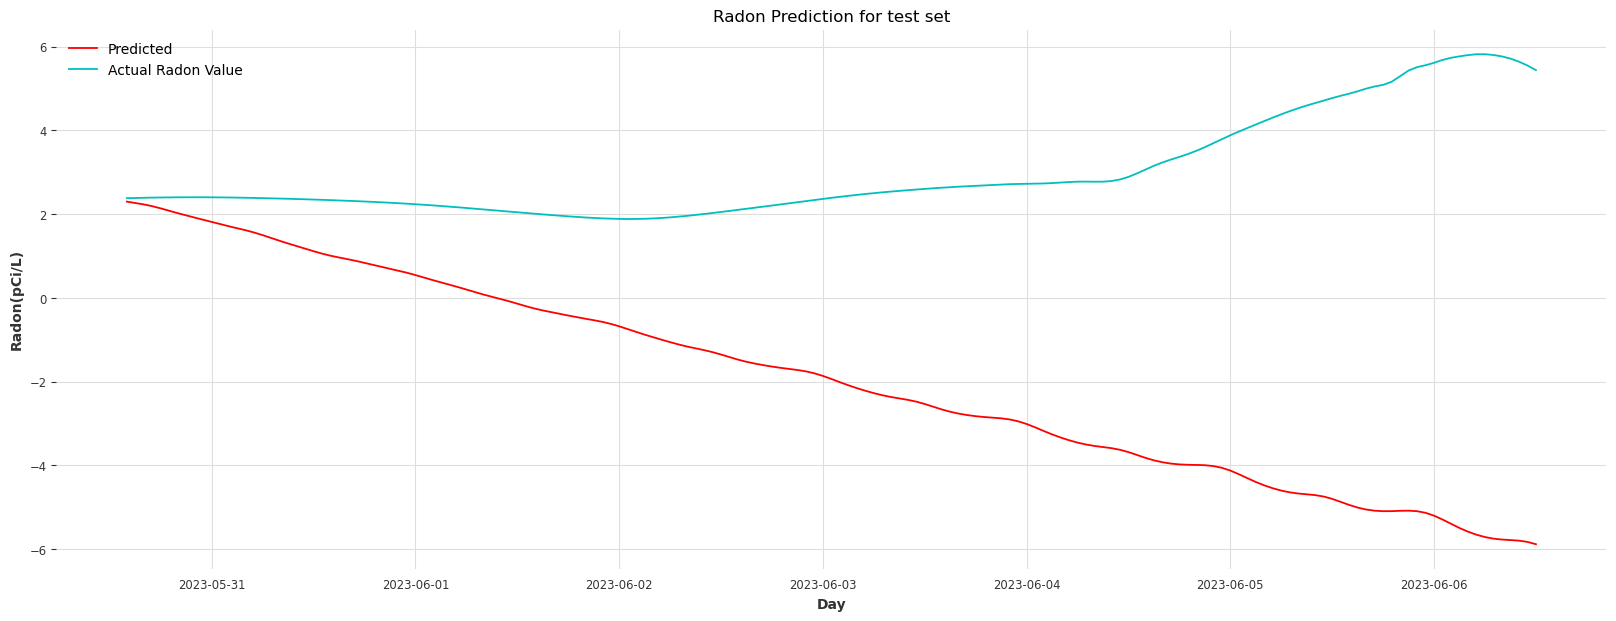

In [33]:
# plot the forecast
plt.figure(100, figsize=(20, 7))
plt.plot(dfY.index, dfY['Predicted'], color='r', label='Predicted')
plt.plot(dfY.index, dfY['Actual'], color='c', label='Actual Radon Value')
plt.legend()
plt.title('Radon Prediction for test set')
plt.xlabel('Day')
plt.ylabel('Radon(pCi/L)')
plt.show()